In [21]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF 
import scipy.stats
import scipy.spatial as sp
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.pyplot as plt

import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense, Layer, InputSpec
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, activations, initializers, constraints, Sequential
from keras import backend as K
from keras.constraints import UnitNorm, Constraint

simulated_samples = np.loadtxt("simulated_samples.txt", dtype="int")
true_suitability = np.loadtxt("true_suitability.txt", dtype="float")

print(simulated_samples.shape)
X_train_scaled = simulated_samples[:10000]
print(X_train_scaled.shape)

(10000, 1000)
(10000, 1000)


In [54]:
def normalize(array):
    normalized = []
    min_val = min(array)
    max_val = max(array)
    for i in range(0, len(array)):
        normalized.append((array[i] - min_val) / (max_val - min_val))
    return normalized

def compare_matrixes(generated, true, name):
    print(name)
    print('Spearman: {0}'.format(scipy.stats.spearmanr(generated, true).correlation))
    print('Spearman: {0}'.format(scipy.stats.pearsonr(generated, true)))
    print('MAE {}'.format(mean_absolute_error(generated, true)))

input_dim = simulated_samples.shape[1]
def create_and_compile_autoencoder_A(encoding_dim, nb_epoch, batch_size):
    autoencoder = Sequential()
    autoencoder.add(Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = False))
    autoencoder.add(Dense(input_dim, activation="sigmoid", use_bias = False))
    autoencoder.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer='adadelta')
    
    autoencoder.summary()
    
    autoencoder.fit(simulated_samples, simulated_samples,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)
    
    train_predictions = autoencoder.predict(simulated_samples)
    print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(simulated_samples, train_predictions))
    
    result_flattened = normalize(train_predictions.flatten())
    true_flattened = true_suitability.flatten()
    compare_matrixes(result_flattened, true_flattened, 'Autoencoder A')
    
    zero_result_flattened = normalize(np.array(train_predictions)[np.where(simulated_samples==0)])
    zero_true_flattened = np.array(true_suitability)[np.where(simulated_samples==0)]
    compare_matrixes(zero_result_flattened, zero_true_flattened, 'Autoencoder A (dark diversity)')
    
def create_and_compile_autoencoder_B(encoding_dim, nb_epoch, batch_size):
    autoencoder = Sequential()
    autoencoder.add(Dense(32, activation="linear", input_shape=(input_dim,), use_bias = False))
    autoencoder.add(Dense(encoding_dim, activation="linear", use_bias = False))
    autoencoder.add(Dense(32, activation="linear", use_bias = False))
    autoencoder.add(Dense(input_dim, activation="sigmoid", use_bias = False))

    autoencoder.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer='adadelta')
    autoencoder.summary()
    
    autoencoder_history = autoencoder.fit(simulated_samples, simulated_samples,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)
    
    train_predictions = autoencoder.predict(simulated_samples)
    print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(simulated_samples, train_predictions))
    
    result_flattened = normalize(train_predictions.flatten())
    true_flattened = true_suitability.flatten()
    compare_matrixes(result_flattened, true_flattened, 'Autoencoder B')
    
    zero_result_flattened = normalize(np.array(train_predictions)[np.where(simulated_samples==0)])
    zero_true_flattened = np.array(true_suitability)[np.where(simulated_samples==0)]
    compare_matrixes(zero_result_flattened, zero_true_flattened, 'Autoencoder B (dark diversity)')
    
def create_and_compile_autoencoder_C(encoding_dim, nb_epoch, batch_size, samples):
    autoencoder = Sequential()
    autoencoder.add(Dense(32, activation="relu", input_shape=(input_dim,), use_bias = False))
    autoencoder.add(Dense(encoding_dim, activation="linear", use_bias = False))
    autoencoder.add(Dense(32, activation="relu", use_bias = False))
    autoencoder.add(Dense(input_dim, activation="sigmoid", use_bias = False))

    autoencoder.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer='adadelta')
    autoencoder.summary()
    
    autoencoder_history = autoencoder.fit(samples, samples,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)
    
    train_predictions = autoencoder.predict(samples)
    print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(samples, train_predictions))
    
    result_flattened = normalize(train_predictions.flatten())
    true_flattened = true_suitability.flatten()
    compare_matrixes(result_flattened, true_flattened, 'Autoencoder C')
    
    zero_result_flattened = normalize(np.array(train_predictions)[np.where(samples==0)])
    zero_true_flattened = np.array(true_suitability)[np.where(samples==0)]
    compare_matrixes(zero_result_flattened, zero_true_flattened, 'Autoencoder C (dark diversity)')

In [35]:
create_and_compile_autoencoder_A(2, 50, 64)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 2)                 2000      
_________________________________________________________________
dense_30 (Dense)             (None, 1000)              2000      
Total params: 4,000
Trainable params: 4,000
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01426329416496032
Autoencoder A
Spearman: 0.1169118256944502
Spearman: (-0.11437725109866789, 0.0)
MAE 0.4295746678501429
Autoencoder A (dark diversity)
Spearman: 0.11637067207701807
Spearman: (-0.11361671609330039, 0.0)
MAE 0.42586619117442587


In [36]:
create_and_compile_autoencoder_A(2, 100, 64)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 2)                 2000      
_________________________________________________________________
dense_32 (Dense)             (None, 1000)              2000      
Total params: 4,000
Trainable params: 4,000
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.0135143956281444
Autoencoder A
Spearman: 0.16952674550392102
Spearman: (-0.05813820918297451, 0.0)
MAE 0.4255641960968578
Autoencoder A (dark diversity)
Spearman: 0.16958026718539815
Spearman: (-0.057755640672667356, 0.0)
MAE 0.42181500576907943


In [37]:
create_and_compile_autoencoder_A(2, 500, 64)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 2)                 2000      
_________________________________________________________________
dense_34 (Dense)             (None, 1000)              2000      
Total params: 4,000
Trainable params: 4,000
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013034978919217888
Autoencoder A
Spearman: 0.24386586764234683
Spearman: (0.018910750249072676, 0.0)
MAE 0.42239686106661445
Autoencoder A (dark diversity)
Spearman: 0.2437023134067495
Spearman: (0.01855585665367377, 0.0)
MAE 0.41865268528955996


In [38]:
create_and_compile_autoencoder_A(2, 1000, 64)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 2)                 2000      
_________________________________________________________________
dense_36 (Dense)             (None, 1000)              2000      
Total params: 4,000
Trainable params: 4,000
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012974012640375341
Autoencoder A
Spearman: 0.5518073072214323
Spearman: (0.17059241372440842, 0.0)
MAE 0.41878965410464236
Autoencoder A (dark diversity)
Spearman: 0.5522118789936427
Spearman: (0.1697766079272819, 0.0)
MAE 0.4150922252121692


In [39]:
create_and_compile_autoencoder_A(2, 3000, 64)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2)                 2000      
_________________________________________________________________
dense_38 (Dense)             (None, 1000)              2000      
Total params: 4,000
Trainable params: 4,000
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012964448983899608
Autoencoder A
Spearman: 0.6493013143264394
Spearman: (0.21607130371280905, 0.0)
MAE 0.4172536441014427
Autoencoder A (dark diversity)
Spearman: 0.6504710751072311
Spearman: (0.2153511172890715, 0.0)
MAE 0.41356013593418345


In [40]:
create_and_compile_autoencoder_B(2, 50, 64)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_41 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_42 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013084255442986234
Autoencoder B
Spearman: 0.20699156186443993
Spearman: (-0.0004416425090355844, 0.1625350547174919)
MAE 0.42248647311152054
Autoencoder B (dark diversity)
Spearman: 0.20720564173442083
Spearman: (-0

In [41]:
create_and_compile_autoencoder_B(2, 100, 64)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_45 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_46 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013141225279164856
Autoencoder B
Spearman: 0.1896131160924474
Spearman: (-0.018367672681967845, 0.0)
MAE 0.4246230190471126
Autoencoder B (dark diversity)
Spearman: 0.18965781889390784
Spearman: (-0.0182899768748569,

In [42]:
create_and_compile_autoencoder_B(2, 500, 64)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_49 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_50 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013421048702784577
Autoencoder B
Spearman: 0.5529115536447805
Spearman: (0.18148343253119306, 0.0)
MAE 0.4166752742367464
Autoencoder B (dark diversity)
Spearman: 0.553836568282425
Spearman: (0.1809883744452988, 0.0)

In [43]:
create_and_compile_autoencoder_B(2, 1000, 64)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_53 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_54 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013383519814431904
Autoencoder B
Spearman: 0.5630040928804635
Spearman: (0.1694623308476349, 0.0)
MAE 0.42007221116096405
Autoencoder B (dark diversity)
Spearman: 0.5641196118247332
Spearman: (0.16911057609211808, 0.

In [44]:
create_and_compile_autoencoder_B(2, 3000, 64)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_56 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_57 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_58 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013123585344730564
Autoencoder B
Spearman: 0.5502128933731801
Spearman: (0.12882070032913134, 0.0)
MAE 0.42527538614273647
Autoencoder B (dark diversity)
Spearman: 0.5512446849398395
Spearman: (0.1285933026671636, 0.

In [49]:
create_and_compile_autoencoder_C(2, 50, 64)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_60 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_61 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_62 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012274939921803289
Autoencoder C
Spearman: 0.3542978748158831
Spearman: (0.10333006765040878, 0.0)
MAE 0.42101506195583277
Autoencoder C (dark diversity)
Spearman: 0.35351035250359136
Spearman: (0.10166048977805718, 

In [50]:
create_and_compile_autoencoder_C(2, 100, 64)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_64 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_65 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_66 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012219848411042313
Autoencoder C
Spearman: 0.40468570300570694
Spearman: (0.13184134373041106, 0.0)
MAE 0.42122564831854364
Autoencoder C (dark diversity)
Spearman: 0.4035829465946104
Spearman: (0.12980260280630768, 

In [51]:
create_and_compile_autoencoder_C(2, 500, 64)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_68 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_69 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_70 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012207125950526327
Autoencoder C
Spearman: 0.4313991299589643
Spearman: (0.1477013965474303, 0.0)
MAE 0.4207172099820869
Autoencoder C (dark diversity)
Spearman: 0.4303984925010249
Spearman: (0.14557205274374804, 0.0

In [52]:
create_and_compile_autoencoder_C(2, 1000, 64)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_72 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_73 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_74 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012117116122288852
Autoencoder C
Spearman: 0.8426252285381601
Spearman: (0.4432764271476431, 0.0)
MAE 0.4187083002087981
Autoencoder C (dark diversity)
Spearman: 0.8431413160465474
Spearman: (0.4393072249344735, 0.0)

In [53]:
create_and_compile_autoencoder_C(2, 3000, 64)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_76 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_77 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_78 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012100449398733556
Autoencoder C
Spearman: 0.8683648944693497
Spearman: (0.4743556757919536, 0.0)
MAE 0.41853537094297283
Autoencoder C (dark diversity)
Spearman: 0.868895315860148
Spearman: (0.47008837003337406, 0.0

In [55]:
observations = np.loadtxt('matrixes/{}.txt'.format('rep.50'), dtype="int", skiprows=1, usecols=range(1, 1001))
create_and_compile_autoencoder_C(2, 3000, 64, observations)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_80 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_81 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_82 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012151972322866982
Autoencoder C
Spearman: 0.8649957939012817
Spearman: (0.4190516553588247, 0.0)
MAE 0.41896474406373624
Autoencoder C (dark diversity)
Spearman: 0.8654921265709584
Spearman: (0.4147331133324948, 0.0

In [56]:
observations = np.loadtxt('matrixes/{}.txt'.format('rep.10'), dtype="int", skiprows=1, usecols=range(1, 1001))
create_and_compile_autoencoder_C(2, 3000, 64, observations)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_84 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_85 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_86 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.011985424660351723
Autoencoder C
Spearman: 0.8684283520136645
Spearman: (0.527694283429818, 0.0)
MAE 0.41828138089743594
Autoencoder C (dark diversity)
Spearman: 0.8689481403779127
Spearman: (0.5236234393093008, 0.0)

In [57]:
observations = np.loadtxt('matrixes/{}.txt'.format('rep.5'), dtype="int", skiprows=1, usecols=range(1, 1001))
create_and_compile_autoencoder_C(2, 3000, 64, observations)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_88 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_89 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_90 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012323812861246453
Autoencoder C
Spearman: 0.8631889178411393
Spearman: (0.3709289200978543, 0.0)
MAE 0.41923521337841196
Autoencoder C (dark diversity)
Spearman: 0.8637227039906468
Spearman: (0.3666873930230083, 0.0

In [58]:
observations = np.loadtxt('matrixes/{}.txt'.format('rep.47'), dtype="int", skiprows=1, usecols=range(1, 1001))
create_and_compile_autoencoder_C(2, 3000, 64, observations)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_92 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_93 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_94 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01217174024872978
Autoencoder C
Spearman: 0.86002577416346
Spearman: (0.4162084883771847, 0.0)
MAE 0.4203611109258706
Autoencoder C (dark diversity)
Spearman: 0.8604556011353529
Spearman: (0.41180448810776105, 0.0)
M

In [ ]:
observations = np.loadtxt('matrixes/{}.txt'.format('rep.33'), dtype="int", skiprows=1, usecols=range(1, 1001))
create_and_compile_autoencoder_C(2, 3000, 64, observations)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_96 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_97 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_98 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________


In [ ]:
observations = np.loadtxt('matrixes/{}.txt'.format('rep.3'), dtype="int", skiprows=1, usecols=range(1, 1001))
create_and_compile_autoencoder_C(2, 3000, 64, observations)

In [22]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [23]:
#from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

In [24]:
def normalize(array):
    normalized = []
    min_val = min(array)
    max_val = max(array)
    for i in range(0, len(array)):
        normalized.append((array[i] - min_val) / (max_val - min_val))
    return normalized

def compare_matrixes(generated, true, name):
    print(name)
    print('Spearman: {0}'.format(scipy.stats.spearmanr(generated, true).correlation))
    print('MAE {}'.format(mean_absolute_error(generated, true)))

In [25]:
def normalize(array):
    normalized = []
    min_val = min(array)
    max_val = max(array)
    for i in range(0, len(array)):
        normalized.append((array[i] - min_val) / (max_val - min_val))
    return normalized

def compare_matrixes(generated, true, name):
    print(name)
    print('Spearman: {0}'.format(scipy.stats.spearmanr(generated, true).correlation))
    print('MAE {}'.format(mean_absolute_error(generated, true)))

input_dim = simulated_samples.shape[1]
def create_and_compile_autoencoder(encoding_dim, nb_epoch, batch_size):
    autoencoder = Sequential()
    autoencoder.add(Dense(32, activation="linear", input_shape=(input_dim,), use_bias = False))
    autoencoder.add(Dense(encoding_dim, activation="linear", use_bias = False))
    autoencoder.add(Dense(32, activation="linear", use_bias = False))
    autoencoder.add(Dense(input_dim, activation="sigmoid", use_bias = False))

    autoencoder.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer='adadelta')
    autoencoder.summary()
    
    autoencoder_history = autoencoder.fit(simulated_samples, simulated_samples,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)
    
    train_predictions = autoencoder.predict(simulated_samples)
    print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(simulated_samples, train_predictions))
    
    result_flattened = normalize(train_predictions.flatten())
    true_flattened = true_suitability.flatten()
    compare_matrixes(result_flattened, true_flattened, 'first version')
    
    #loss = autoencoder_history.history['loss']
    #val_loss = autoencoder_history.history['val_loss']
    #epochs = range(epochs)
    #plt.figure()
    #plt.plot(epochs, loss, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    #plt.title('Training and validation loss')
    #plt.legend()
    #plt.show()

In [9]:
create_and_compile_autoencoder(2, 100, 256)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 64        
_________________________________________________________________
dense_7 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012982378970781347
first version
Spearman: 0.20804003885484867
MAE 0.4225214766123141


In [10]:
create_and_compile_autoencoder(3, 100, 256)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01298806778017201
first version
Spearman: 0.20876883290471013
MAE 0.4221329128164343


In [11]:
create_and_compile_autoencoder(4, 100, 256)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 128       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              32000     
Total params: 64,256
Trainable params: 64,256
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012986206751983576
first version
Spearman: 0.20899340951830364
MAE 0.4223972279679749


In [12]:
create_and_compile_autoencoder(3, 100, 128)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_19 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012990578122440482
first version
Spearman: 0.20955887476549886
MAE 0.4224224382167827


In [13]:
create_and_compile_autoencoder(3, 100, 64)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_23 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_24 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013220322089728306
first version
Spearman: 0.19744485469209408
MAE 0.42143705235659706


In [14]:
create_and_compile_autoencoder(3, 200, 128)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_27 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_28 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012976900826086048
first version
Spearman: 0.2068175356103231
MAE 0.4232741242003984


In [15]:
create_and_compile_autoencoder(3, 300, 128)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_31 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_32 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012996130978027274
first version
Spearman: 0.21338552187473178
MAE 0.42257237752546417


In [19]:
create_and_compile_autoencoder(3, 500, 32)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_47 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_48 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013671006531513638
first version
Spearman: 0.4597882787181062
MAE 0.4283272085118574


In [16]:
create_and_compile_autoencoder(3, 500, 64)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_35 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_36 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013207702232729353
first version
Spearman: 0.5579975822490061
MAE 0.42524104295135856


In [17]:
create_and_compile_autoencoder(3, 500, 128)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_39 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_40 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012973608296532426
first version
Spearman: 0.5434518977005565
MAE 0.4268259557230494


In [18]:
create_and_compile_autoencoder(3, 500, 256)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_42 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_43 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_44 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012928769716037033
first version
Spearman: 0.21658193742844506
MAE 0.4226969607770333


In [20]:
create_and_compile_autoencoder(3, 1000, 64)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_50 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_51 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_52 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01317599705699153
first version
Spearman: 0.5500608340007759
MAE 0.42525214743694634


In [6]:
create_and_compile_autoencoder(3, 10, 64)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________

Train reconstrunction error
 0.013231710353417891
first version
Spearman: 0.19837176018118002
MAE 0.42413006585834157


In [7]:
create_and_compile_autoencoder(4, 3000, 64)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 128       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                128       
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              32000     
Total params: 64,256
Trainable params: 64,256
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013184159582392689
first version
Spearman: 0.5548077574806733
MAE 0.4277263241239702


In [8]:
create_and_compile_autoencoder(4, 3000, 128)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 128       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,256
Trainable params: 64,256
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013070447077353043
first version
Spearman: 0.6085409591054499
MAE 0.42405905659206267


In [9]:
def normalize(array):
    normalized = []
    min_val = min(array)
    max_val = max(array)
    for i in range(0, len(array)):
        normalized.append((array[i] - min_val) / (max_val - min_val))
    return normalized

def compare_matrixes(generated, true, name):
    print(name)
    print('Spearman: {0}'.format(scipy.stats.spearmanr(generated, true).correlation))
    print('MAE {}'.format(mean_absolute_error(generated, true)))

input_dim = simulated_samples.shape[1]
def create_and_compile_autoencoder_RELU(encoding_dim, nb_epoch, batch_size):
    autoencoder = Sequential()
    autoencoder.add(Dense(32, activation="relu", input_shape=(input_dim,), use_bias = False))
    autoencoder.add(Dense(encoding_dim, activation="linear", use_bias = False))
    autoencoder.add(Dense(32, activation="relu", use_bias = False))
    autoencoder.add(Dense(input_dim, activation="sigmoid", use_bias = False))

    autoencoder.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer='adadelta')
    autoencoder.summary()
    
    autoencoder_history = autoencoder.fit(simulated_samples, simulated_samples,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)
    
    train_predictions = autoencoder.predict(simulated_samples)
    print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(simulated_samples, train_predictions))
    
    result_flattened = normalize(train_predictions.flatten())
    true_flattened = true_suitability.flatten()
    compare_matrixes(result_flattened, true_flattened, 'first version')

In [10]:
create_and_compile_autoencoder_RELU(2, 3000, 64)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_15 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012097788899749252
first version
Spearman: 0.8692115589809075
MAE 0.4202509650265714


In [11]:
create_and_compile_autoencoder_RELU(2, 3000, 128)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_19 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01210802763789825
first version
Spearman: 0.8611221615177052
MAE 0.41858048346765275


In [12]:
create_and_compile_autoencoder_RELU(3, 3000, 64)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_23 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_24 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01204794017969563
first version
Spearman: 0.828825945786252
MAE 0.41984136123703086


In [13]:
create_and_compile_autoencoder_RELU(3, 3000, 128)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_27 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_28 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012063144952407023
first version
Spearman: 0.834447680262218
MAE 0.4273803009967126


In [14]:
create_and_compile_autoencoder_RELU(4, 3000, 64)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 128       
_________________________________________________________________
dense_31 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_32 (Dense)             (None, 1000)              32000     
Total params: 64,256
Trainable params: 64,256
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.011962803896382468
first version
Spearman: 0.7953712844883577
MAE 0.4299540694914745


In [16]:
create_and_compile_autoencoder_RELU(4, 3000, 128)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 128       
_________________________________________________________________
dense_39 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_40 (Dense)             (None, 1000)              32000     
Total params: 64,256
Trainable params: 64,256
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01201899609995278
first version
Spearman: 0.8159322987204393
MAE 0.42837830990166154


In [17]:
create_and_compile_autoencoder(2, 5000, 128)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_43 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_44 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013039048701837816
first version
Spearman: 0.6137877570068749
MAE 0.42731666011988995


In [18]:
create_and_compile_autoencoder(3, 5000, 128)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_47 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_48 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.013000371188775301
first version
Spearman: 0.6229010894190181
MAE 0.4258899101812778


In [19]:
create_and_compile_autoencoder(4, 5000, 128)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 128       
_________________________________________________________________
dense_51 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_52 (Dense)             (None, 1000)              32000     
Total params: 64,256
Trainable params: 64,256
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.0128946920649487
first version
Spearman: 0.604012006000851
MAE 0.4260580822884314


In [20]:
create_and_compile_autoencoder_RELU(2, 5000, 128)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_54 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_55 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_56 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012101958855958581
first version
Spearman: 0.8646527026921587
MAE 0.4185644486393695


In [21]:
create_and_compile_autoencoder_RELU(3, 5000, 128)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 96        
_________________________________________________________________
dense_59 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_60 (Dense)             (None, 1000)              32000     
Total params: 64,192
Trainable params: 64,192
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01203838723694631
first version
Spearman: 0.8202323626001475
MAE 0.4301202182045472


In [22]:
create_and_compile_autoencoder_RELU(4, 5000, 128)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_62 (Dense)             (None, 4)                 128       
_________________________________________________________________
dense_63 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_64 (Dense)             (None, 1000)              32000     
Total params: 64,256
Trainable params: 64,256
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.011978539556995713
first version
Spearman: 0.8115431400853954
MAE 0.43010451299578967


In [11]:
def normalize(array):
    normalized = []
    min_val = min(array)
    max_val = max(array)
    for i in range(0, len(array)):
        normalized.append((array[i] - min_val) / (max_val - min_val))
    return normalized

def compare_matrixes(generated, true, name):
    print(name)
    print('Spearman: {0}'.format(scipy.stats.spearmanr(generated, true).correlation))
    print('Pearson: {0}'.format(scipy.stats.pearsonr(generated, true)))
    print('MAE {}'.format(mean_absolute_error(generated, true)))

input_dim = simulated_samples.shape[1]
def create_and_compile_autoencoder_RELU_optimizer(encoding_dim, nb_epoch, batch_size, optimizer_algo):
    autoencoder = Sequential()
    autoencoder.add(Dense(32, activation="relu", input_shape=(input_dim,), use_bias = False))
    autoencoder.add(Dense(encoding_dim, activation="linear", use_bias = False))
    autoencoder.add(Dense(32, activation="relu", use_bias = False))
    autoencoder.add(Dense(input_dim, activation="sigmoid", use_bias = False))

    autoencoder.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer=optimizer_algo)
    autoencoder.summary()
    
    history = autoencoder.fit(simulated_samples, simulated_samples,
                epochs=nb_epoch,
                batch_size=batch_size,
                validation_data=(simulated_samples, simulated_samples),
                shuffle=True,
                verbose=0)
    
    model_name = 'v3_inner_{}_batch_{}_epochs_{}_optimizer_{}'.format(encoding_dim, batch_size, nb_epoch, optimizer_algo)
    autoencoder.save('autoencoder_models/{}.h5'.format(model_name))
    
    train_predictions = autoencoder.predict(simulated_samples)
    print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(simulated_samples, train_predictions))
    
    result_flattened = normalize(train_predictions.flatten())
    true_flattened = true_suitability.flatten()
    compare_matrixes(result_flattened, true_flattened, 'Compare result to true: ' + model_name)
    
    # plot training history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
from keras.models import load_model
def test_saved_autoencoder(encoding_dim, nb_epoch, batch_size, optimizer_algo):
    # load model
    model_name = 'v3_inner_{}_batch_{}_epochs_{}_optimizer_{}'.format(encoding_dim, batch_size, nb_epoch, optimizer_algo)
    autoencoder = load_model('autoencoder_models/{}.h5'.format(model_name))
    # summarize model.
    autoencoder.summary()
    
    train_predictions = autoencoder.predict(simulated_samples)
    print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(simulated_samples, train_predictions))
    
    result_flattened = normalize(train_predictions.flatten())
    true_flattened = true_suitability.flatten()
    compare_matrixes(result_flattened, true_flattened, 'Compare result to true: ' + model_name)
    
    zero_result_flattened = normalize(np.array(train_predictions)[np.where(simulated_samples==0)])
    zero_true_flattened = np.array(true_suitability)[np.where(simulated_samples==0)]
    compare_matrixes(zero_result_flattened, zero_true_flattened, 'Compare (zeros) result to true: ' + model_name)

In [13]:
test_saved_autoencoder(2, 3000, 64, 'adadelta')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01209884349791786
Compare result to true: v3_inner_2_batch_64_epochs_3000_optimizer_adadelta
Spearman: 0.8669273004704494
Pearson: (0.4723104798401869, 0.0)
MAE 0.41855796119292815
Compare (zeros) result to true: v3_i

In [12]:
test_saved_autoencoder(2, 5000, 64, 'adadelta')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012086197218607351
Compare result to true: v3_inner_2_batch_64_epochs_5000_optimizer_adadelta
Spearman: 0.8558060844784152
Pearson: (0.4667091482897264, 0.0)
MAE 0.42085240243366445
Compare (zeros) result to true: v3_

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 64        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________

Train reconstrunction error
 0.012080407055436435
Compare result to true: v3_inner_2_batch_50_epochs_5000_optimizer_adadelta
Spearman: 0.8530656665751483

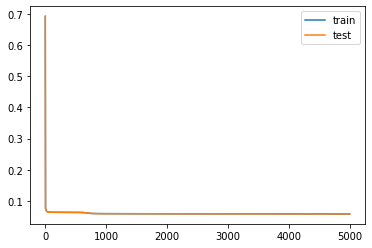

In [5]:
create_and_compile_autoencoder_RELU_optimizer(2, 5000, 50, 'adadelta')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 64        
_________________________________________________________________
dense_7 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012099052506427822
Compare result to true: v3_inner_2_batch_100_epochs_5000_optimizer_adadelta
Spearman: 0.8668529183202607
MAE 0.41854521477336387


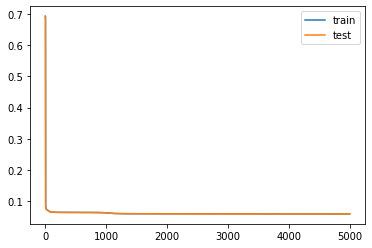

In [6]:
create_and_compile_autoencoder_RELU_optimizer(2, 5000, 100, 'adadelta')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012040165333589564
Compare result to true: v3_inner_2_batch_50_epochs_5000_optimizer_adam
Spearman: 0.7874338874154203
MAE 0.43010512469676754


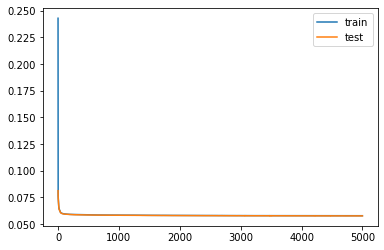

In [7]:
create_and_compile_autoencoder_RELU_optimizer(2, 5000, 50, 'adam')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_15 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012048249092125683
Compare result to true: v3_inner_2_batch_100_epochs_5000_optimizer_adam
Spearman: 0.806204394471113
MAE 0.43012516883105806


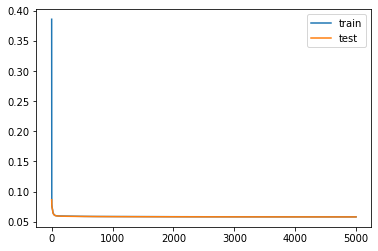

In [8]:
create_and_compile_autoencoder_RELU_optimizer(2, 5000, 100, 'adam')

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 32)                32000     
_________________________________________________________________
dense_106 (Dense)            (None, 2)                 64        
_________________________________________________________________
dense_107 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_108 (Dense)            (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01266758909704486
Compare result to true: v3_inner_2_batch_32_epochs_5_optimizer_adam
Spearman: 0.25298134548889734
MAE 0.4213970620229316


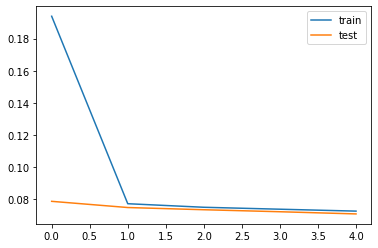

In [52]:
create_and_compile_autoencoder_RELU_optimizer(2, 5, 32, 'adam')

In [56]:
test_saved_autoencoder(2, 5, 32, 'adam')

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 32)                32000     
_________________________________________________________________
dense_106 (Dense)            (None, 2)                 64        
_________________________________________________________________
dense_107 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_108 (Dense)            (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01266758909704486
Compare result to true: v3_inner_2_batch_32_epochs_5_optimizer_adam
Spearman: 0.25298134548889734
MAE 0.4213970620229316


In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF 
import scipy.stats
import scipy.spatial as sp
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense, Layer, InputSpec
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, activations, initializers, constraints, Sequential
from keras import backend as K
from keras.constraints import UnitNorm, Constraint

simulated_samples = np.loadtxt("simulated_samples.txt", dtype="int")
true_suitability = np.loadtxt("true_suitability.txt", dtype="float")

print(simulated_samples.shape)
X_train_scaled = simulated_samples[:10000]
print(X_train_scaled.shape)

C:\Users\siimk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\siimk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\siimk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\siimk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

(10000, 1000)
(10000, 1000)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 64        
_________________________________________________________________
dense_7 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012967540110920201
Compare result to true: v3_inner_2_batch_64_epochs_10_optimizer_adadelta
Spearman: 0.2146107606339373
MAE 0.4229353138774895


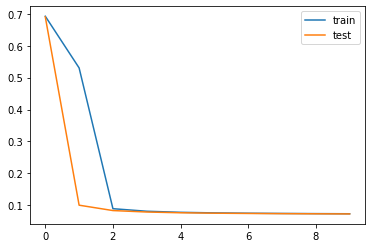

In [4]:
create_and_compile_autoencoder_RELU_optimizer(2, 10, 64, 'adadelta')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01209884349791786
Compare result to true: v3_inner_2_batch_64_epochs_3000_optimizer_adadelta
Spearman: 0.8669273004704494
MAE 0.41855796119292815


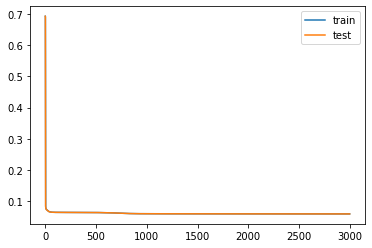

In [5]:
create_and_compile_autoencoder_RELU_optimizer(2, 3000, 64, 'adadelta')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_15 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012086908323223977
Compare result to true: v3_inner_2_batch_32_epochs_3000_optimizer_adadelta
Spearman: 0.8604768122239581
MAE 0.41911646111401735


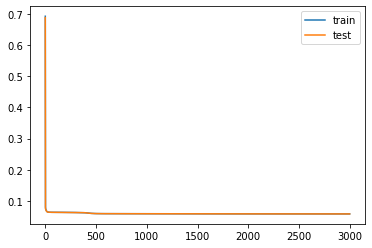

In [6]:
create_and_compile_autoencoder_RELU_optimizer(2, 3000, 32, 'adadelta')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_23 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_24 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01219788745934067
Compare result to true: v3_inner_2_batch_64_epochs_500_optimizer_adadelta
Spearman: 0.42691948189560885
MAE 0.420786406316204


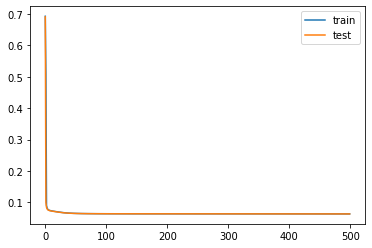

In [8]:
create_and_compile_autoencoder_RELU_optimizer(2, 500, 64, 'adadelta')

In [10]:
#create_and_compile_autoencoder_RELU_optimizer(2, 500, 32, 'adadelta')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_31 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_32 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01250425939128722
Compare result to true: v3_inner_2_batch_64_epochs_3000_optimizer_sgd
Spearman: 0.2597594270325144
MAE 0.421531470413296


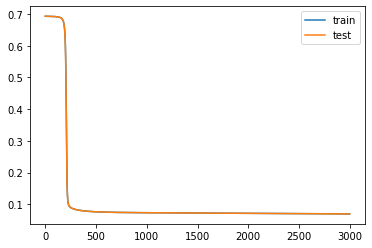

In [11]:
create_and_compile_autoencoder_RELU_optimizer(2, 3000, 64, 'sgd')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_35 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_36 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012054347222732709
Compare result to true: v3_inner_2_batch_32_epochs_3000_optimizer_adam
Spearman: 0.7994072815263602
MAE 0.4300447605205888


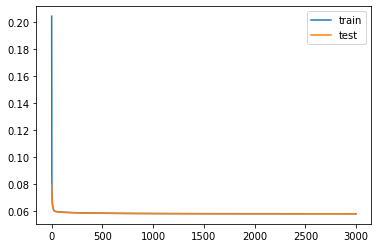

In [12]:
create_and_compile_autoencoder_RELU_optimizer(2, 3000, 32, 'adam')

# Create plots using best saved autoencoder models just like with NMF

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF 
import scipy.stats
import scipy.spatial as sp
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense, Layer, InputSpec
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, activations, initializers, constraints, Sequential
from keras import backend as K
from keras.constraints import UnitNorm, Constraint

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

simulated_samples = np.loadtxt("simulated_samples.txt", dtype="int")
true_suitability = np.loadtxt("true_suitability.txt", dtype="float")

C:\Users\siimk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\siimk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\siimk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\siimk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [18]:
def normalize(array):
    normalized = []
    min_val = min(array)
    max_val = max(array)
    for i in range(0, len(array)):
        normalized.append((array[i] - min_val) / (max_val - min_val))
    return normalized

from math import log, ceil
def create_matrix_compare_plot_average(X, Y, x_label, y_label, title):
    Y = np.around(Y, decimals=3)
    X_argsort = X.argsort()
    sorted_x = X[X_argsort]
    sorted_y = Y[X_argsort]
    
    # divide X into so many subsections:
    for x_range in [100000]:
        average_y = {}
        for i in range(0, x_range + 1):
            average_y[i / x_range] = 0
        #print(average_y)

        for x_indx in range(0, len(sorted_x)):
            x = sorted_x[x_indx]
            y = sorted_y[x_indx]
            average_y[round(x,  ceil(log(x_range, 10)))] = round((average_y[round(x, ceil(log(x_range, 10)))] + y) / 2, 4)

        X = [(i / x_range) for i in range(0, x_range + 1)]
        Y = [average_y[key] for key in X]


        z = np.polyfit(X, Y, 1)
        p = np.poly1d(z)
        print('trendline at 0: ' + str(p(0)))
        print('trendline at 0.5: ' + str(p(0.5)))
        print('trendline at 1: ' + str(p(1)))
        fig = plt.figure(figsize=(25, 15))
        plt.scatter(X, Y, c='r', s=10)
        plt.xlabel(x_label, fontsize=19)
        plt.ylabel(y_label, fontsize=19)
        plt.plot(X,p(X),"b--")
        plt.title(title)
        plt.show()
        
def create_histograms(generated, actual_values, avg_of_present):
    titles = 'All predicted mistakes'
    data = [generated, actual_values]
    titles = ['Generated values', 'Actual values']
    
    rescale_by = [avg_of_present]
    rescaled_generated_values = []
    for rescale_val in rescale_by:
        rescaled_values = []
        for val in generated:
            new_val = 1 if val*rescale_val > 1 else val*rescale_val
            rescaled_values.append(new_val)
        rescaled_generated_values.append(rescaled_values)

    print('Spearman base: {0}'.format(scipy.stats.spearmanr(generated, actual_values).correlation))
    print('Pearson: {0}'.format(scipy.stats.pearsonr(generated, actual_values)))
    print('MAE {}'.format(mean_absolute_error(generated, actual_values)))
    f, a = plt.subplots(1, 2, figsize=(20, 10))
    a = a.ravel()
    for idx, ax in enumerate(a):
        ax.hist(data[idx])
        ax.set_title(titles[idx])
        ax.set_xlabel('Cell value')
        ax.set_ylabel('Value count')
    plt.tight_layout()
    
    for rescale in rescaled_generated_values:
        data_rescaled = [rescale, actual_values]
        print('Spearman rescaled: {0}'.format(scipy.stats.spearmanr(rescale, actual_values).correlation))
        print('Pearson: {0}'.format(scipy.stats.pearsonr(rescale, actual_values)))
        print('MAE rescaled {}'.format(mean_absolute_error(rescale, actual_values)))
        f, a = plt.subplots(1, 2, figsize=(20, 10))
        a = a.ravel()
        for idx, ax in enumerate(a):
            ax.hist(data_rescaled[idx])
            ax.set_title(titles[idx])
            ax.set_xlabel('Cell value')
            ax.set_ylabel('Value count')
        plt.tight_layout()

def compare_matrixes(generated, true, name):
    print(name)
    print('Spearman: {0}'.format(scipy.stats.spearmanr(generated, true).correlation))
    print('Pearson: {0}'.format(scipy.stats.pearsonr(generated, true)))
    print('MAE {}'.format(mean_absolute_error(generated, true)))
    
def print_general_info(result_flattened, true_flattened):
    print('Generated info:')
    print('    Amount of zeros: ' + str(len([i for i in result_flattened if i == 0])))
    print('    Amount of ones: ' + str(len([i for i in result_flattened if i == 1])))
    print('    Amount of < 0.001 (0.1%): ' + str(len([i for i in result_flattened if i < 0.001])))
    print('    Amount of < 0.005 (0.5%): ' + str(len([i for i in result_flattened if i < 0.005])))
    print('    Amount of < 0.01 (1%): ' + str(len([i for i in result_flattened if i < 0.01])))
    print('    Amount of > 0.999 (99.9%): ' + str(len([i for i in result_flattened if i > 0.999])))
    print('    Amount of > 0.995 (99.5%): ' + str(len([i for i in result_flattened if i > 0.995])))
    print('    Amount of > 0.99 (99%): ' + str(len([i for i in result_flattened if i > 0.99])))
    print('    Max value in matrix: ' + str(max(result_flattened)))
    print('    Min value in matrix: ' + str(min(result_flattened)))
    
    print('True info:')
    print('    Amount of zeros: ' + str(len([i for i in true_flattened if i == 0])))
    print('    Amount of ones: ' + str(len([i for i in true_flattened if i == 1])))
    print('    Amount of < 0.001 (0.1%): ' + str(len([i for i in true_flattened if i < 0.001])))
    print('    Amount of < 0.005 (0.5%): ' + str(len([i for i in true_flattened if i < 0.005])))
    print('    Amount of < 0.01 (1%): ' + str(len([i for i in true_flattened if i < 0.01])))
    print('    Amount of > 0.999 (99.9%): ' + str(len([i for i in true_flattened if i > 0.999])))
    print('    Amount of > 0.995 (99.5%): ' + str(len([i for i in true_flattened if i > 0.995])))
    print('    Amount of > 0.99 (99%): ' + str(len([i for i in true_flattened if i > 0.99])))
    print('    Max value in matrix: ' + str(max(true_flattened)))
    print('    Min value in matrix: ' + str(min(true_flattened)))
    
from keras.models import load_model
def test_saved_autoencoder(encoding_dim, nb_epoch, batch_size, optimizer_algo, general_info=False, plot_value_histograms=False, scatter_plot_real_and_generated=False):
    # load model
    model_name = 'v3_inner_{}_batch_{}_epochs_{}_optimizer_{}'.format(encoding_dim, batch_size, nb_epoch, optimizer_algo)
    autoencoder = load_model('autoencoder_models/{}.h5'.format(model_name))
    # summarize model.
    autoencoder.summary()
    
    train_predictions = autoencoder.predict(simulated_samples)
    print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(simulated_samples, train_predictions))
    
    # check 99th percentaile
    #print("check 99.9 - ones")
    #estimated_99_check = np.array(train_predictions)[np.where(simulated_samples==1)]
    #estimated_99_check = normalize(estimated_99_check)
    #estimated_99_check = np.sort(estimated_99_check)
    #print(len(estimated_99_check))
    #print(estimated_99_check[(len(estimated_99_check) * 999 // 1000)])
    #print(estimated_99_check[(len(estimated_99_check) * 999 // 1000):len(estimated_99_check)])
    
    #print("check 99.9; 99; 95; 90 - all")
    #estimated_99_check2 = normalize(train_predictions.flatten())
    #estimated_99_check2 = true_suitability.flatten()
    #estimated_99_check2 = np.sort(estimated_99_check2)
    #print(estimated_99_check2[len(estimated_99_check2) * 999 // 1000])
    #print(estimated_99_check2[len(estimated_99_check2) * 99 // 100])
    #print(estimated_99_check2[len(estimated_99_check2) * 95 // 100])
    #print(estimated_99_check2[len(estimated_99_check2) * 90 // 100])
    
    # check the avg of present and not present species
    estimated_matrix_zero = np.array(train_predictions)[np.where(simulated_samples==0)]
    estimated_matrix_zero = normalize(estimated_matrix_zero)
    print('Zeros average:')
    print(sum(estimated_matrix_zero) / len(estimated_matrix_zero))
    estimated_matrix_one = np.array(train_predictions)[np.where(simulated_samples==1)]
    estimated_matrix_one = normalize(estimated_matrix_one)
    print('Ones average:')
    avg_of_present = sum(estimated_matrix_one) / len(estimated_matrix_one)
    print(avg_of_present)
    
    result_flattened = normalize(train_predictions.flatten())
    true_flattened = true_suitability.flatten()
    
    if general_info:
        print_general_info(result_flattened, true_flattened)
    if plot_value_histograms:
        create_histograms(result_flattened, true_flattened, 1 / avg_of_present)
    if scatter_plot_real_and_generated:
        create_matrix_compare_plot_average(true_flattened, result_flattened, 'true matrix', 'generated matrix', 'Average generated value per true matrix value')
        #create_matrix_compare_plot_average(true_flattened, np.absolute(np.subtract(true_flattened, result_flattened)), 'true matrix', 'mistake value (abs of true-generated)', 'Average generated matrix mistake per true matrix value')
        #create_matrix_compare_plot_average_rescale(true_flattened, result_flattened, 'true matrix', 'generated matrix', 'Average generated value per true matrix value')
        #create_matrix_compare_plot_average_rescale(true_flattened, result_flattened, 'true matrix', 'mistake value (abs of true-generated)', 'Average generated matrix mistake per true matrix value', mistakes=True)
    
    compare_matrixes(result_flattened, true_flattened, 'Compare result to true: ' + model_name)
    
    zero_result_flattened = normalize(np.array(train_predictions)[np.where(simulated_samples==0)])
    zero_true_flattened = np.array(true_suitability)[np.where(simulated_samples==0)]
    compare_matrixes(zero_result_flattened, zero_true_flattened, 'Compare (zeros) result to true: ' + model_name)
    

In [19]:
a = [0, 0, 0, 0, 0, 0, 1, 2, 50, 4, 5, 6]
b = [0, 0, 0, 0, 0.1, 0, 2, 3, 4, 8, 10, 100]
compare_matrixes(a, b, 'testing')
#print(ceil(log(1000, 10)))
#print(9 // 3)

testing
Spearman: 0.9249541853707662
Pearson: (0.038510309757910796, 0.9054156849582967)
MAE 12.591666666666667


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012086197218607351
Zeros average:
0.024918346178956698
Ones average:
0.049774795022960845
Spearman base: 0.8558060844784152
Pearson: (0.4667091482897264, 0.0)
MAE 0.42085240243366445
Spearman rescaled: 0.8563567591765

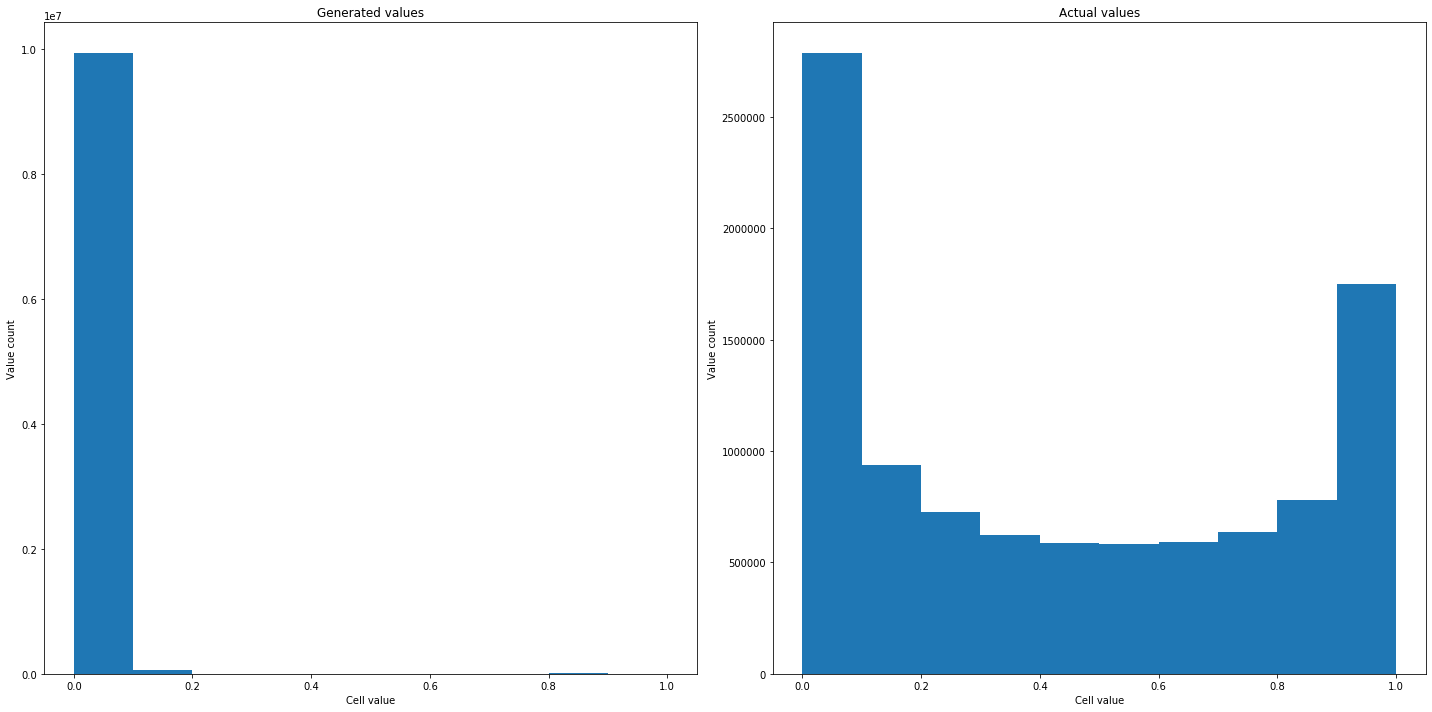

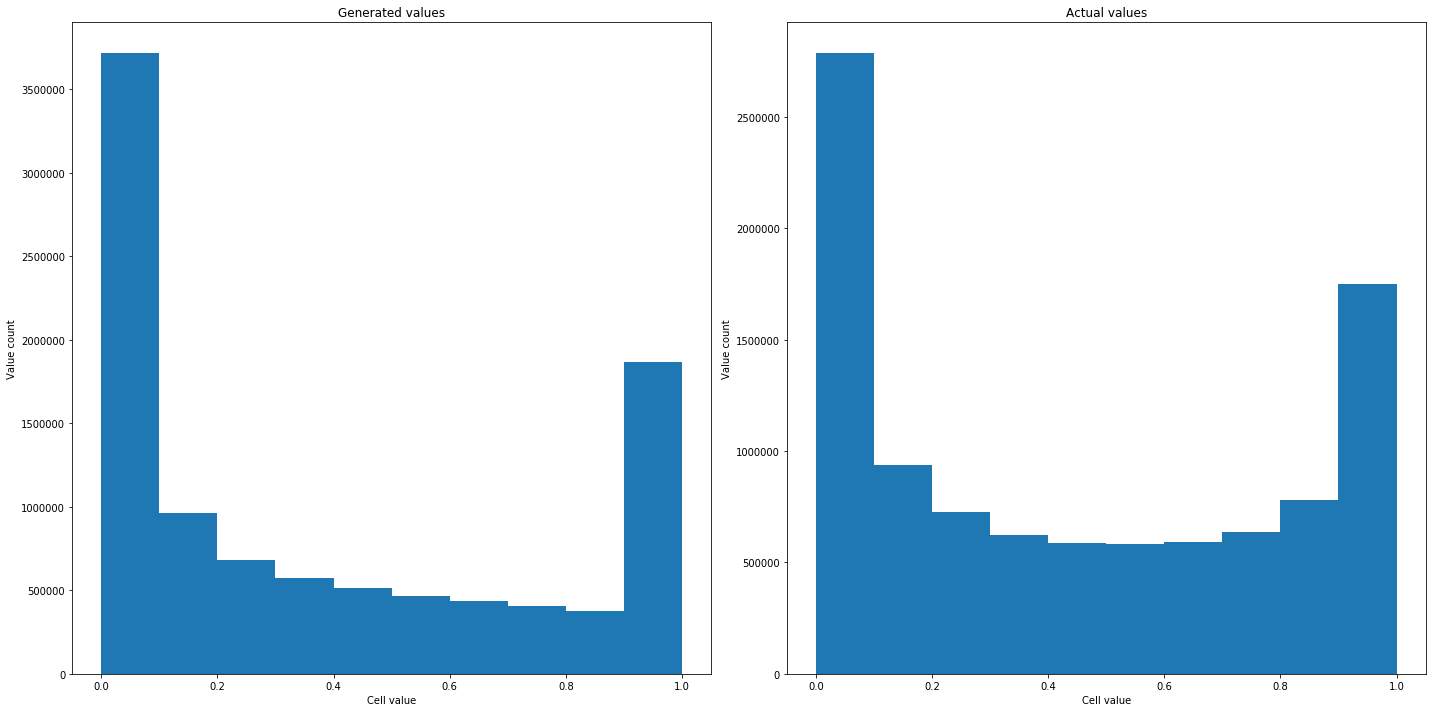

In [20]:
test_saved_autoencoder(2, 5000, 64, 'adadelta', plot_value_histograms=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012086197218607351
Compare result to true: v3_inner_2_batch_64_epochs_5000_optimizer_adadelta
Spearman: 0.8558060844784152
MAE 0.42085240243366445


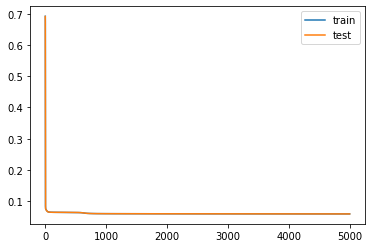

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012086197218607351
Zeros average:
0.024918346178956698
Ones average:
0.049774795022960845
Spearman base: 0.8558060844784152
MAE 0.42085240243366445
Spearman rescaled: 0.8563567591765048
MAE rescaled 0.1538648948128807

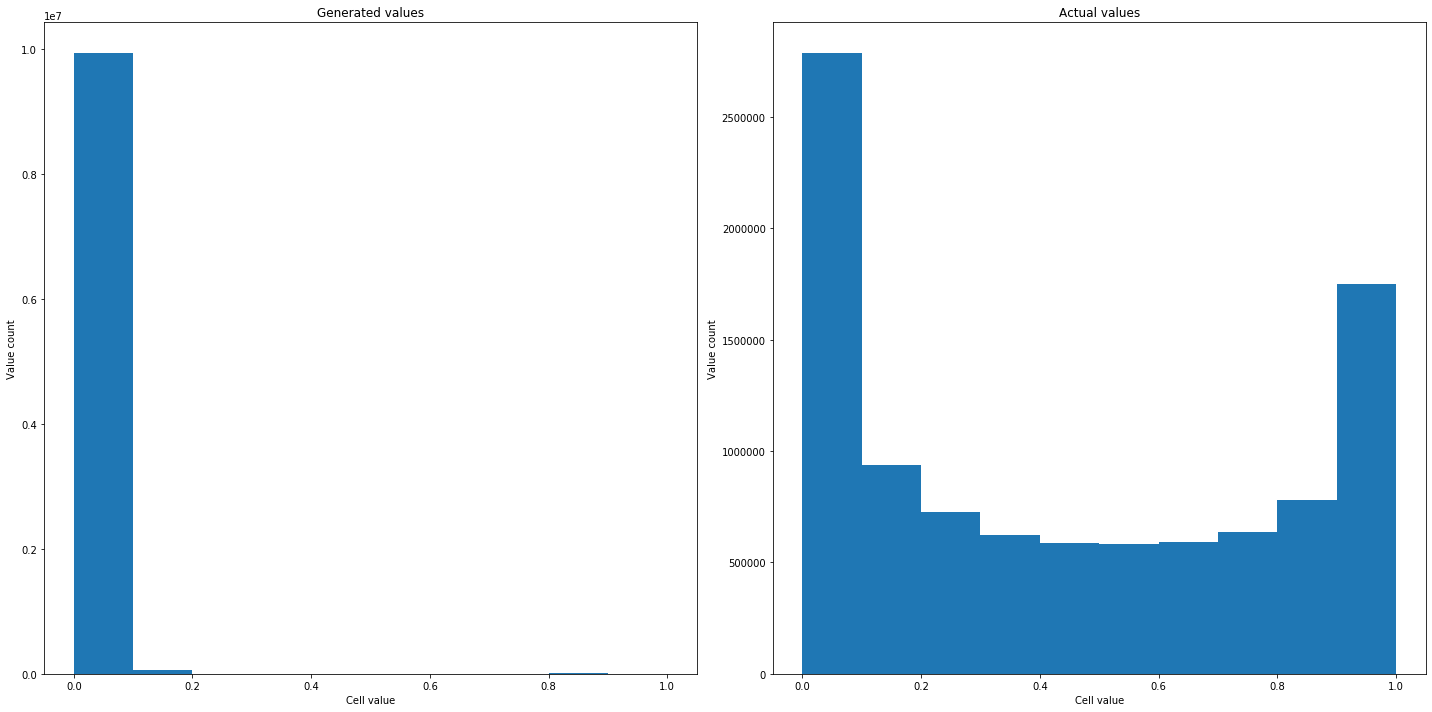

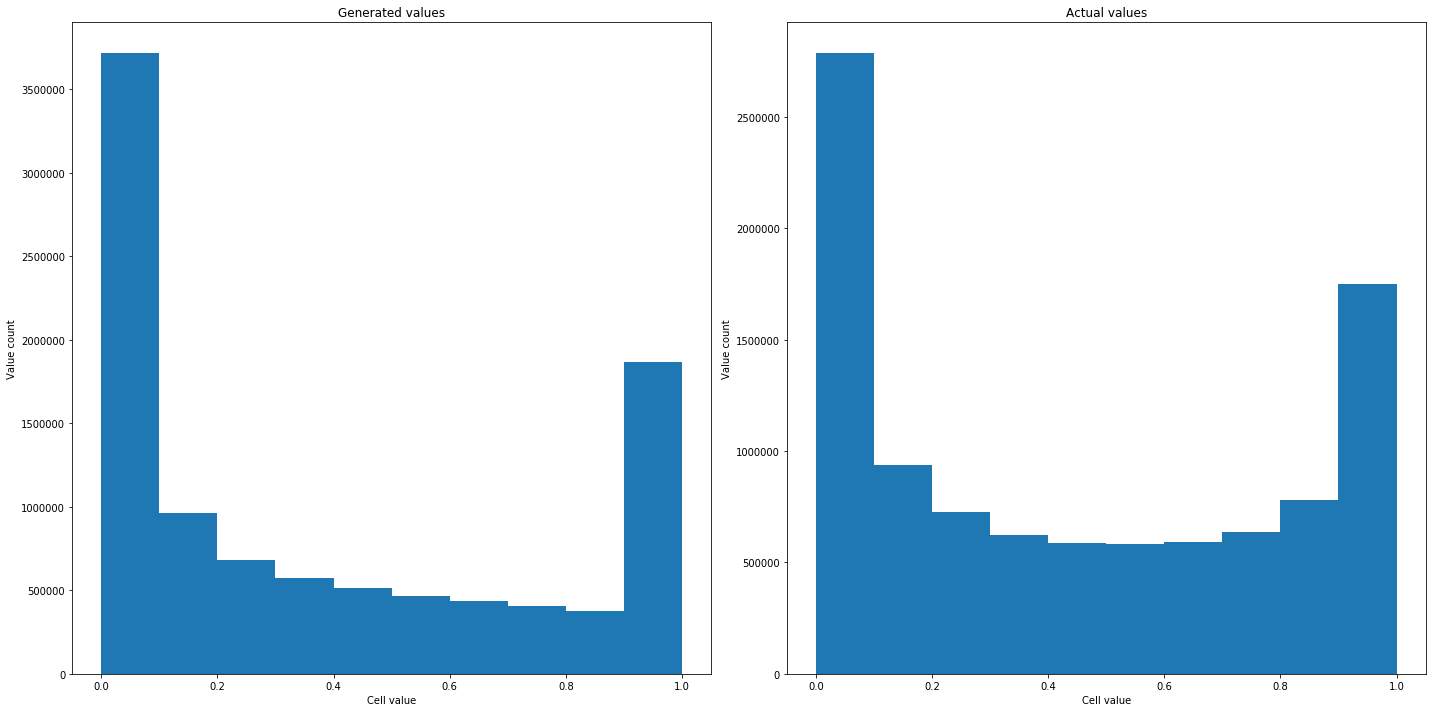

In [29]:
create_and_compile_autoencoder_RELU_optimizer(2, 5000, 64, 'adadelta')
test_saved_autoencoder(2, 5000, 64, 'adadelta', plot_value_histograms=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01209884349791786
Zeros average:
0.025001878312509572
Ones average:
0.08664629271035935
Spearman base: 0.8669273004704494
MAE 0.41855796119292815
Spearman rescaled: 0.8670450768449294
MAE rescaled 0.19177853657887708


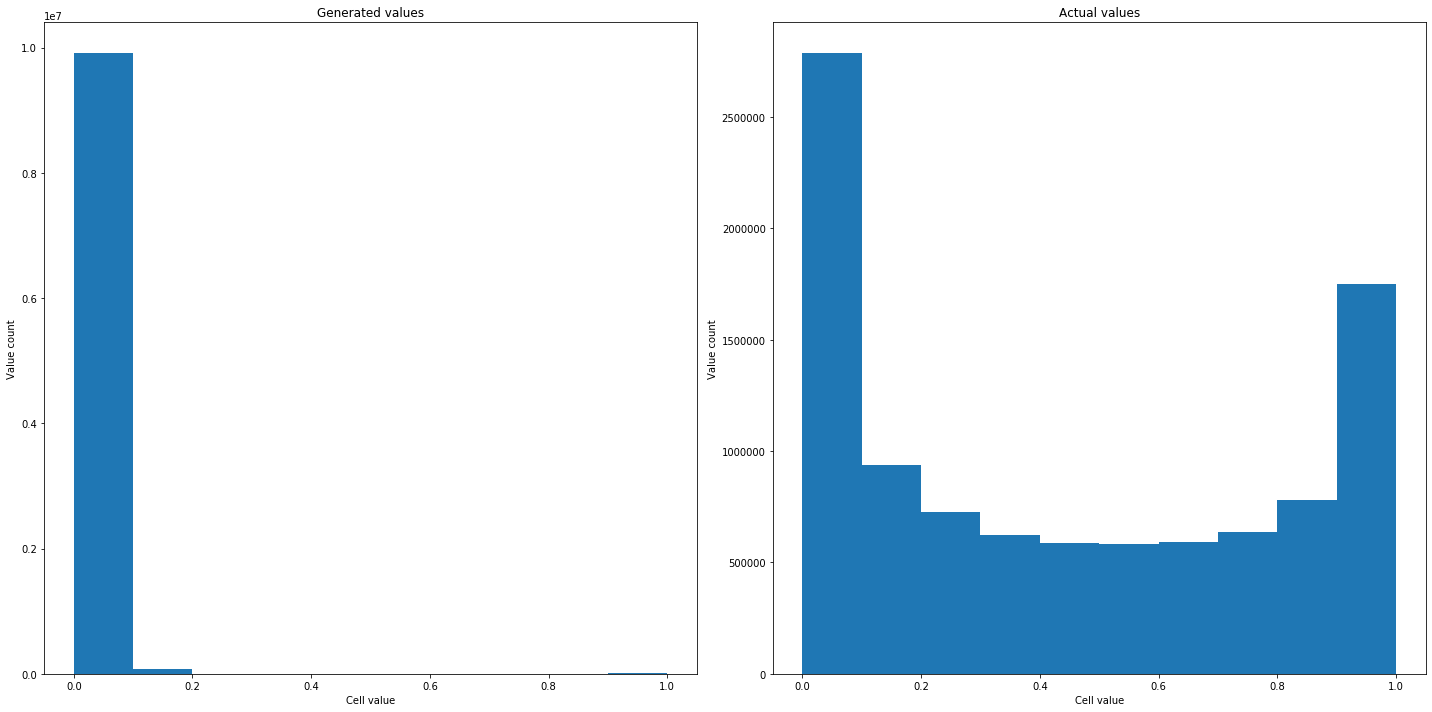

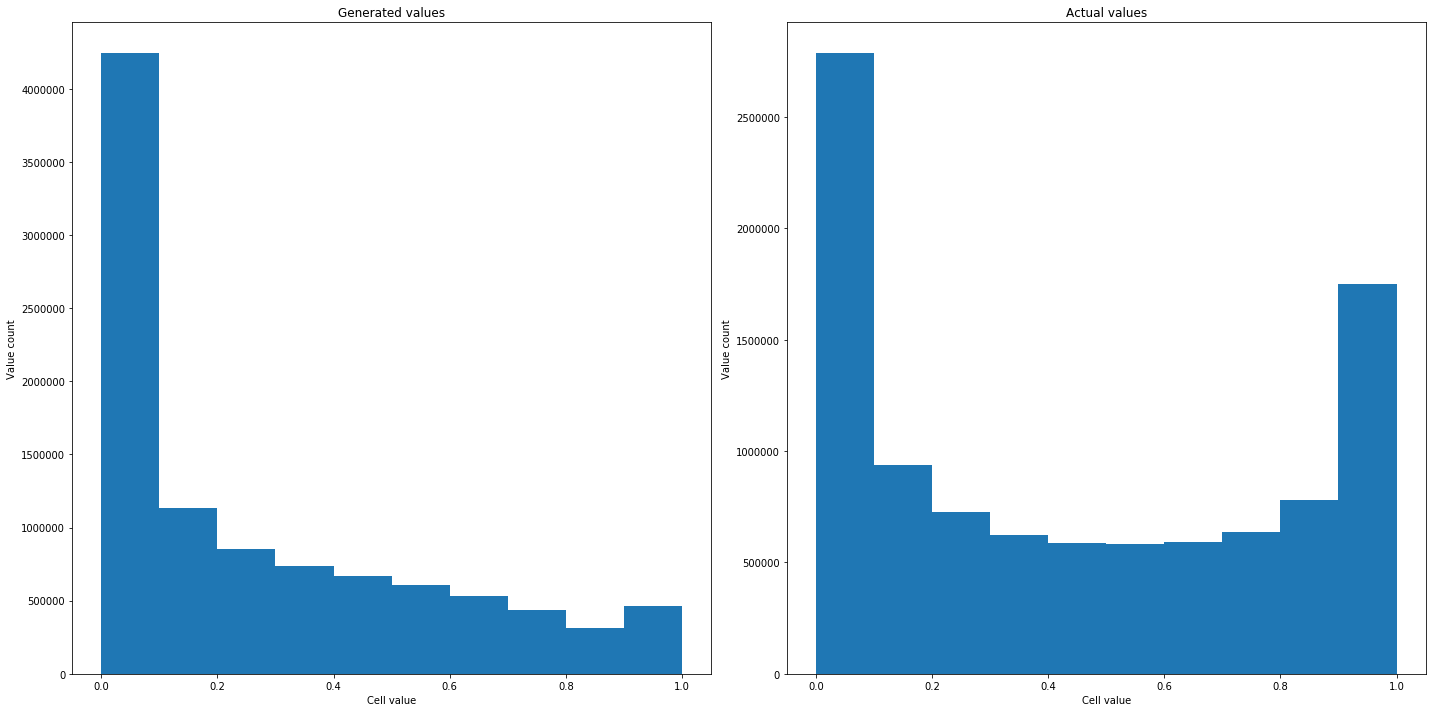

In [20]:
test_saved_autoencoder(2, 3000, 64, 'adadelta', plot_value_histograms=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01209884349791786
Zeros average:
0.025001878312509572
Ones average:
0.08664629271035935
Spearman base: 0.8669273004704494
MAE 0.41855796119292815
Spearman rescaled: 0.8670450768449294
MAE rescaled 0.19177853657887708


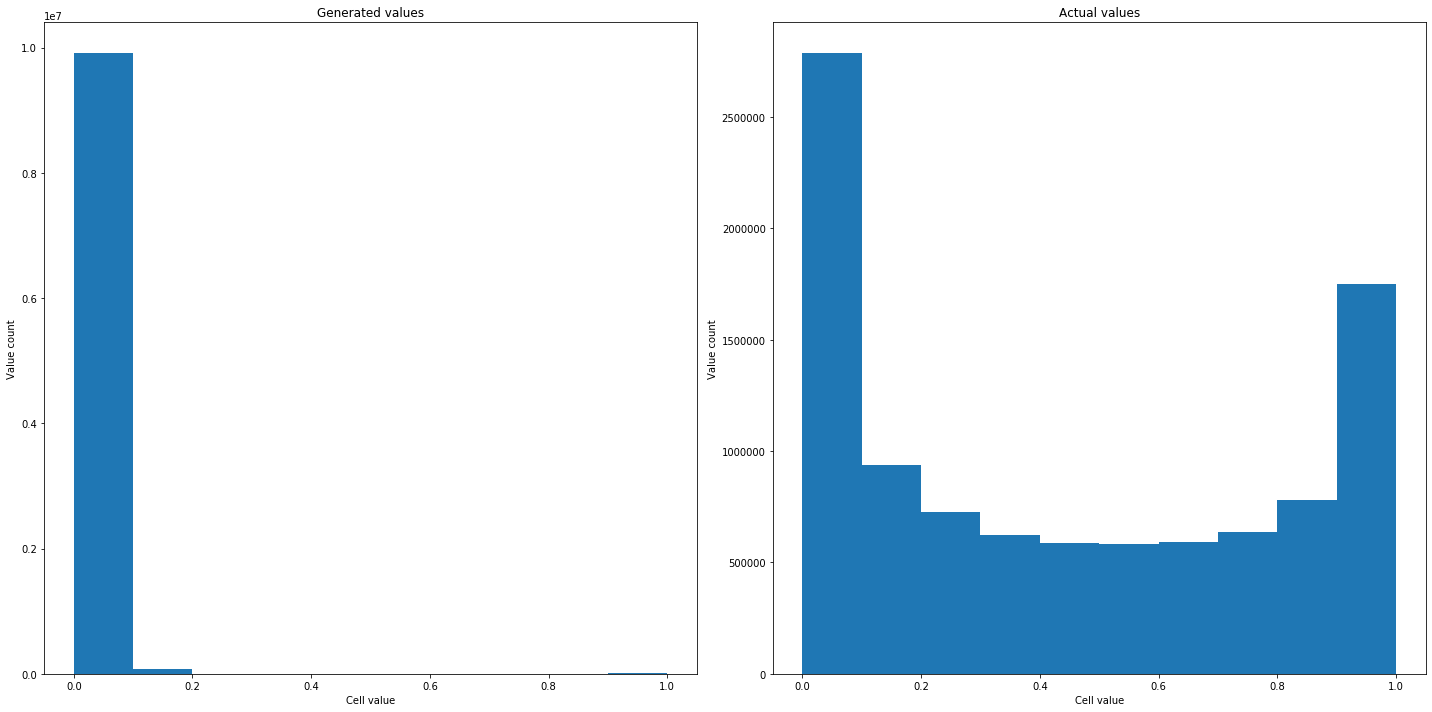

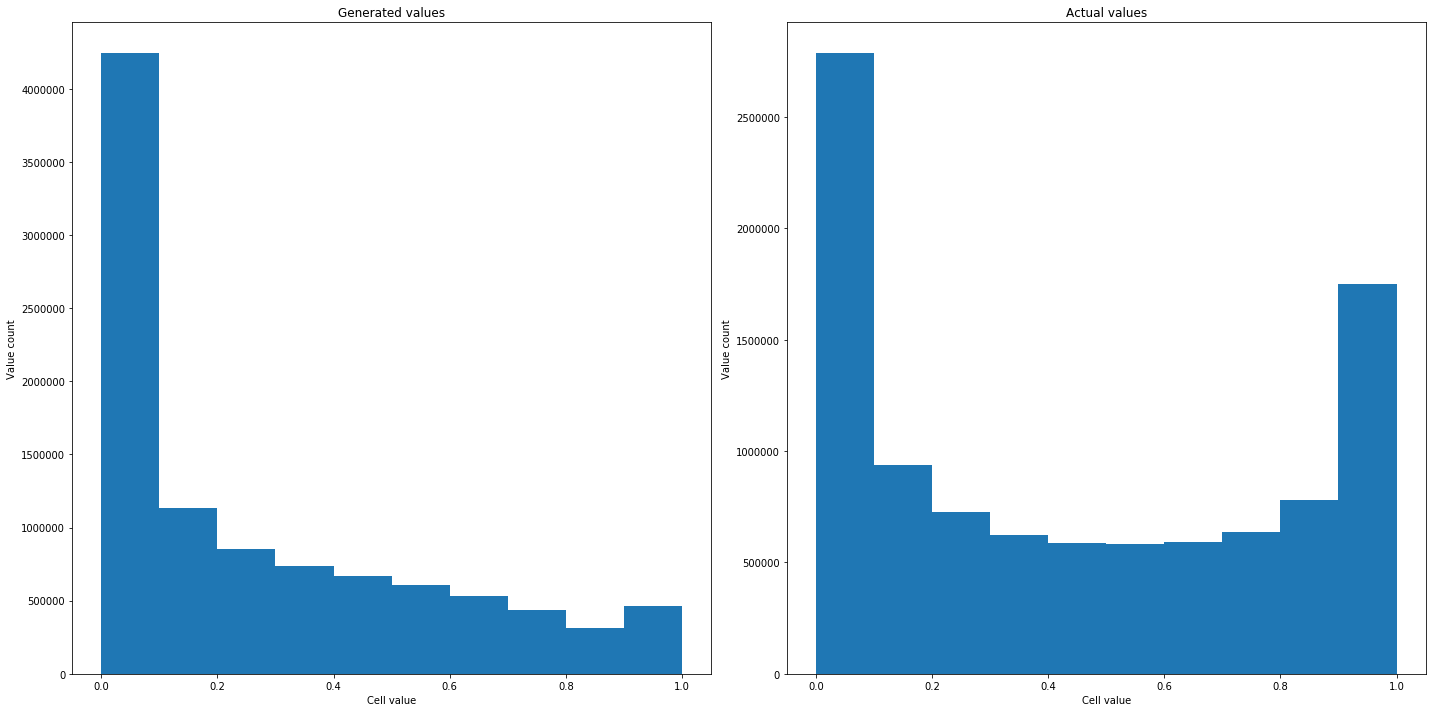

In [21]:
test_saved_autoencoder(2, 3000, 64, 'adadelta', plot_value_histograms=True)

In [188]:
#test_saved_autoencoder(2, 3000, 64, 'adadelta')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                32000     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01209884349791786
Spearman base: 0.8669273004704494
MAE 0.41855796119292815
Spearman rescaled: 0.8669273004704494
MAE rescaled 0.2379818089480197
Compare result to true: v3_inner_2_batch_64_epochs_3000_optimizer_adade

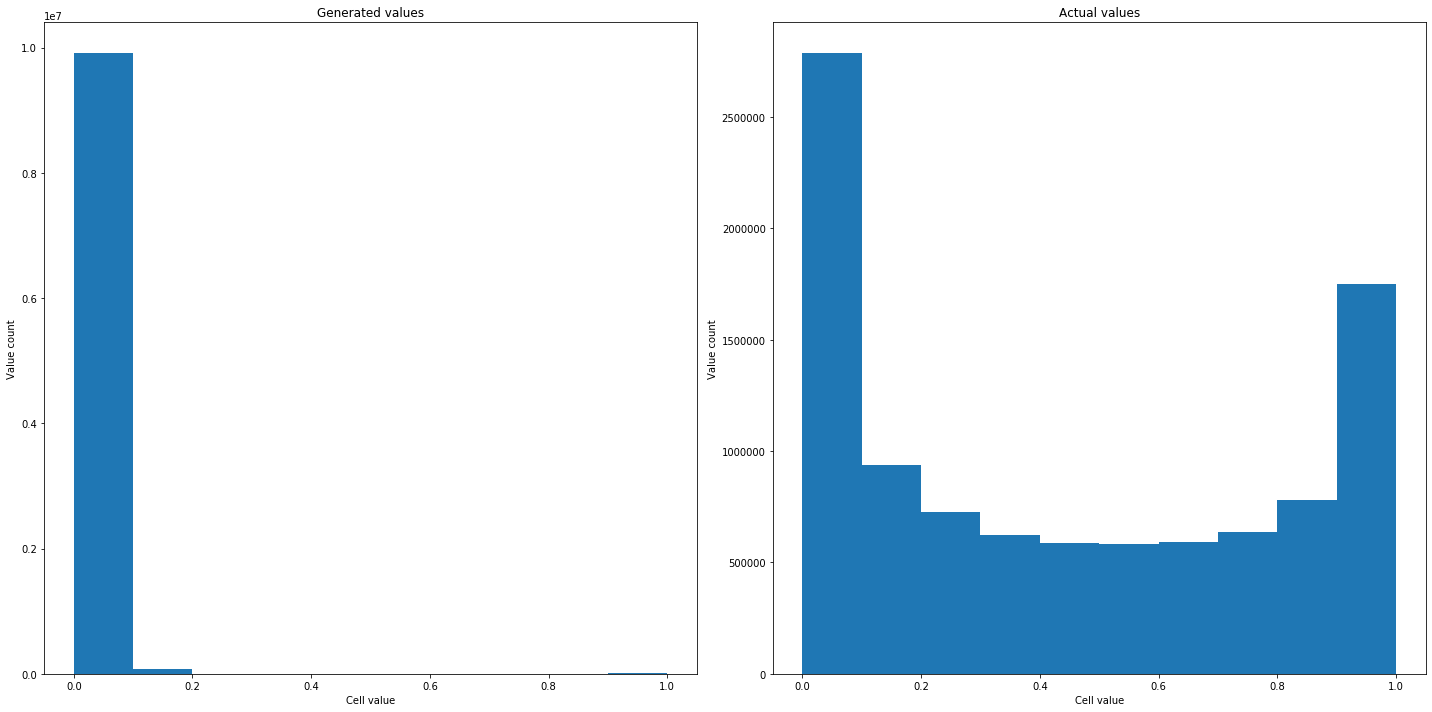

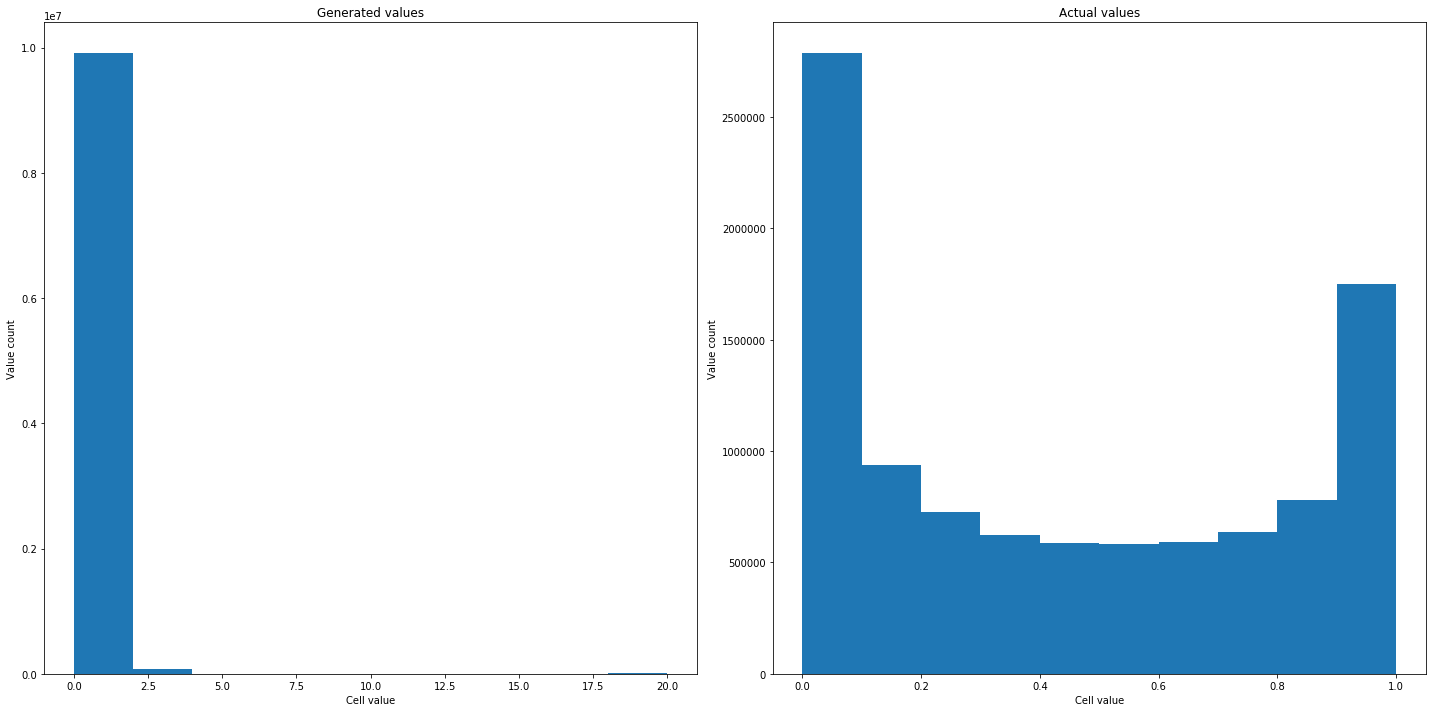

In [189]:
test_saved_autoencoder(2, 3000, 64, 'adadelta', plot_value_histograms=True)

In [145]:
#create_and_compile_autoencoder_RELU_optimizer(2, 3000, 32, 'adadelta')

In [45]:
input_dim = simulated_samples.shape[1]

def create_histograms(generated, actual_values):
    titles = 'All predicted mistakes'
    data = [generated, actual_values]
    titles = ['Generated values', 'Actual values']
    
    rescale_by = [2, 5, 10, 15, 20]
    rescaled_generated_values = []
    for rescale_val in rescale_by:
        rescaled_values = []
        for val in generated:
            new_val = 1 if val*rescale_val > 1 else val*rescale_val
            rescaled_values.append(new_val)
        rescaled_generated_values.append(rescaled_values)

    print('Spearman base: {0}'.format(scipy.stats.spearmanr(generated, actual_values).correlation))
    print('Pearson: {0}'.format(scipy.stats.pearsonr(generated, actual_values)))
    print('MAE {}'.format(mean_absolute_error(generated, actual_values)))
    f, a = plt.subplots(1, 2, figsize=(20, 10))
    a = a.ravel()
    for idx, ax in enumerate(a):
        ax.hist(data[idx])
        ax.set_title(titles[idx])
        ax.set_xlabel('Cell value')
        ax.set_ylabel('Value count')
    plt.tight_layout()
    
    for rescale in rescaled_generated_values:
        data_rescaled = [rescale, actual_values]
        print('Spearman rescaled: {0}'.format(scipy.stats.spearmanr(rescale, actual_values).correlation))
        print('MAE rescaled {}'.format(mean_absolute_error(rescale, actual_values)))
        f, a = plt.subplots(1, 2, figsize=(20, 10))
        a = a.ravel()
        for idx, ax in enumerate(a):
            ax.hist(data_rescaled[idx])
            ax.set_title(titles[idx])
            ax.set_xlabel('Cell value')
            ax.set_ylabel('Value count')
        plt.tight_layout()

def create_model_name(encoding_dim, batch_size, nb_epoch, optimizer_algo, matrix_file_name):
    return 'autoencoder_models/v3_inner_{}_batch_{}_epochs_{}_optimizer_{}_matrix_{}.h5'.format(encoding_dim, batch_size, nb_epoch, optimizer_algo, matrix_file_name)

def create_and_compile_autoencoder_RELU_optimizer_different_matrix(encoding_dim, nb_epoch, batch_size, optimizer_algo, simulation_name, input_data):
    autoencoder = Sequential()
    autoencoder.add(Dense(32, activation="relu", input_shape=(input_dim,), use_bias = False))
    autoencoder.add(Dense(encoding_dim, activation='linear', use_bias = False))
    autoencoder.add(Dense(32, activation="relu", use_bias = False))
    autoencoder.add(Dense(input_dim, activation="sigmoid", use_bias = False))

    autoencoder.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer=optimizer_algo)
    
    history = autoencoder.fit(input_data, input_data,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)
    
    plt.figure(figsize=(15,10))
    plt.plot(history.history['loss'][1000:3000], label='train')
    plt.legend()
    plt.show()
    
    autoencoder.save(create_model_name(encoding_dim, batch_size, nb_epoch, optimizer_algo, simulation_name))
    
from keras.models import load_model
def test_saved_autoencoder_different_matrix(encoding_dim, nb_epoch, batch_size, optimizer_algo, simulation_name, input_data, general_info=False, plot_value_histograms=False, scatter_plot_real_and_generated=False):
    autoencoder = load_model(create_model_name(encoding_dim, batch_size, nb_epoch, optimizer_algo, simulation_name))
    autoencoder.summary()
    
    train_predictions = autoencoder.predict(input_data)
    print('Train reconstrunction error\n', sklearn.metrics.mean_squared_error(input_data, train_predictions))
    
    result_flattened = normalize(train_predictions.flatten())
    true_flattened = true_suitability.flatten()
    
    if general_info:
        print_general_info(result_flattened, true_flattened)
    if plot_value_histograms:
        create_histograms(result_flattened, true_flattened)
    if scatter_plot_real_and_generated:
        create_matrix_compare_plot_average(true_flattened, result_flattened, 'true matrix', 'generated matrix', 'Average generated value per true matrix value')
    
    compare_matrixes(result_flattened, true_flattened, 'Compare result to true: ' + create_model_name(encoding_dim, batch_size, nb_epoch, optimizer_algo, simulation_name))
    
    zero_result_flattened = normalize(np.array(train_predictions)[np.where(input_data==0)])
    zero_true_flattened = np.array(true_suitability)[np.where(input_data==0)]
    compare_matrixes(zero_result_flattened, zero_true_flattened, 'Compare (zeros) result to true: ' + create_model_name(encoding_dim, batch_size, nb_epoch, optimizer_algo, simulation_name))
    
def create_model_save_and_test(matrix_name):
    data = np.loadtxt('matrixes/{}.txt'.format(matrix_name), dtype="int", skiprows=1, usecols=range(1, 1001))
    create_and_compile_autoencoder_RELU_optimizer_different_matrix(2, 3000, 64, 'adadelta', matrix_name, data)
    test_saved_autoencoder_different_matrix(2, 3000, 64, 'adadelta', matrix_name, data, plot_value_histograms=True)

In [46]:
# shuffling 
import random

datato_shuffle = np.loadtxt('matrixes/{}.txt'.format('rep.50'), dtype="int", skiprows=1, usecols=range(1, 1001))
shuffled_observations = np.random.permutation(datato_shuffle)

print(shuffled_observations[0][:100])
for site in shuffled_observations:
    np.random.shuffle(site)
print(shuffled_observations[0][:100])
np.random.shuffle(shuffled_observations)
print(shuffled_observations[0][:100])

print(shuffled_observations.shape)
test_saved_autoencoder_different_matrix(2, 3000, 64, 'adadelta', 'shuffled_rep_50', shuffled_observations, plot_value_histograms=True)

NameError: name 'datato_shuffle' is not defined

In [32]:
from datetime import datetime
import time

now1 = datetime.now()
current_time1 = now1.strftime("%H:%M:%S")
print("Current Time =", current_time1)
time.sleep(6)
now2 = datetime.now()
current_time2 = now2.strftime("%H:%M:%S")
print("Current Time =", current_time2)

print((now2 - now1).total_seconds() / 60)

Current Time = 09:45:38
Current Time = 09:45:44
0.10000423333333333


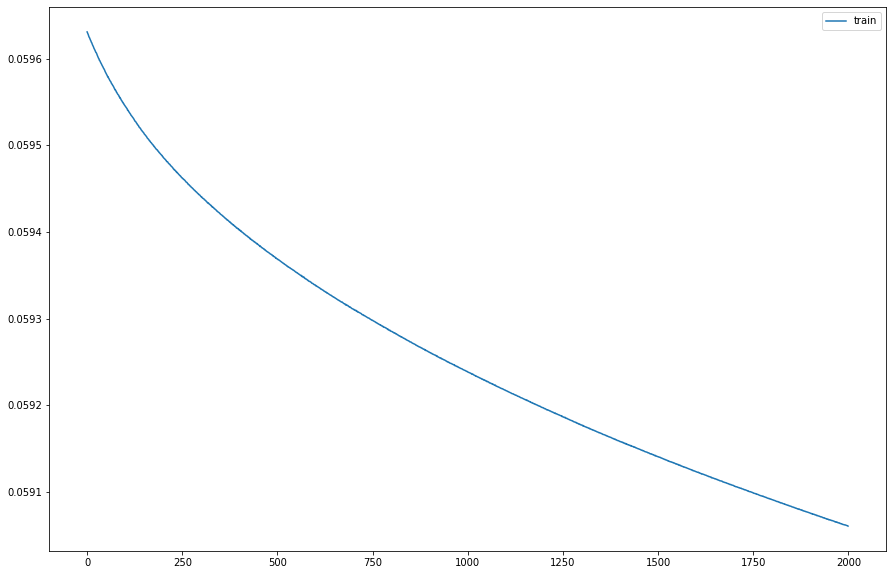

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_19 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012121689430138282
Spearman base: 0.8620712460342657
MAE 0.41859345762984346
Spearman rescaled: 0.8620712560802818
MAE rescaled 0.39445992017576437
Spearman rescaled: 0.8620716608007709
MAE rescaled 0.3229135738936896

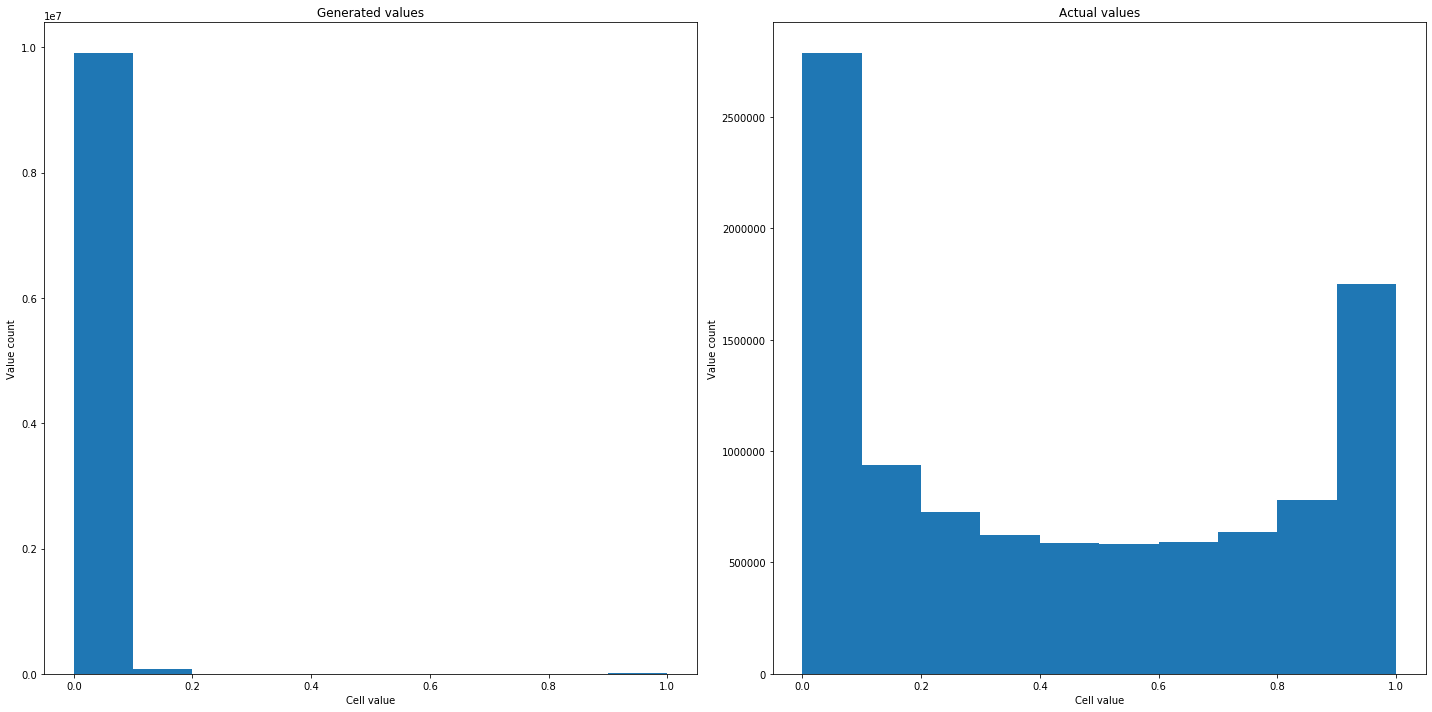

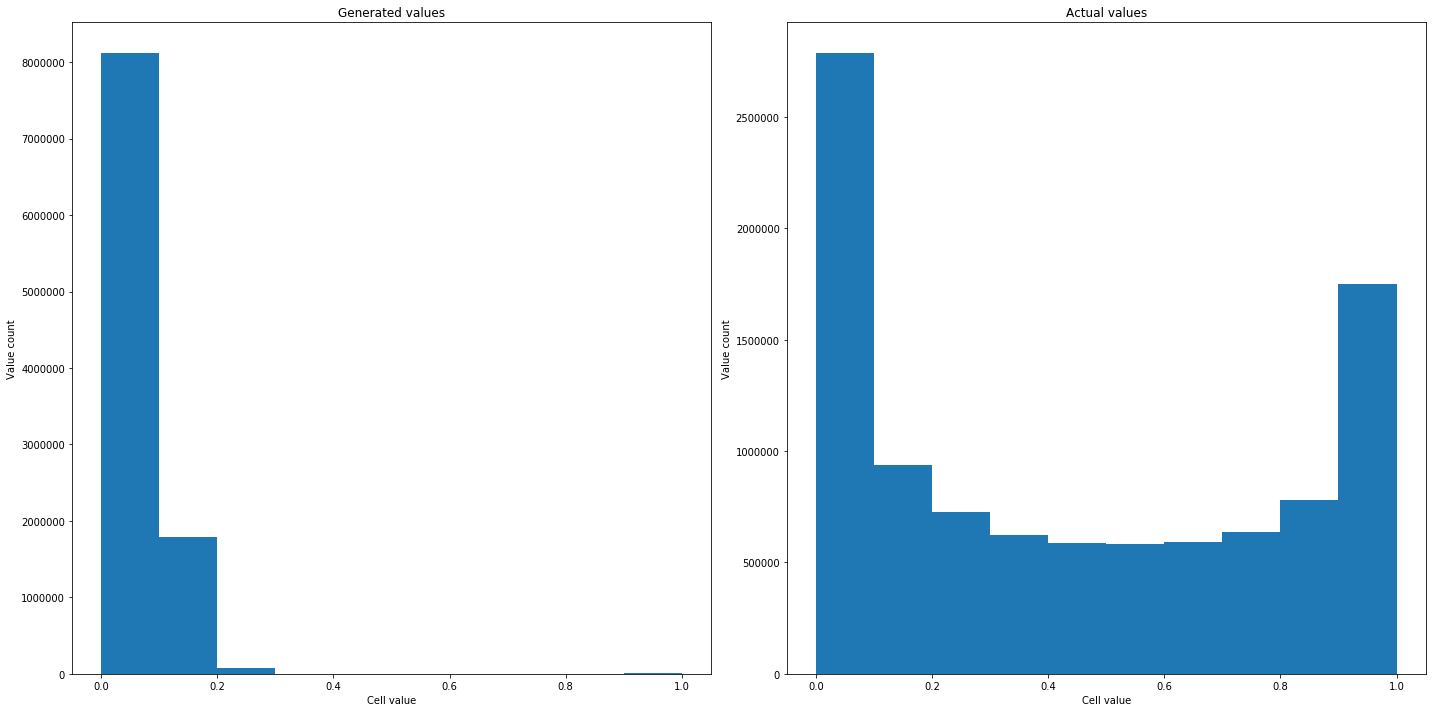

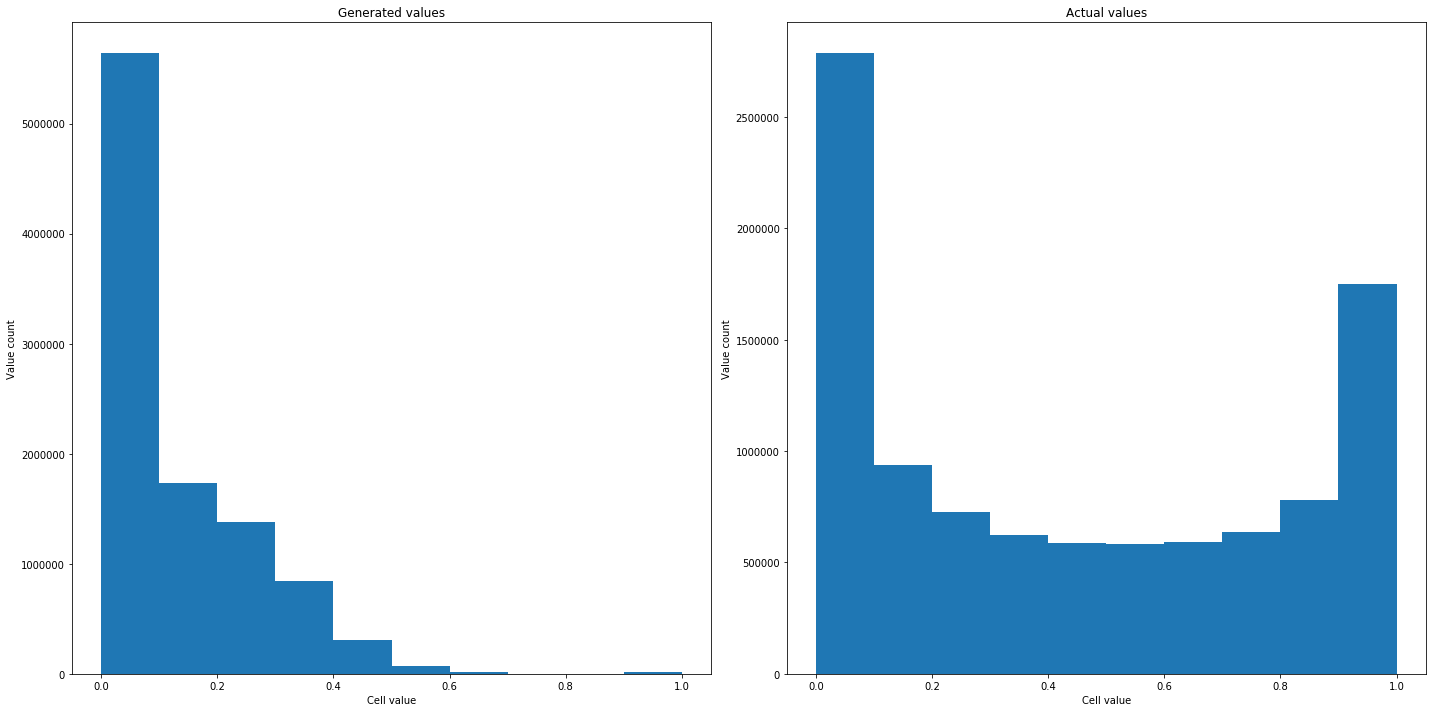

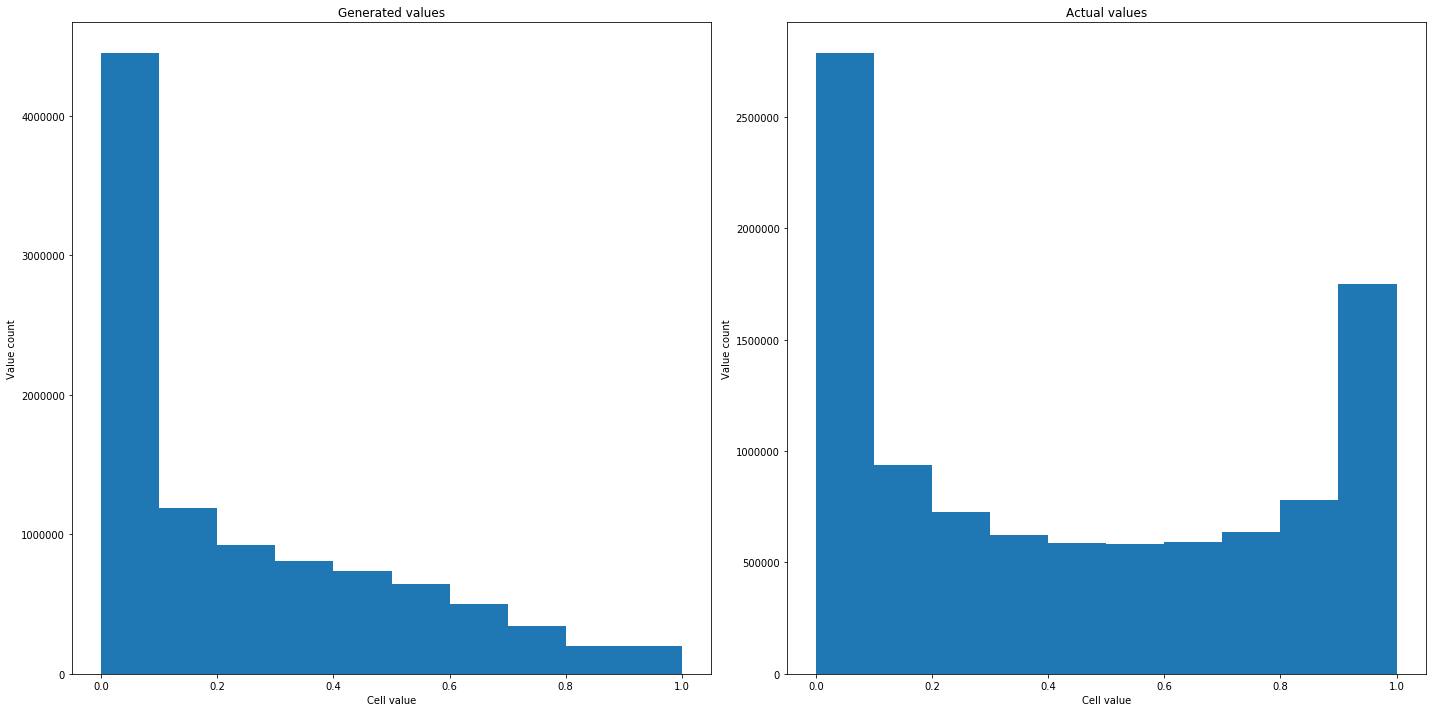

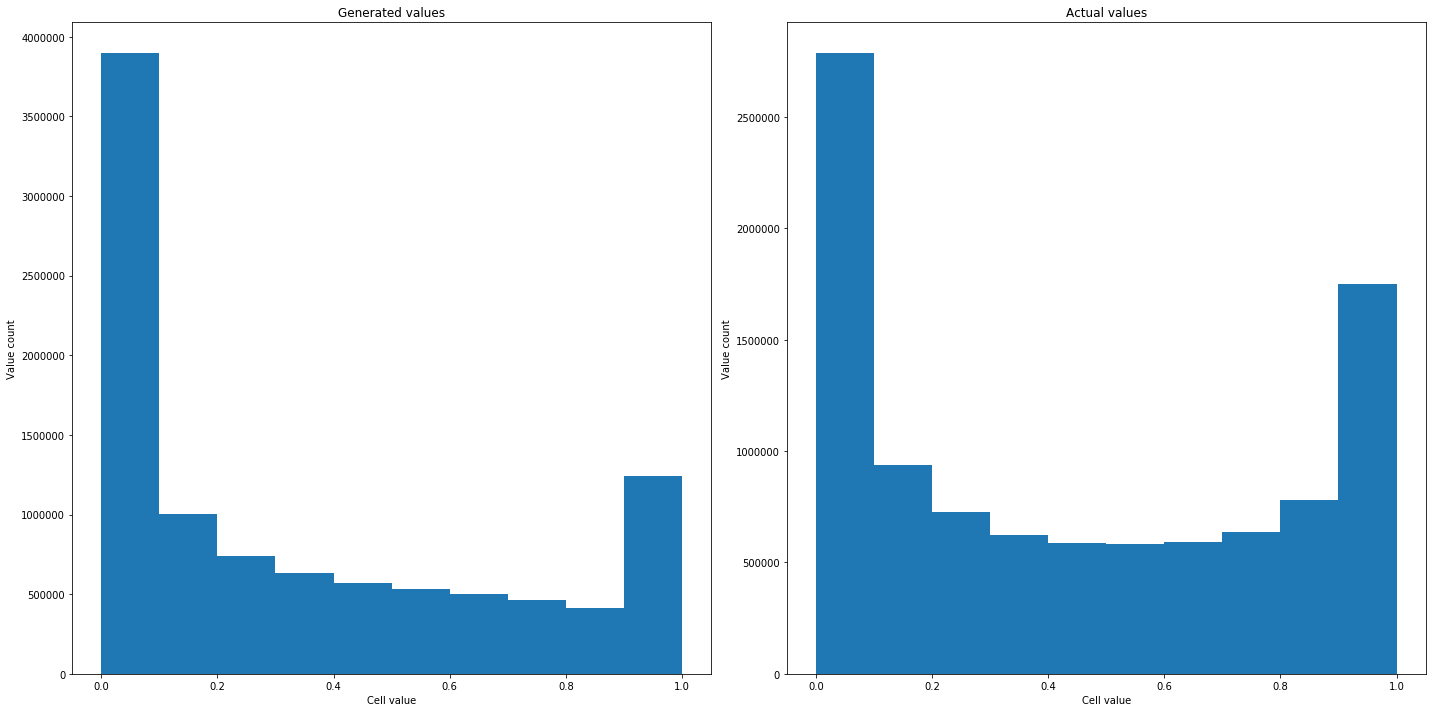

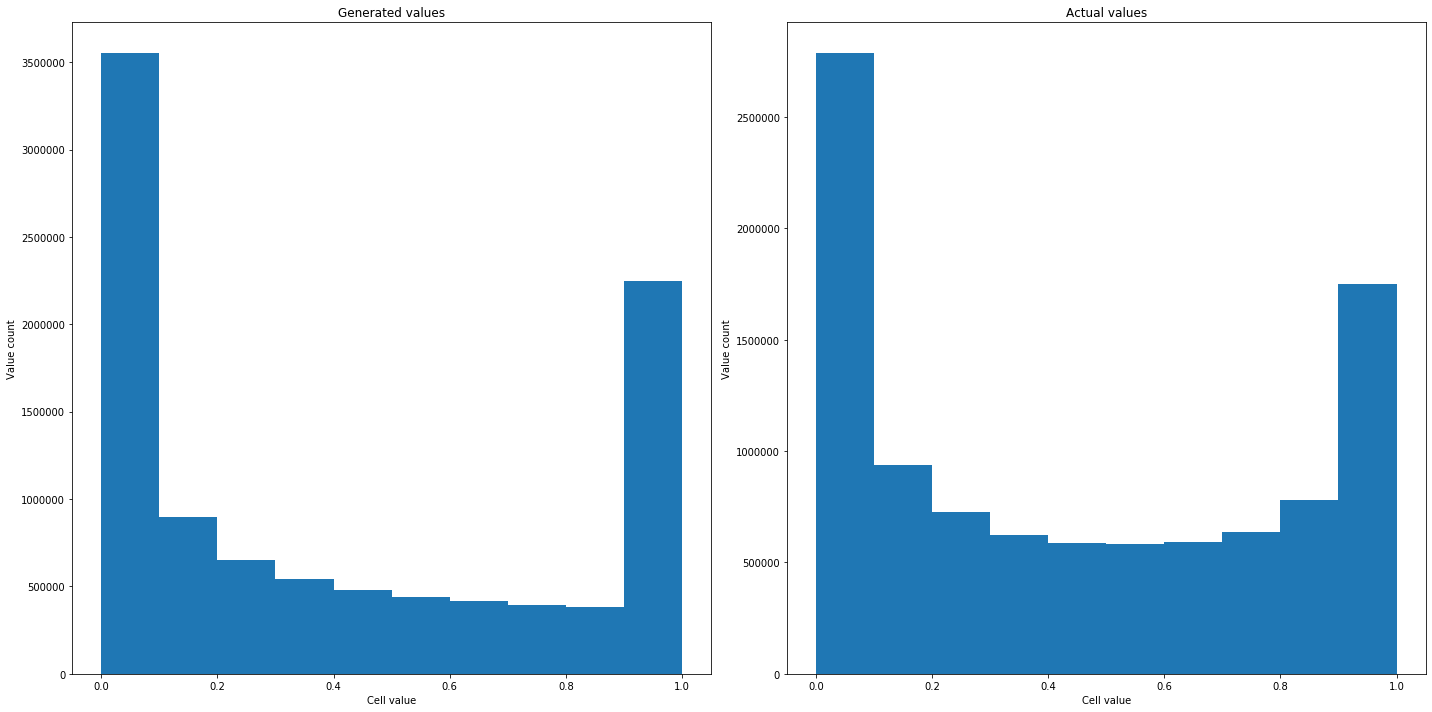

In [33]:
create_model_save_and_test('rep.1')

In [34]:
datato_shuffle = np.loadtxt('matrixes/{}.txt'.format('rep.50'), dtype="int", skiprows=1, usecols=range(1, 1001))
test_saved_autoencoder_different_matrix(2, 3000, 64, 'adadelta', 'rep.50', data, plot_value_histograms=True)

NameError: name 'matrix_name' is not defined

In [ ]:
import random

shuffled_observations = np.random.permutation(datato_shuffle)

print(shuffled_observations[0][:100])
for site in shuffled_observations:
    np.random.shuffle(site)
print(shuffled_observations[0][:100])
np.random.shuffle(shuffled_observations)
print(shuffled_observations[0][:100])

print(shuffled_observations.shape)



In [ ]:
create_and_compile_autoencoder_RELU_optimizer_different_matrix(2, 3000, 64, 'adadelta', 'shuffled_rep_50', shuffled_observations)
test_saved_autoencoder_different_matrix(2, 3000, 64, 'adadelta', 'shuffled_rep_50', shuffled_observations, plot_value_histograms=True)

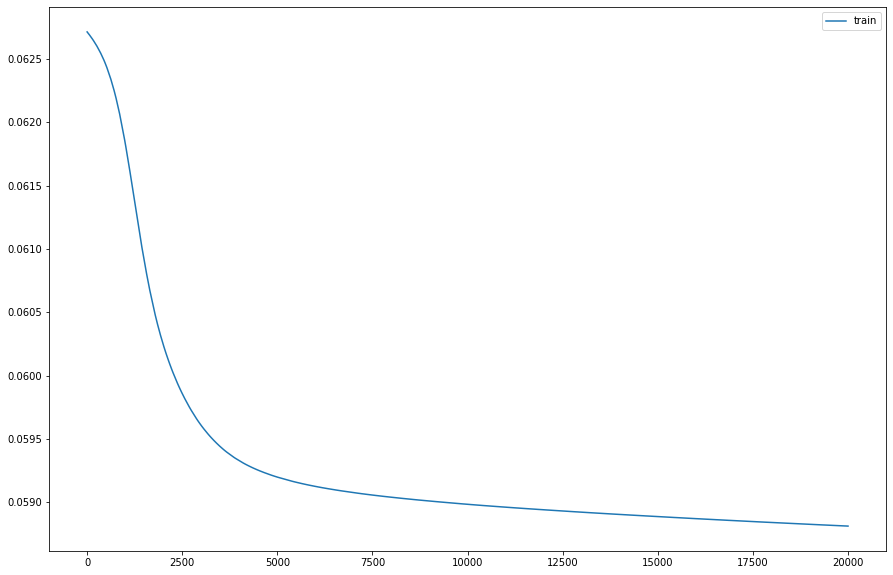

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 32)                32000     
_________________________________________________________________
dense_146 (Dense)            (None, 2)                 64        
_________________________________________________________________
dense_147 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_148 (Dense)            (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.011994376429976712
Spearman base: 0.8625617893752449
MAE 0.41925161054884247
Spearman rescaled: 0.862561792132306
MAE rescaled 0.39626302262970425
Spearman rescaled: 0.8625619839256742
MAE rescaled 0.3280667698217792

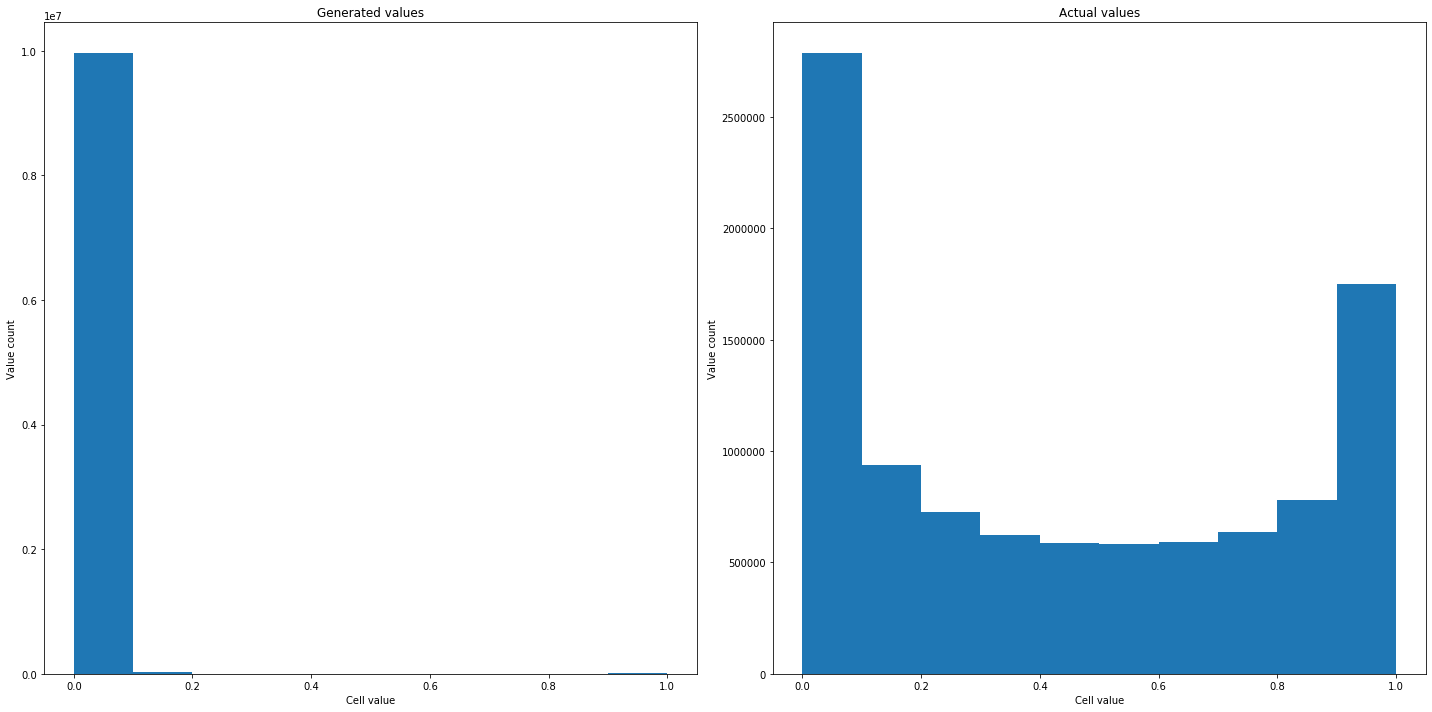

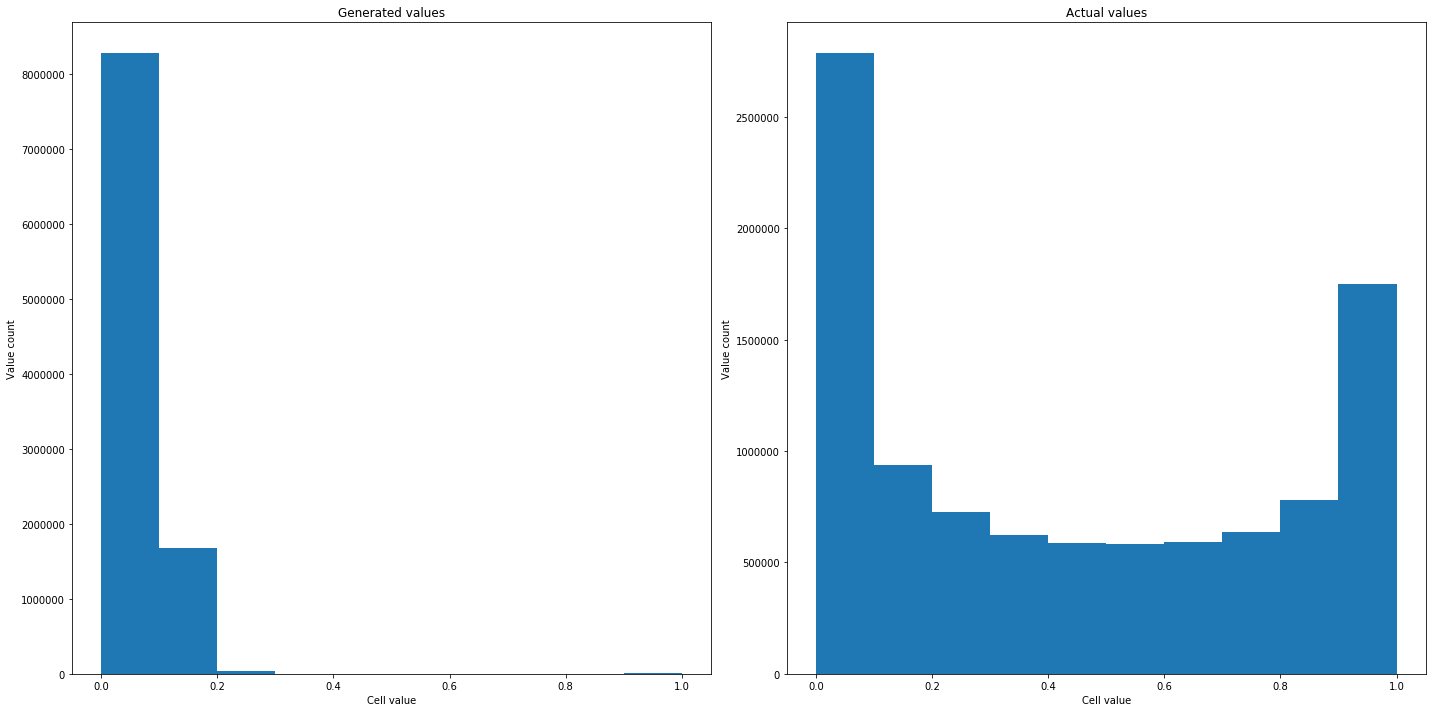

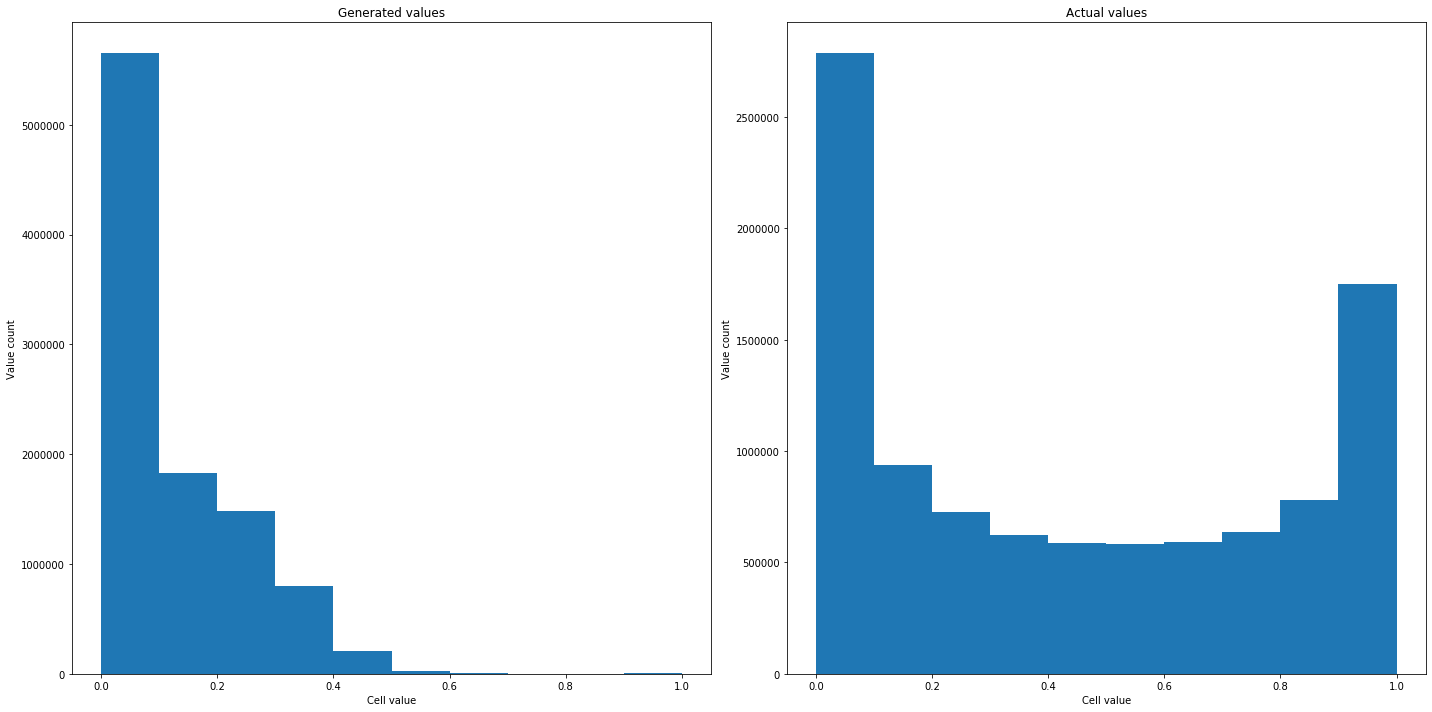

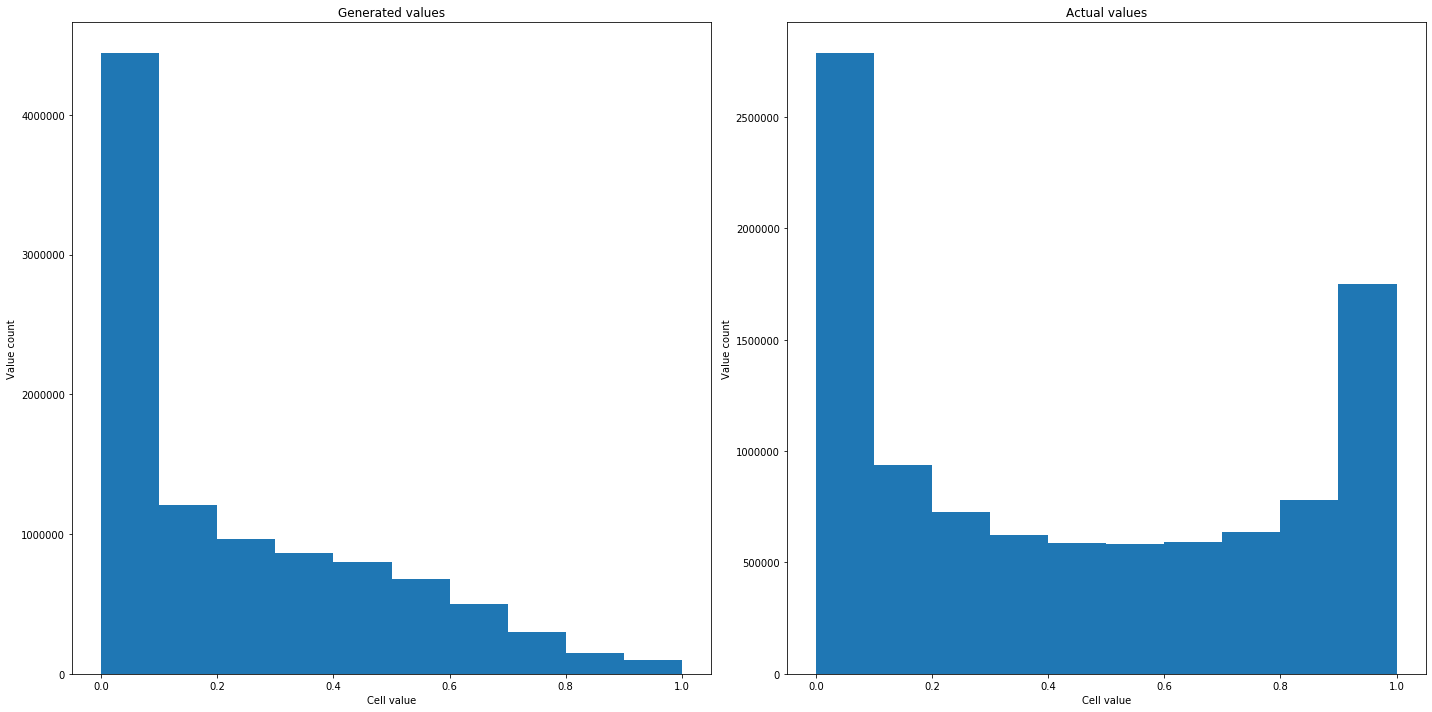

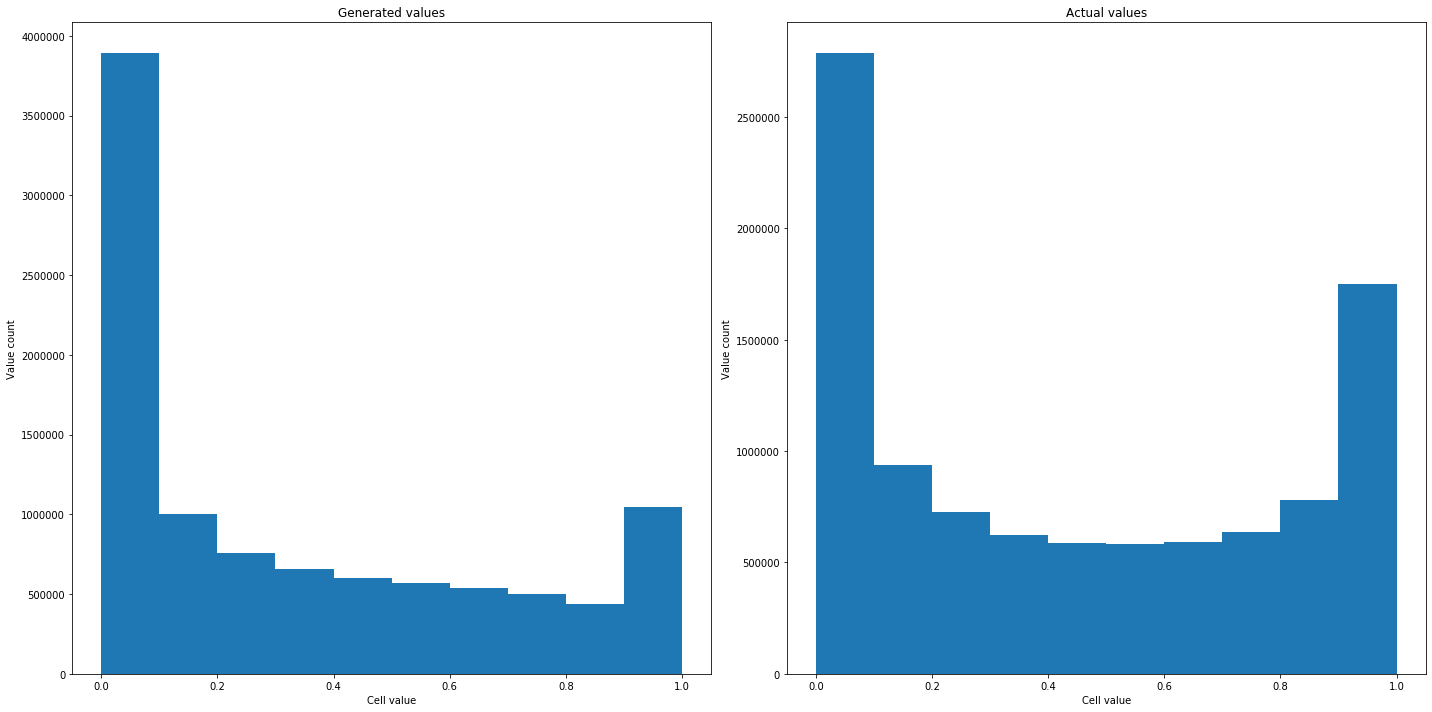

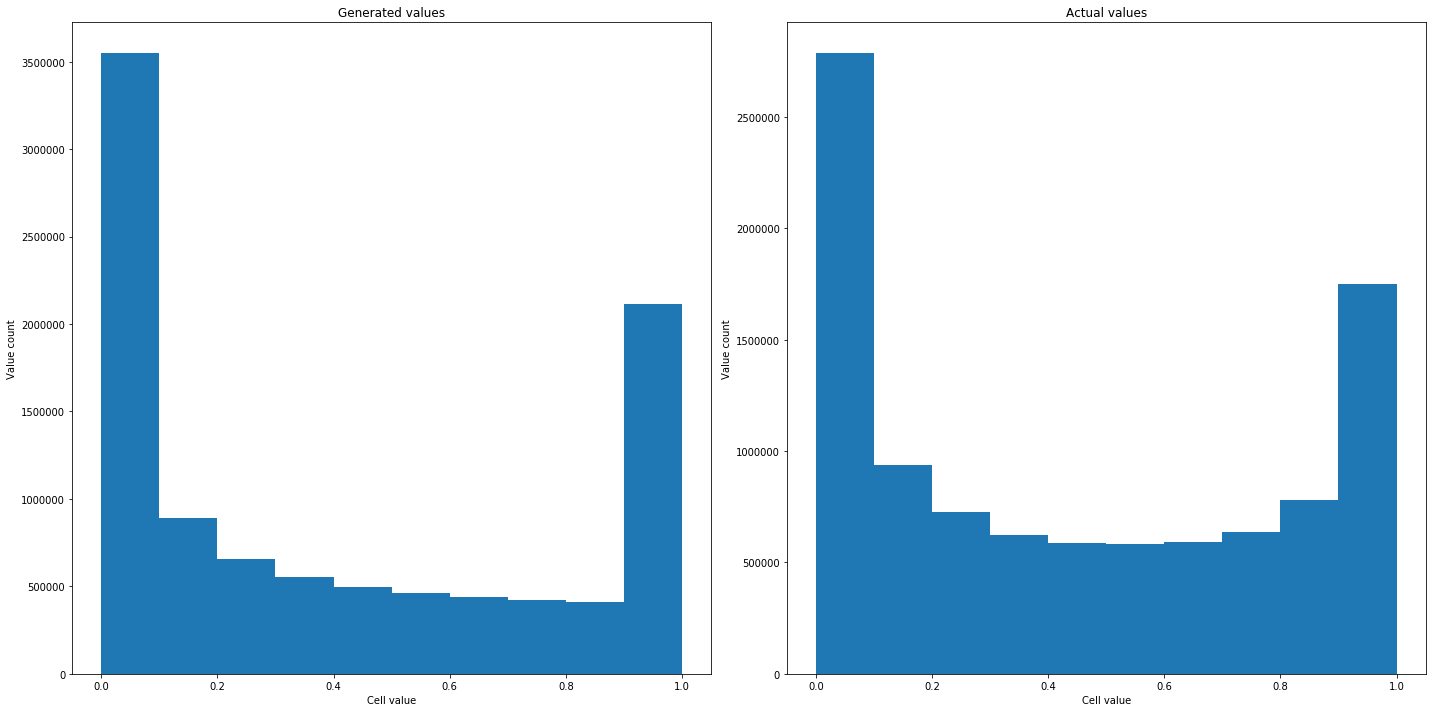

In [260]:
# 30000 - 1000
now1 = datetime.now()
create_model_save_and_test('rep.10')
now2 = datetime.now()
print('Time taken:')
print((now2 - now1).total_seconds() / 60)

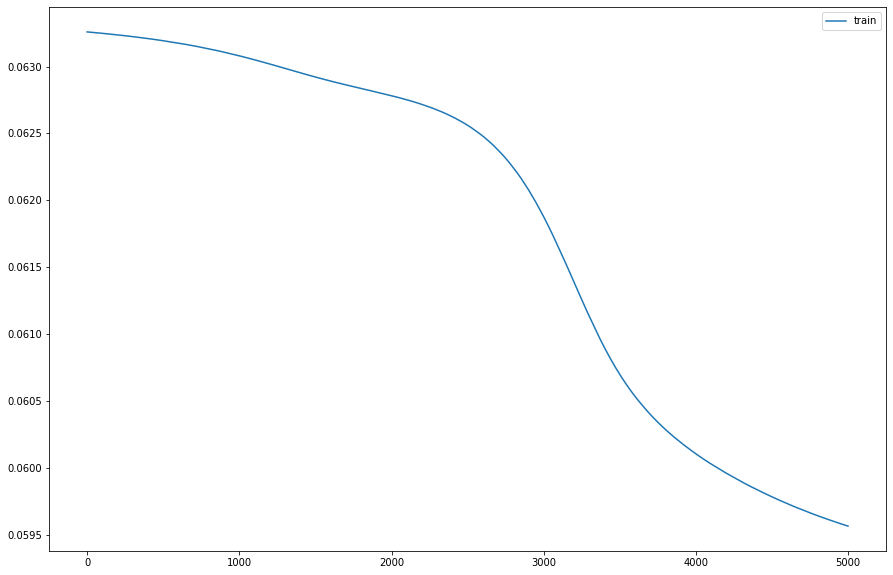

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 32)                32000     
_________________________________________________________________
dense_142 (Dense)            (None, 2)                 64        
_________________________________________________________________
dense_143 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_144 (Dense)            (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.012011806253908887
Spearman base: 0.8142085907023638
MAE 0.4185515284179041
Spearman rescaled: 0.8142085907023638
MAE rescaled 0.3950460876747114
Spearman rescaled: 0.8142086302151192
MAE rescaled 0.32683290612427124

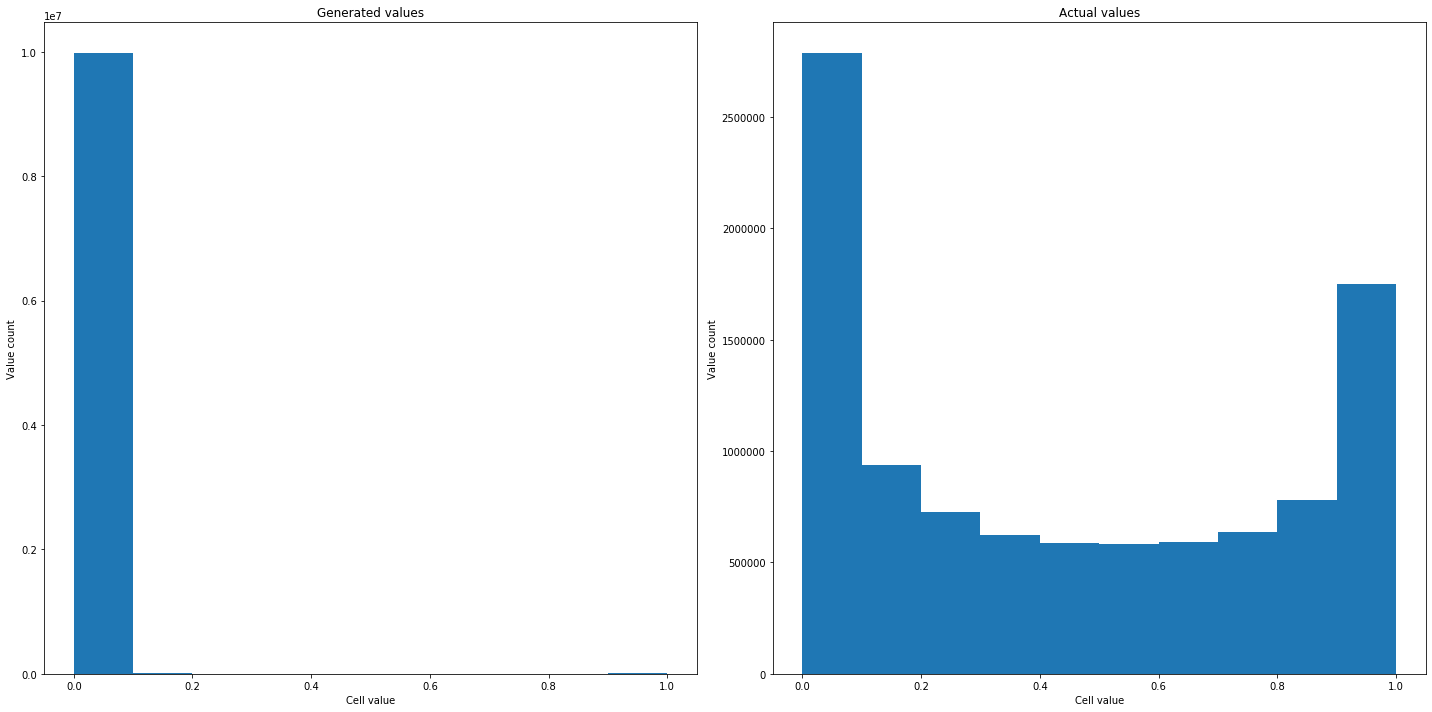

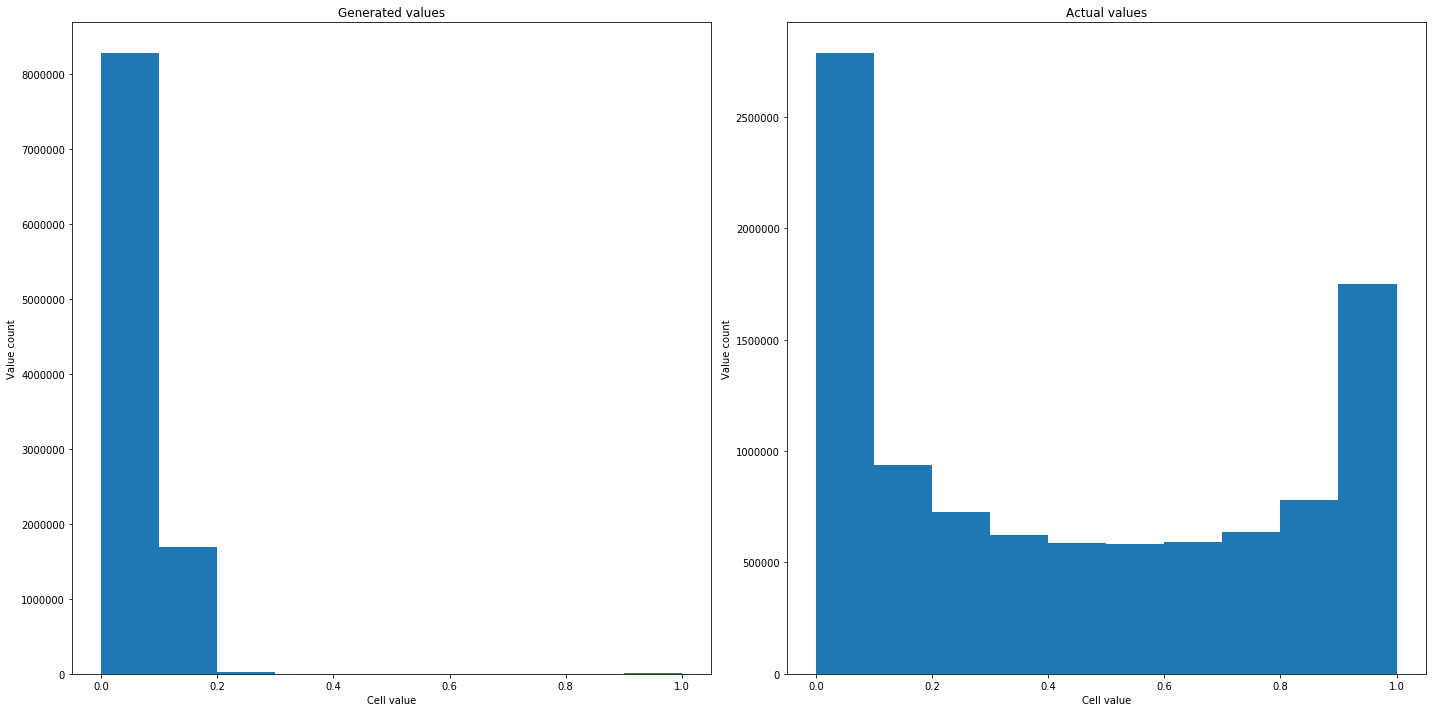

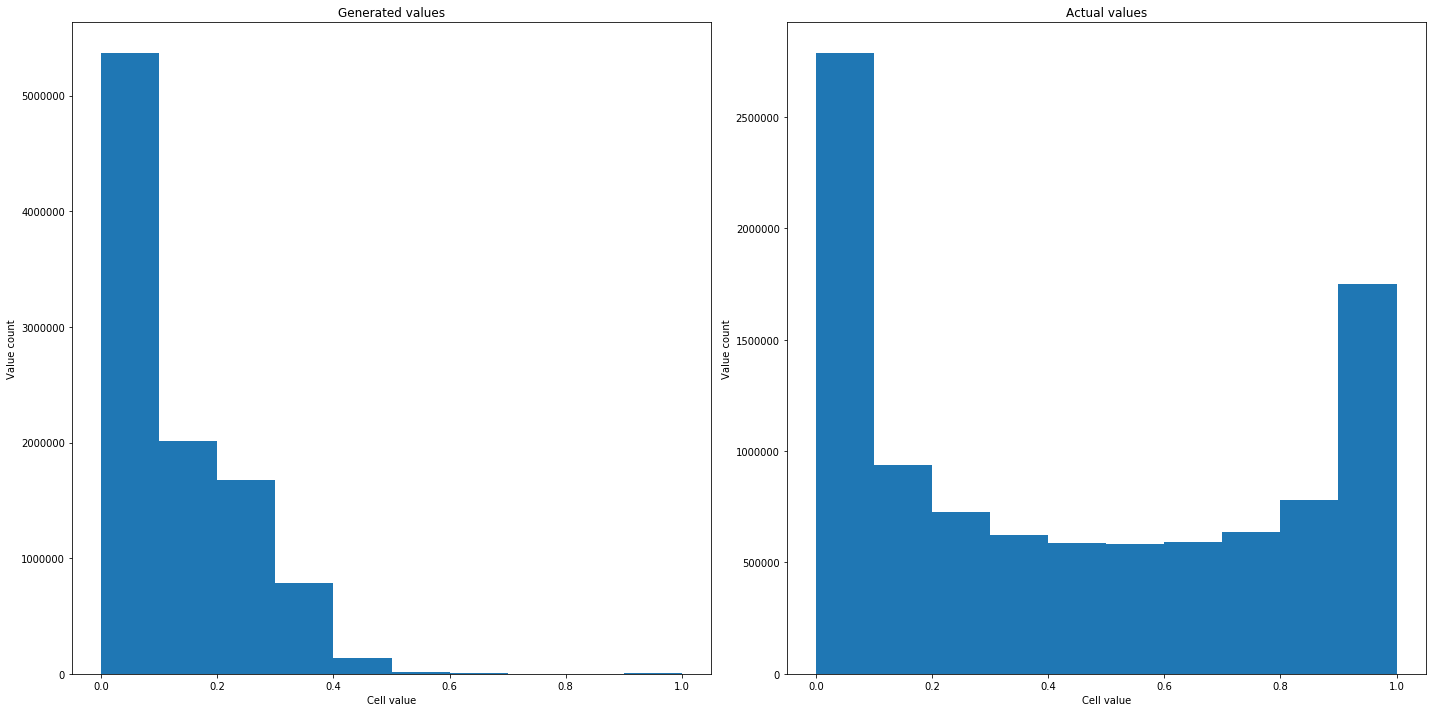

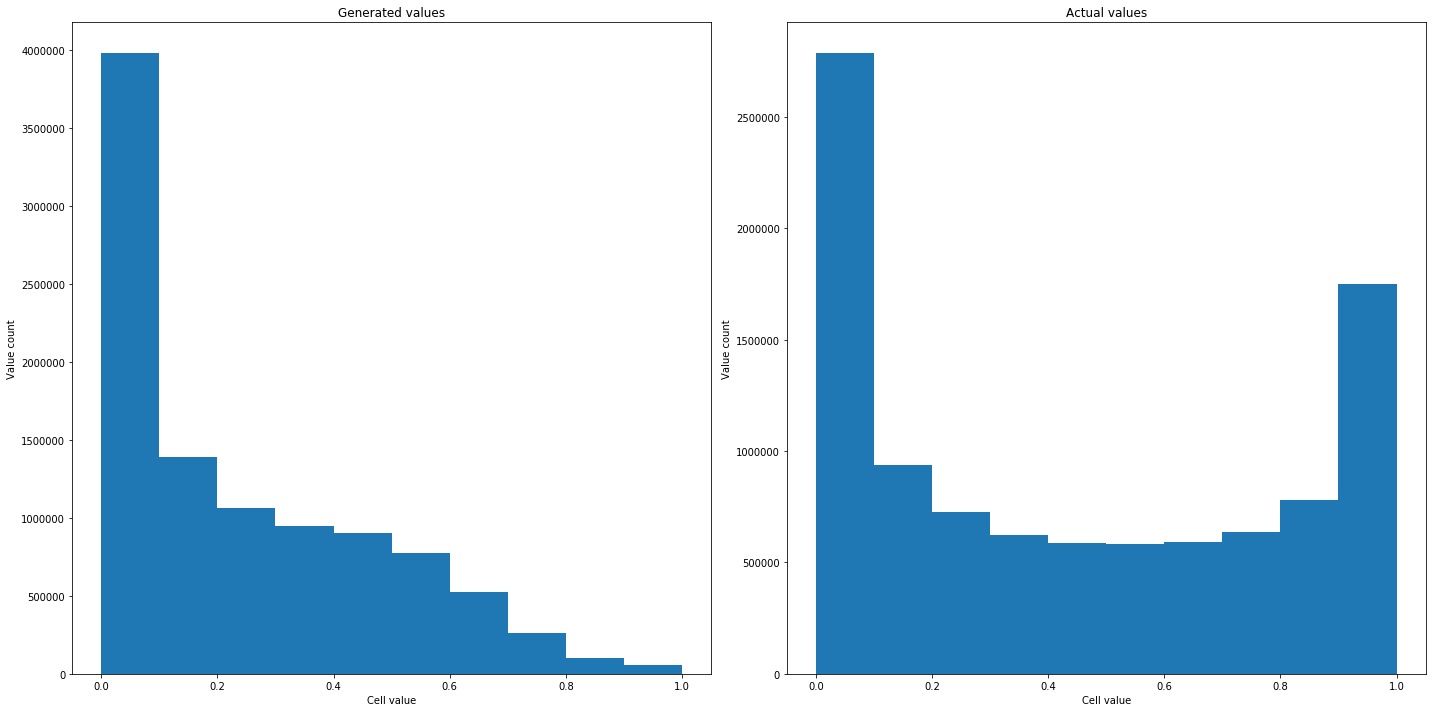

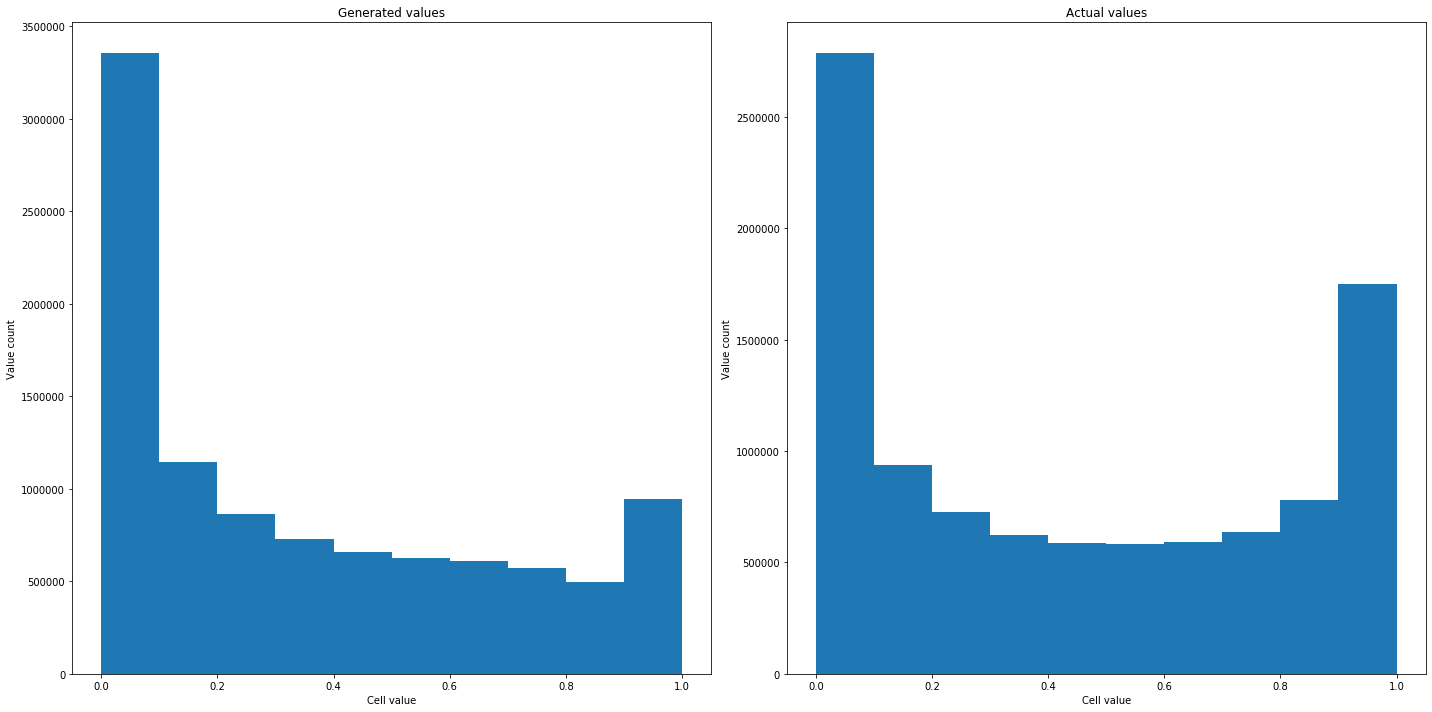

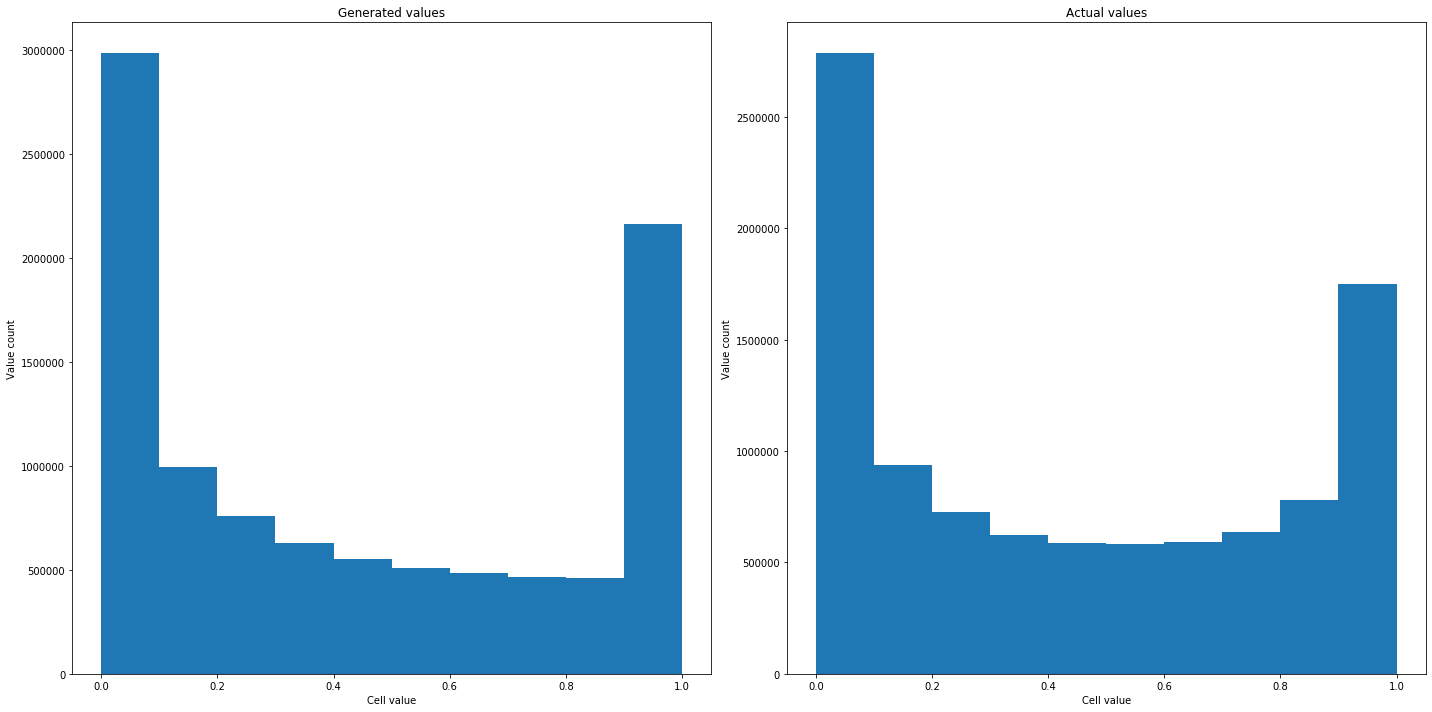

In [245]:
# 10000 - 1000
create_model_save_and_test('rep.10')

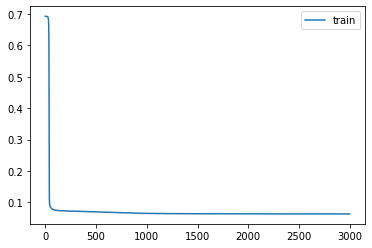

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 32)                32000     
_________________________________________________________________
dense_110 (Dense)            (None, 2)                 64        
_________________________________________________________________
dense_111 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_112 (Dense)            (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01209747413047813
Spearman base: 0.41947204381509623
MAE 0.42058633139437435
Spearman rescaled: 0.41947204381509623
MAE rescaled 0.40112491029227765
Spearman rescaled: 0.41947204381509623
MAE rescaled 0.3526449288849

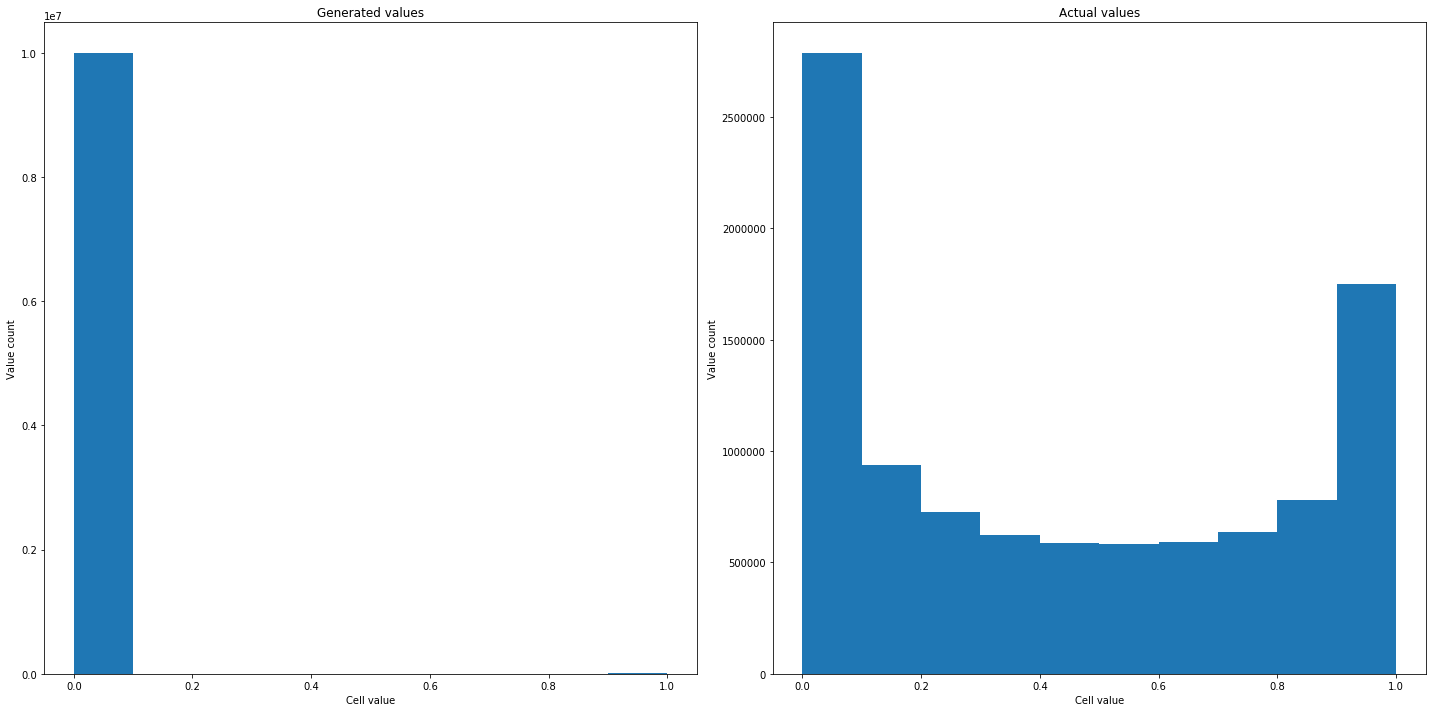

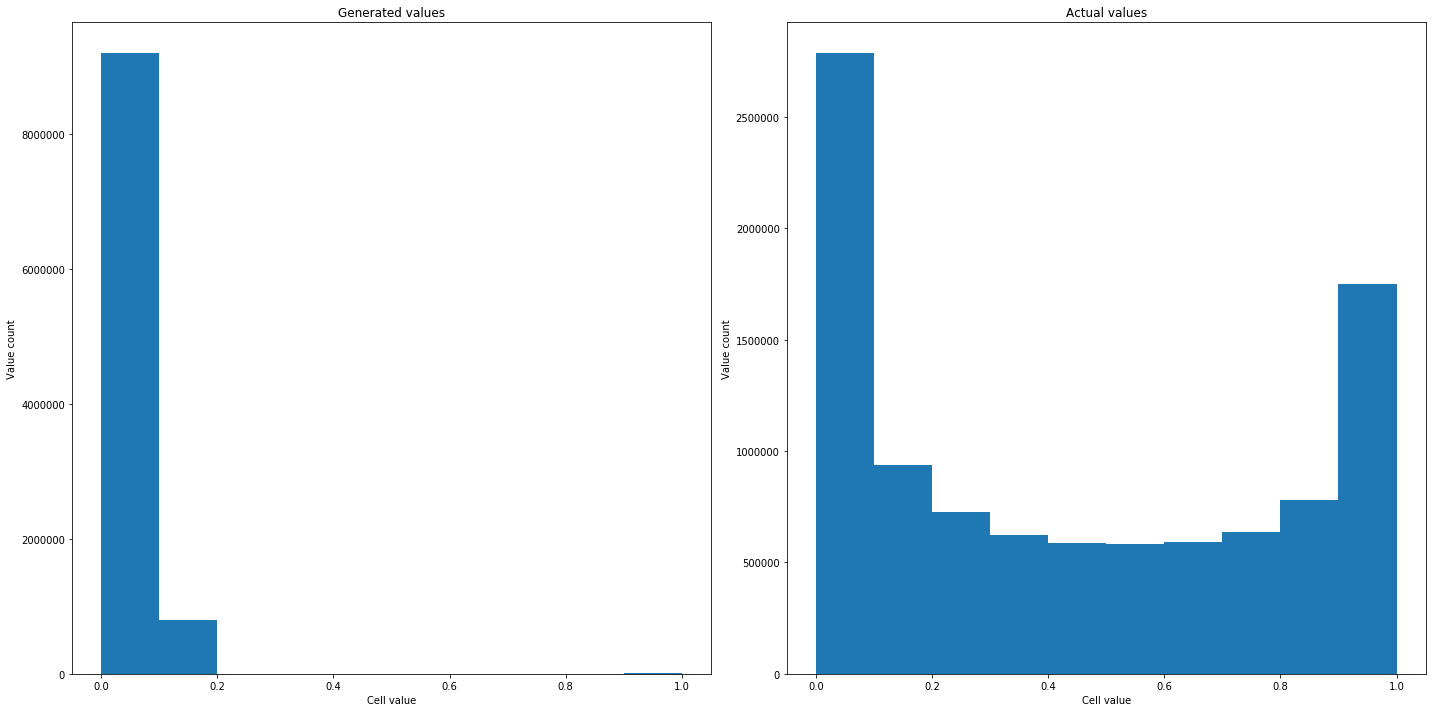

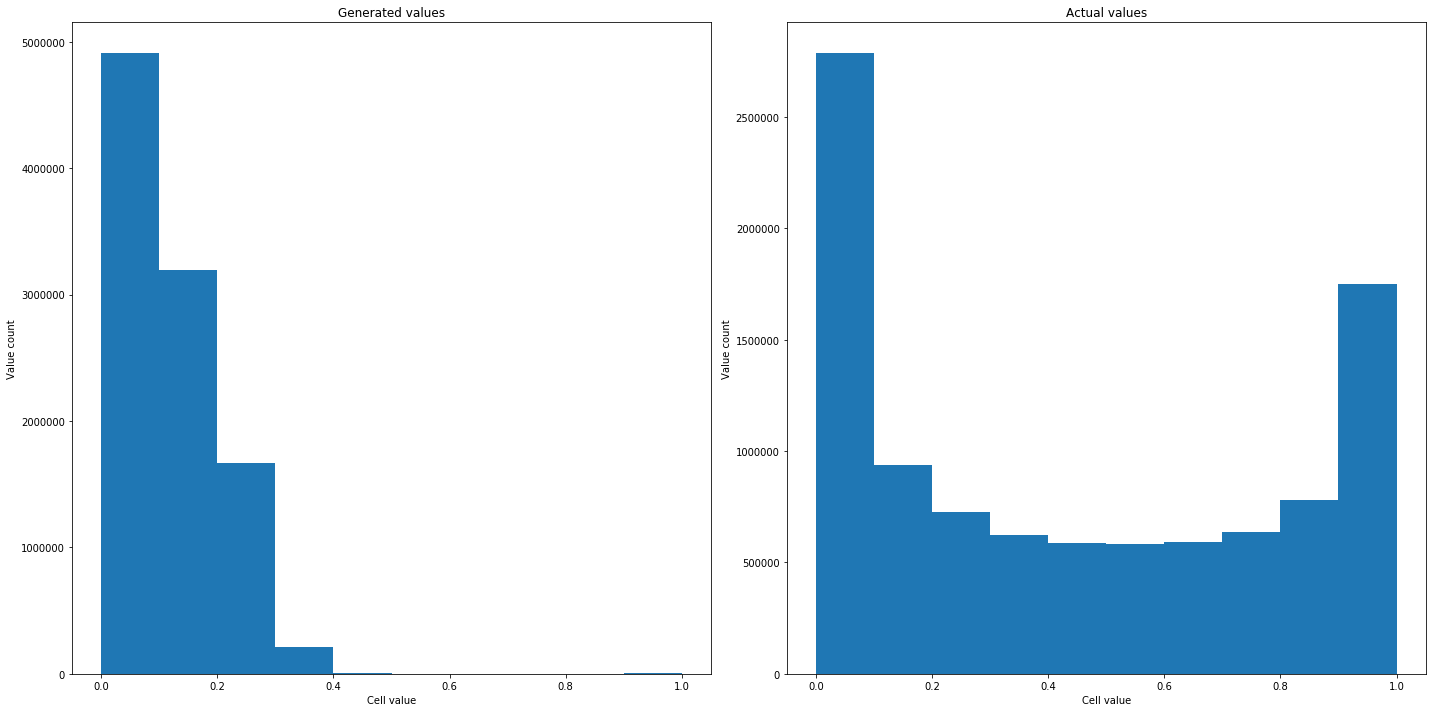

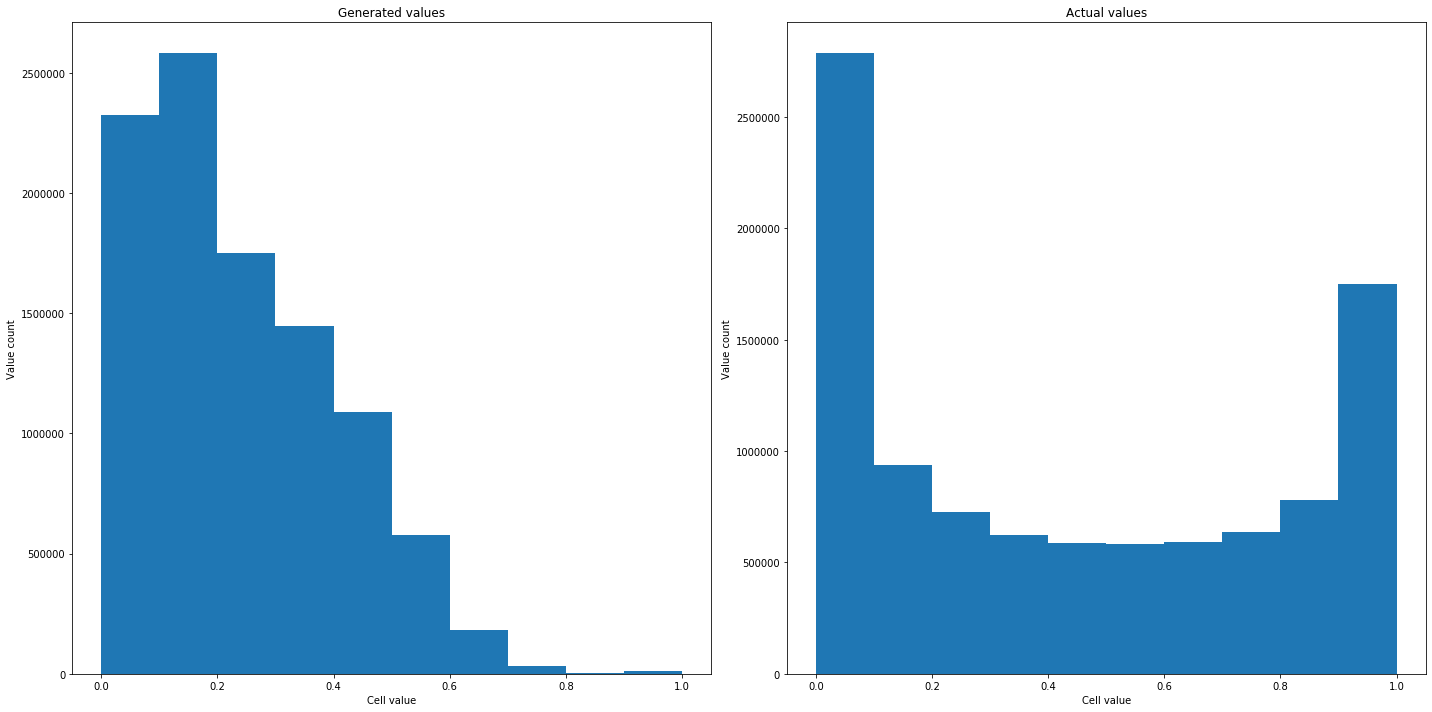

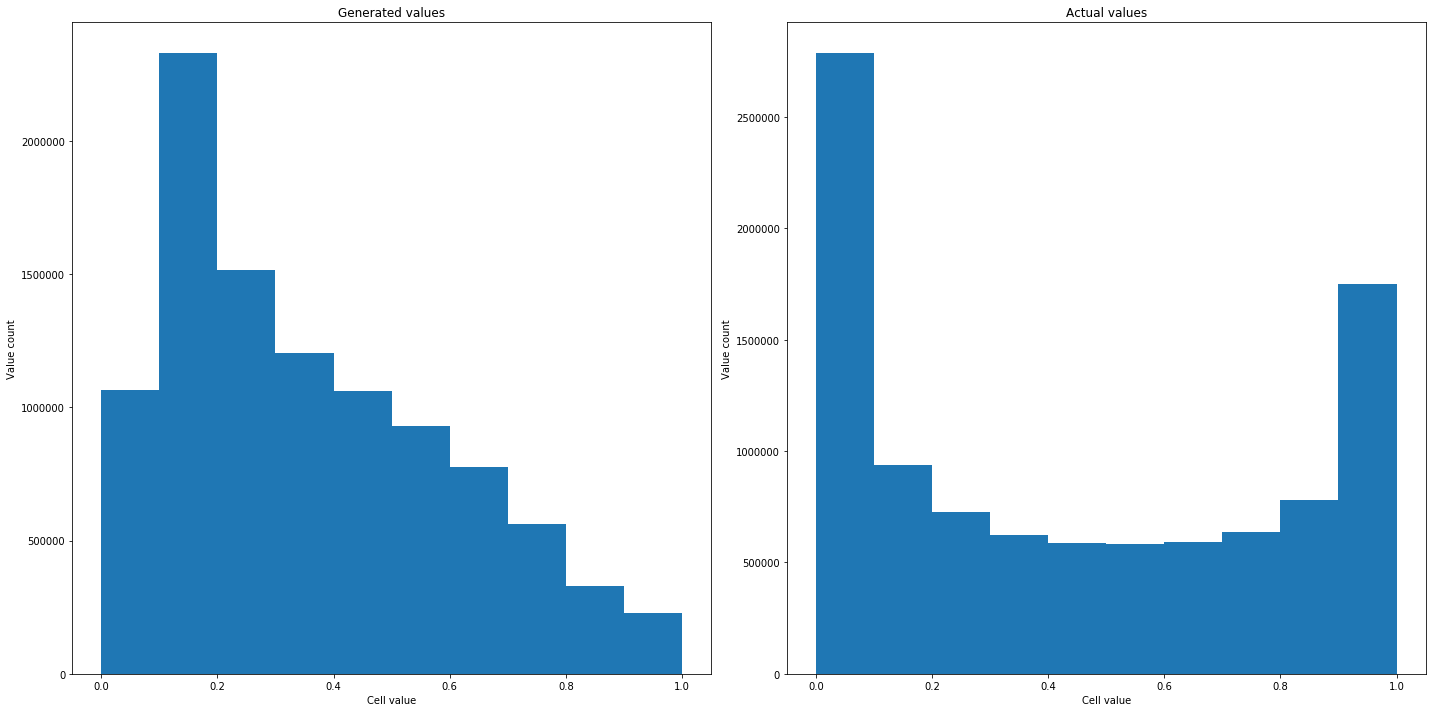

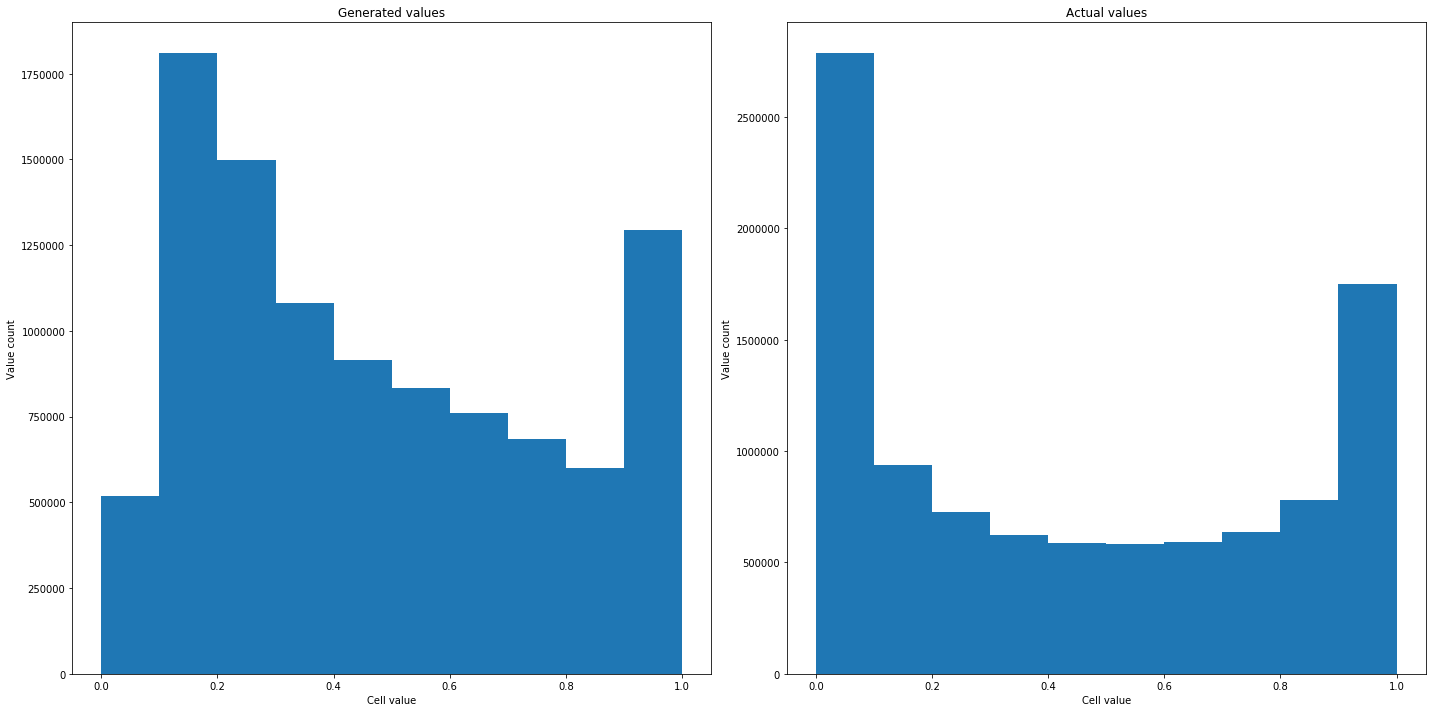

In [223]:
# 3000 - 1000
create_model_save_and_test('rep.10')

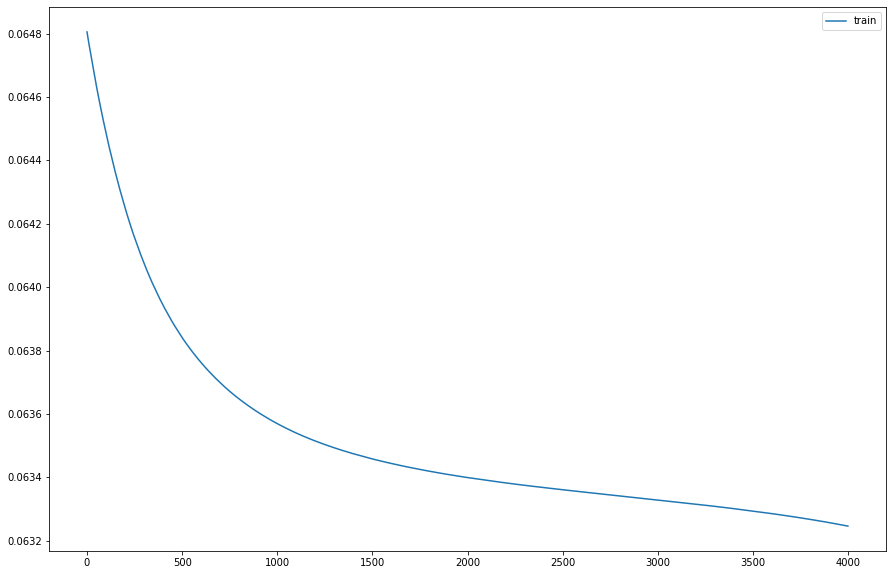

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 32)                32000     
_________________________________________________________________
dense_138 (Dense)            (None, 2)                 64        
_________________________________________________________________
dense_139 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_140 (Dense)            (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.01209182866845547
Spearman base: 0.4263551215139625
MAE 0.42058828213313937
Spearman rescaled: 0.4263551215139625
MAE rescaled 0.4010948611847952
Spearman rescaled: 0.4263551215139625
MAE rescaled 0.35246422313025294

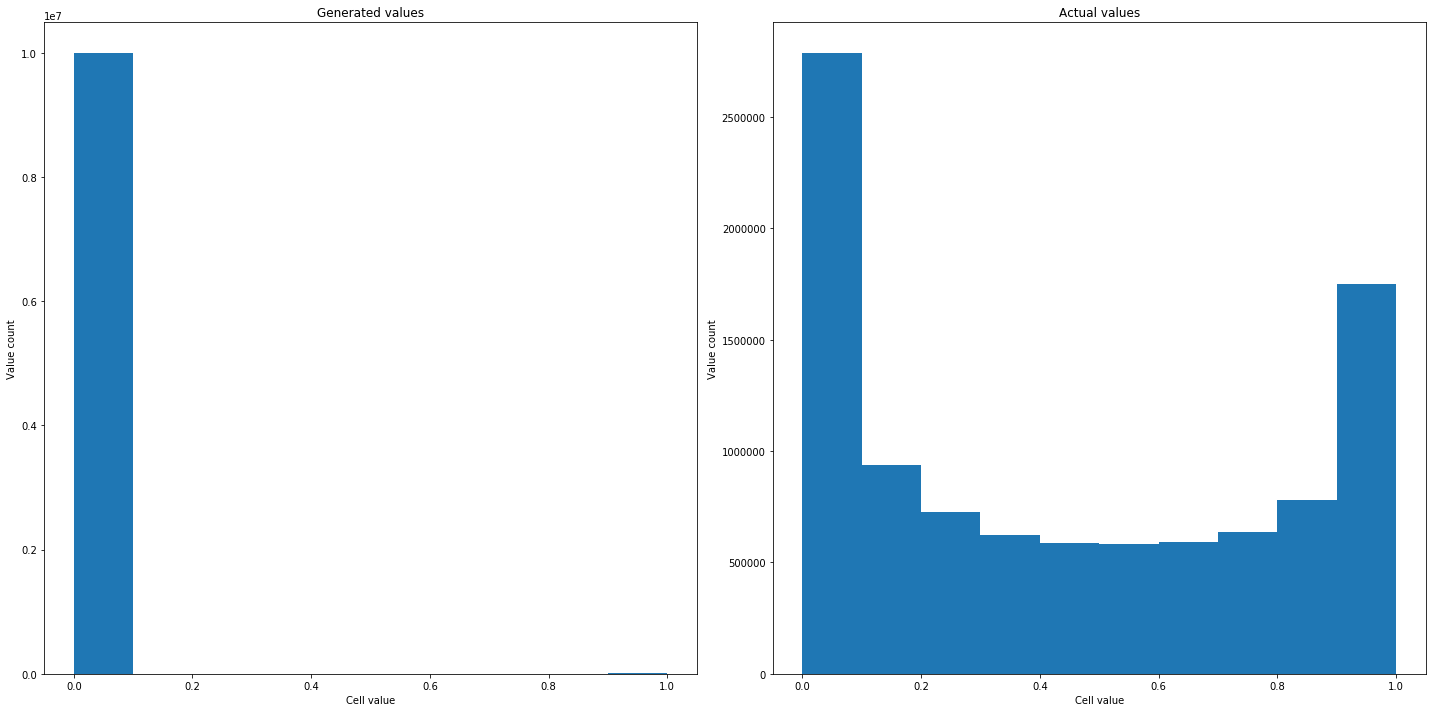

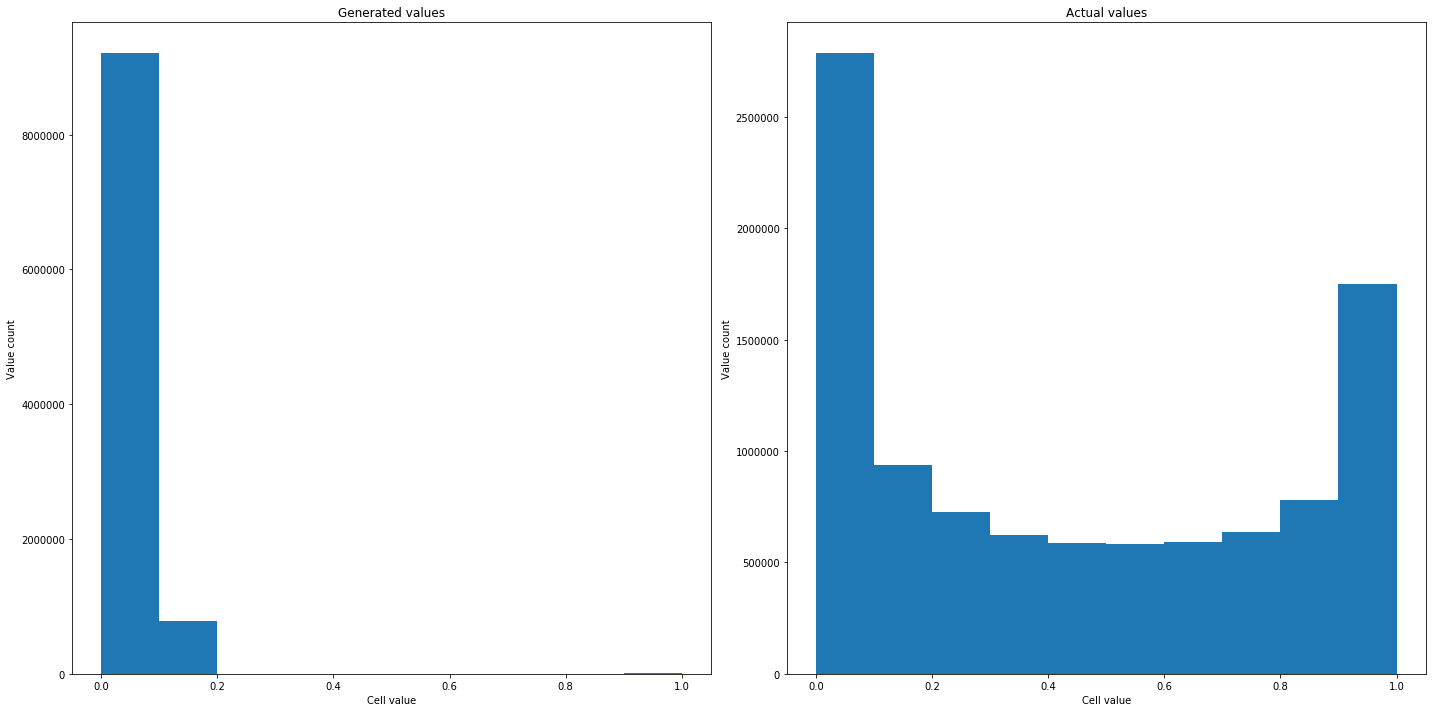

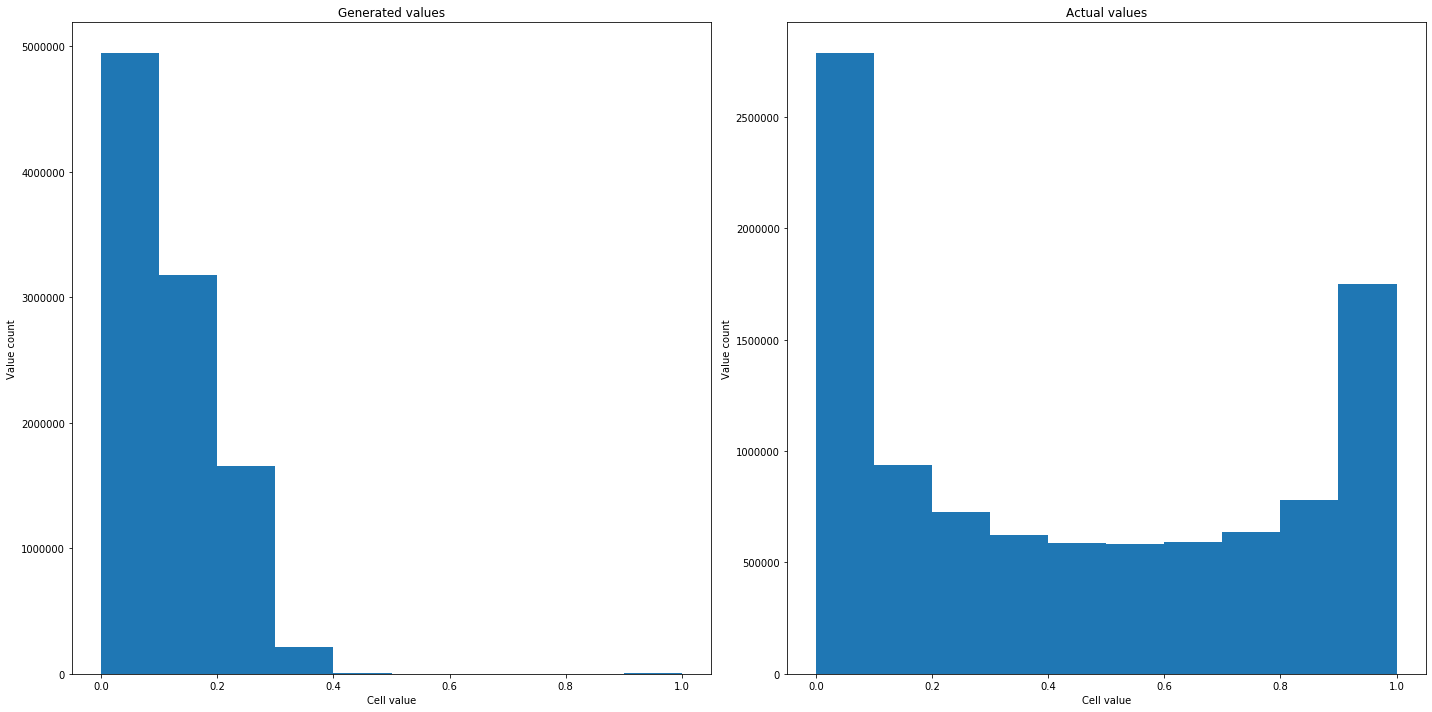

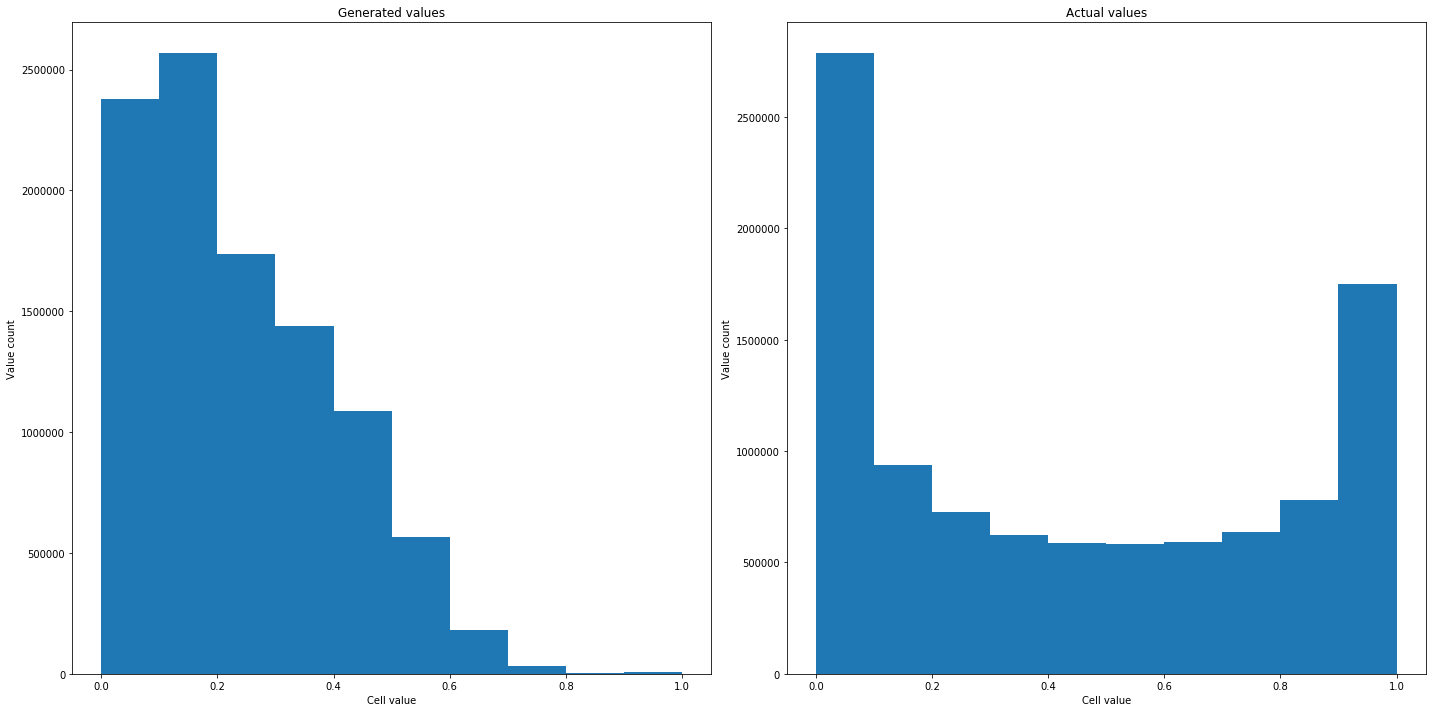

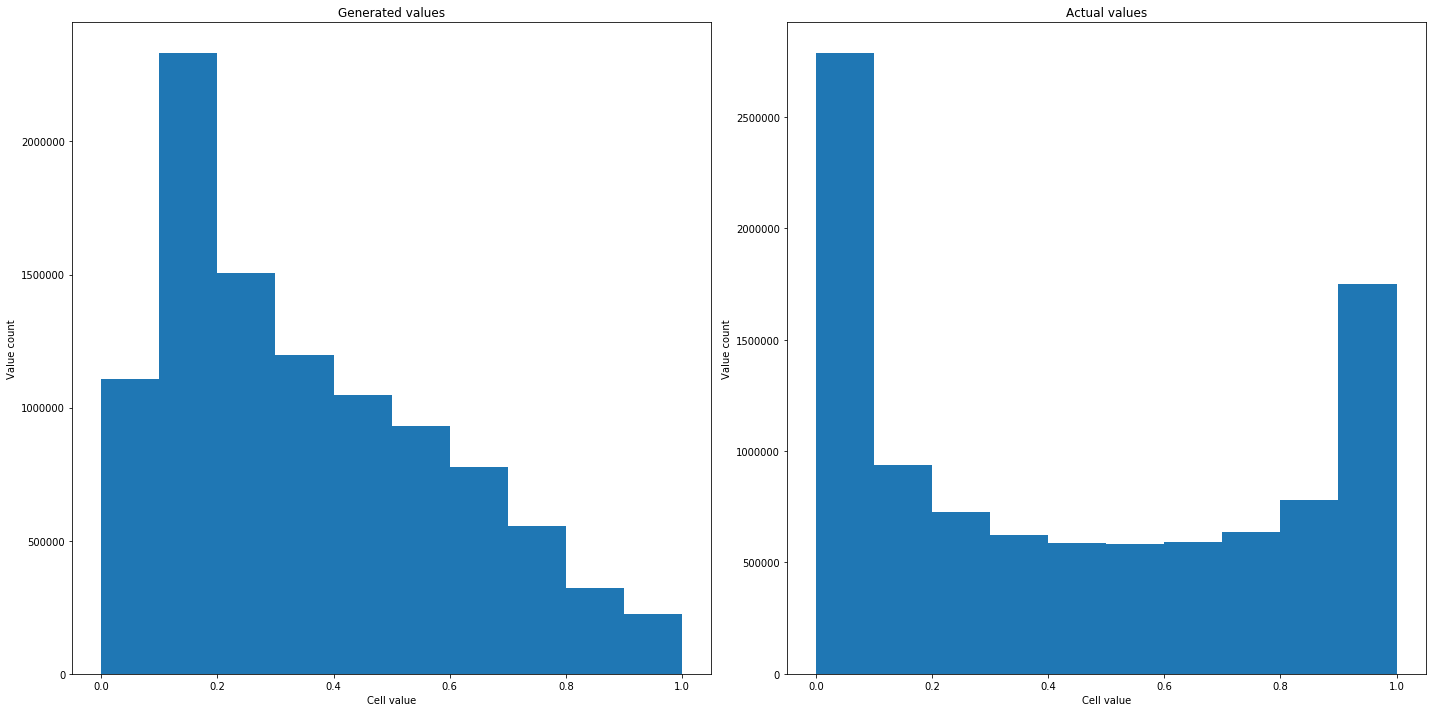

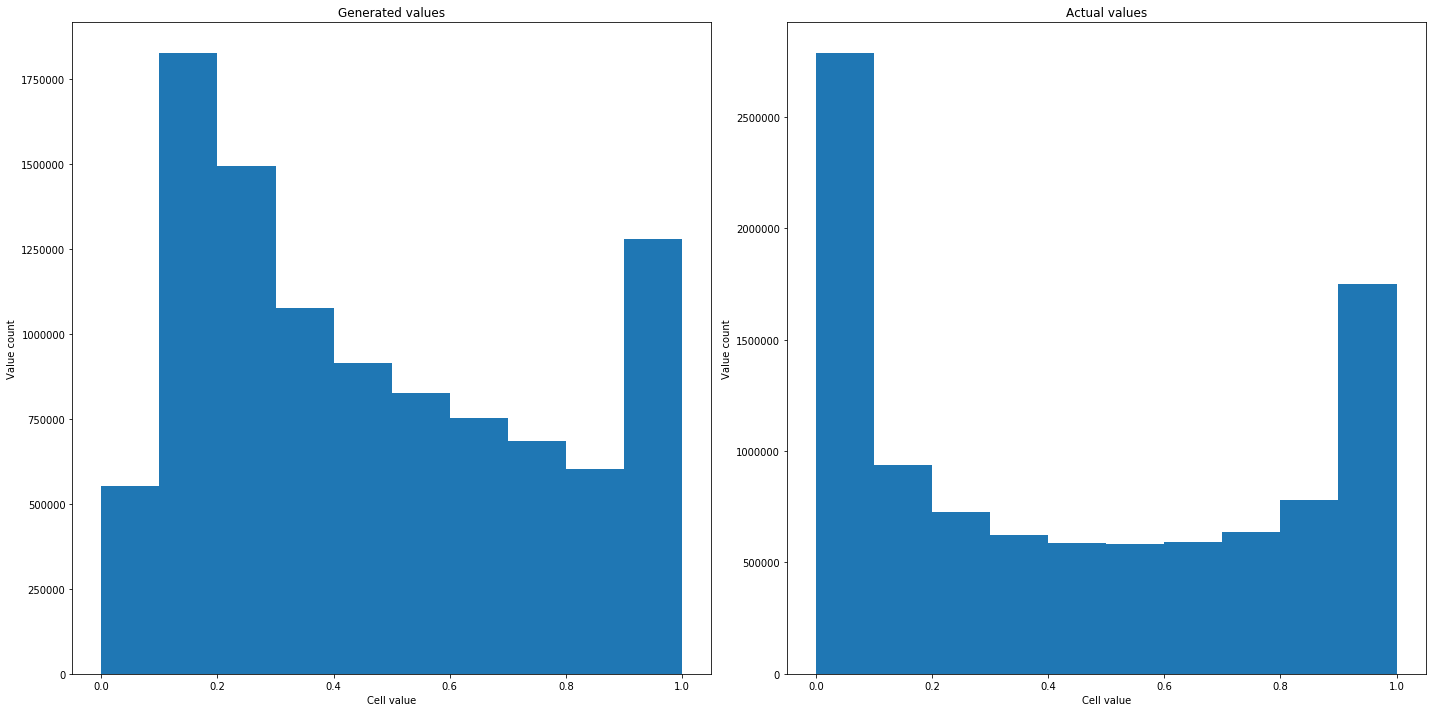

In [242]:
# 5000 - 1000
create_model_save_and_test('rep.10')

In [ ]:
create_model_save_and_test('rep.10')

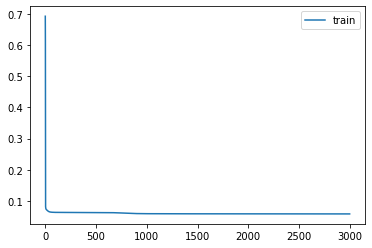

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_91 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_92 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.011987254913260827
Spearman base: 0.8619641233020389
MAE 0.4183015716718225
Spearman rescaled: 0.8619641300234874
MAE rescaled 0.3942849940918612
Spearman rescaled: 0.86196444944443
MAE rescaled 0.32313567909373686
S

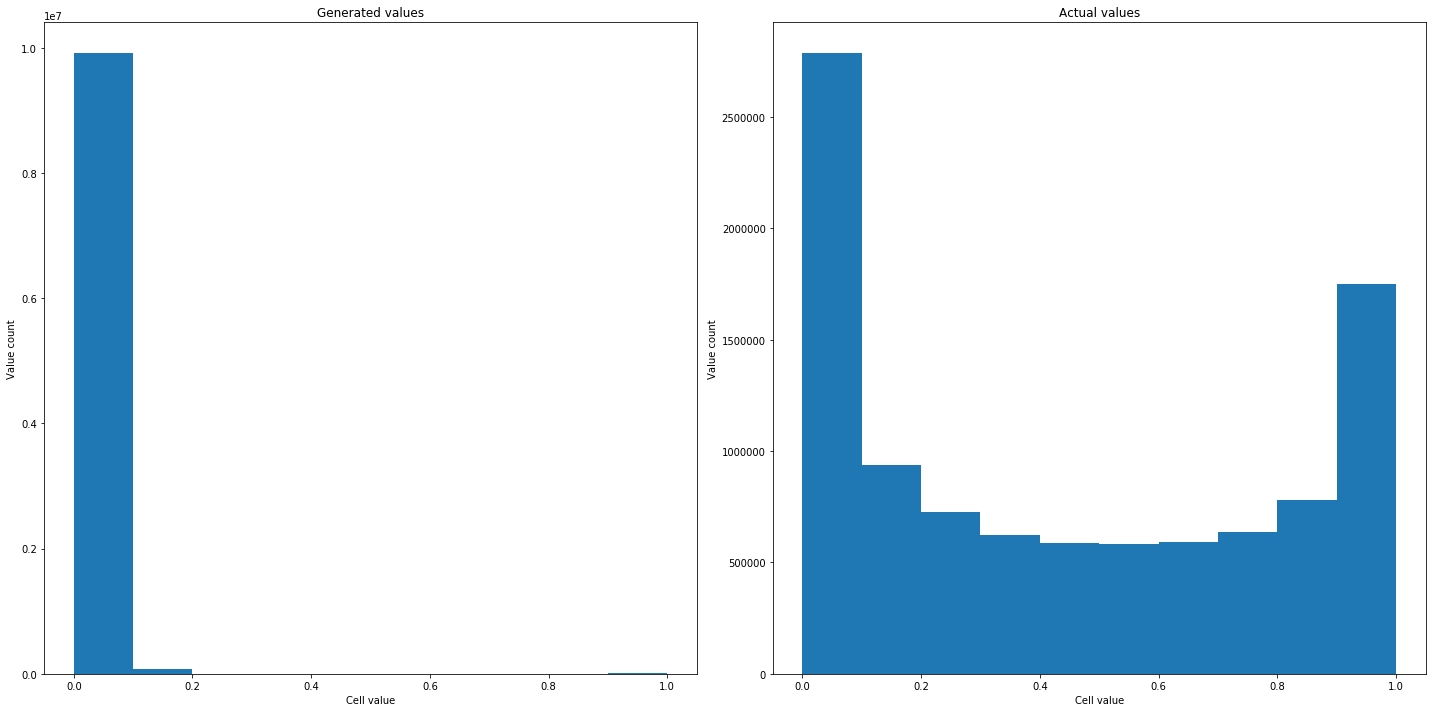

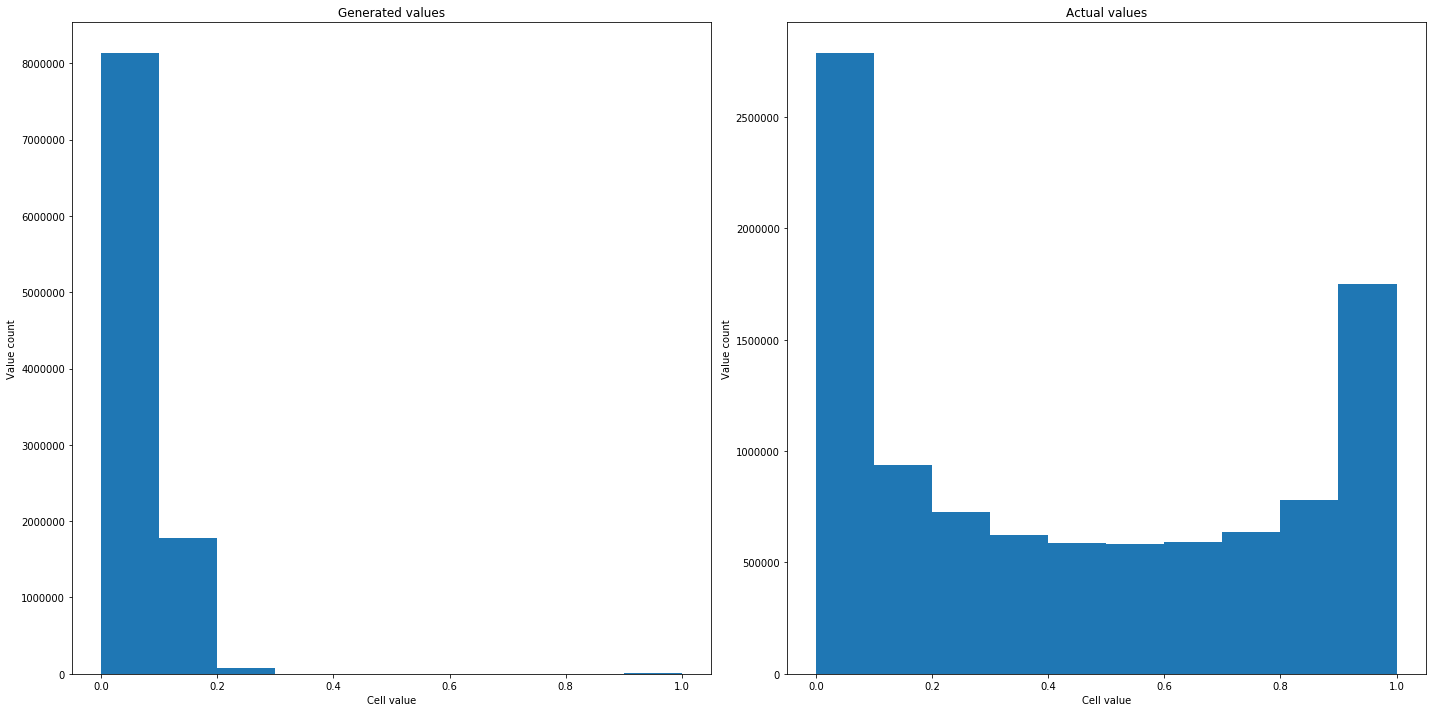

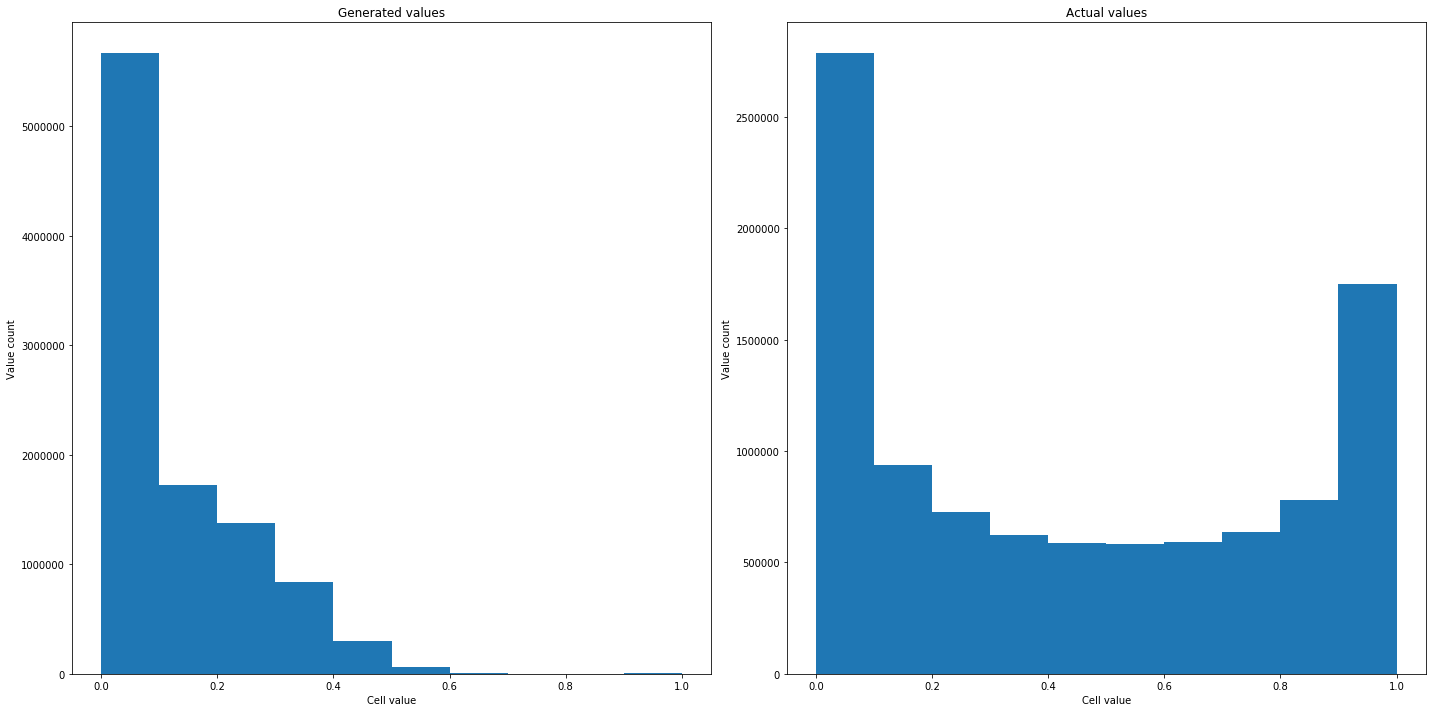

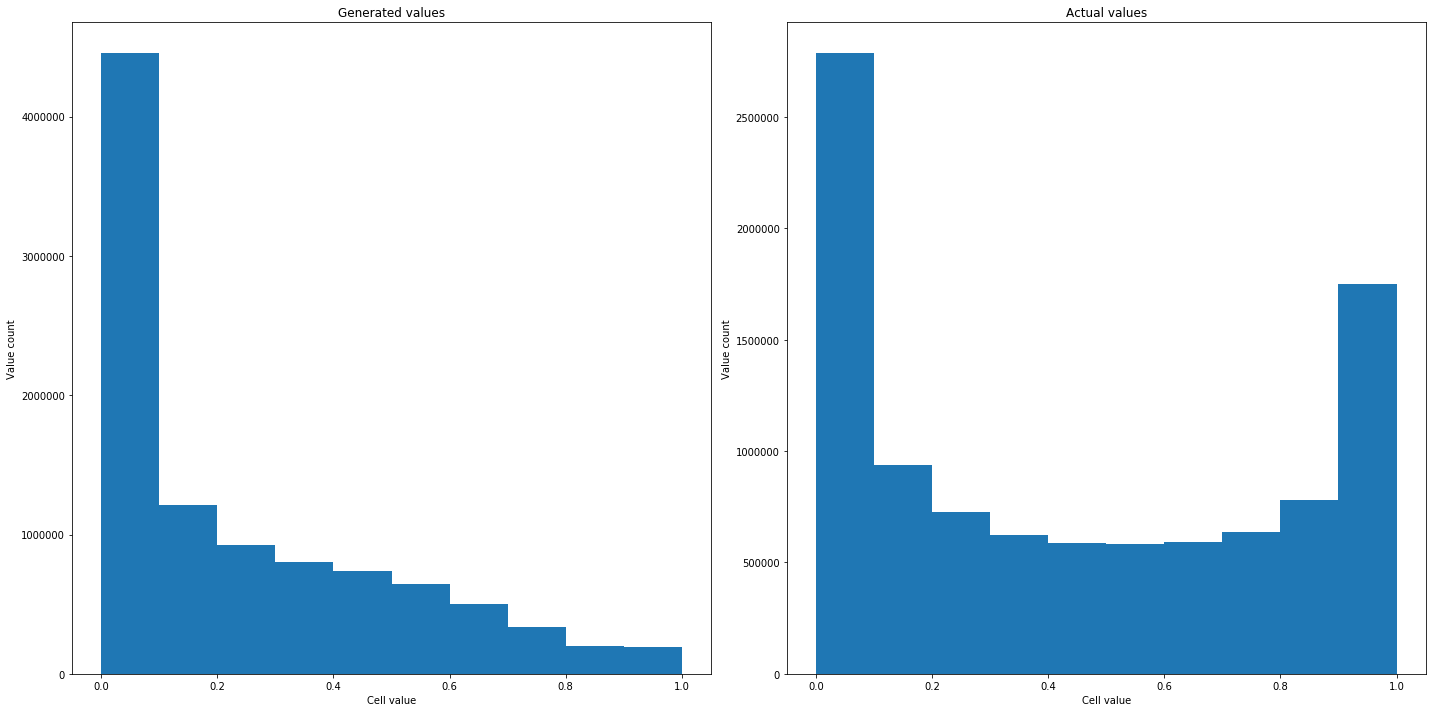

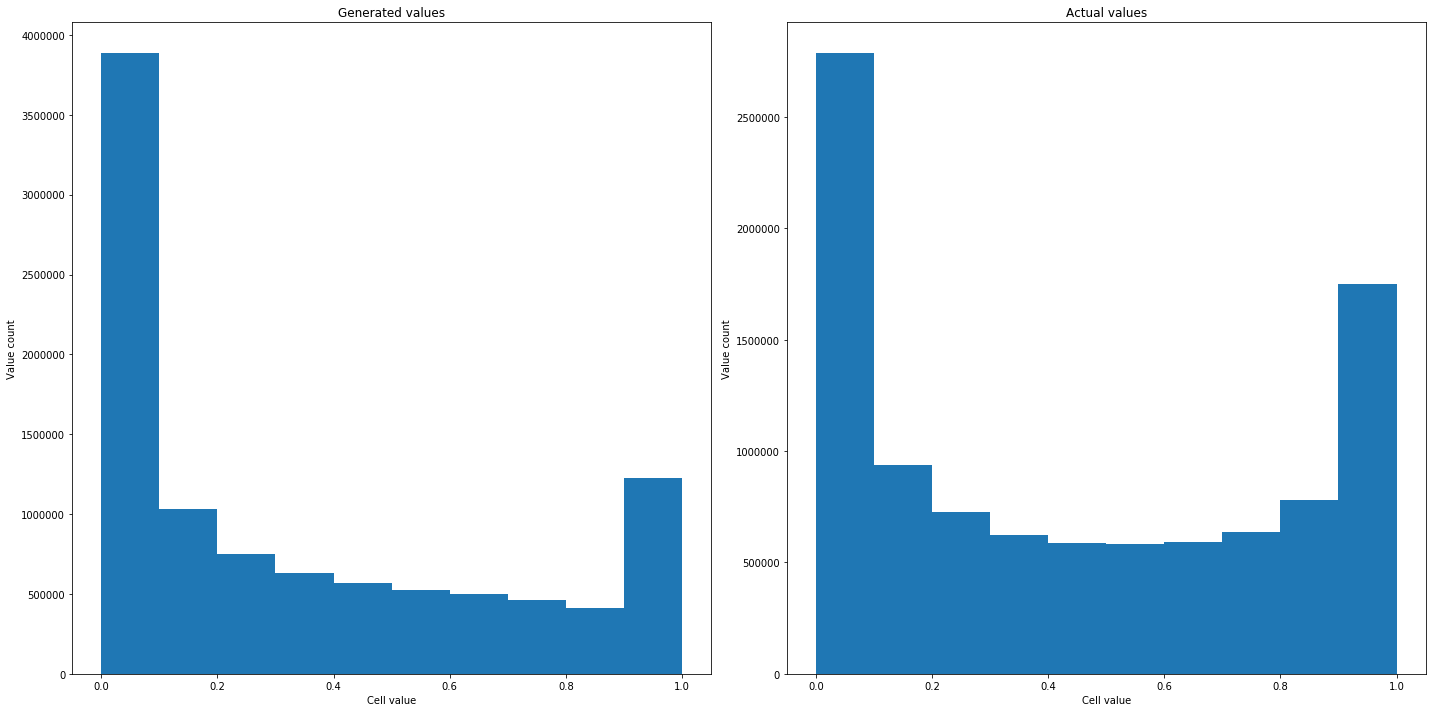

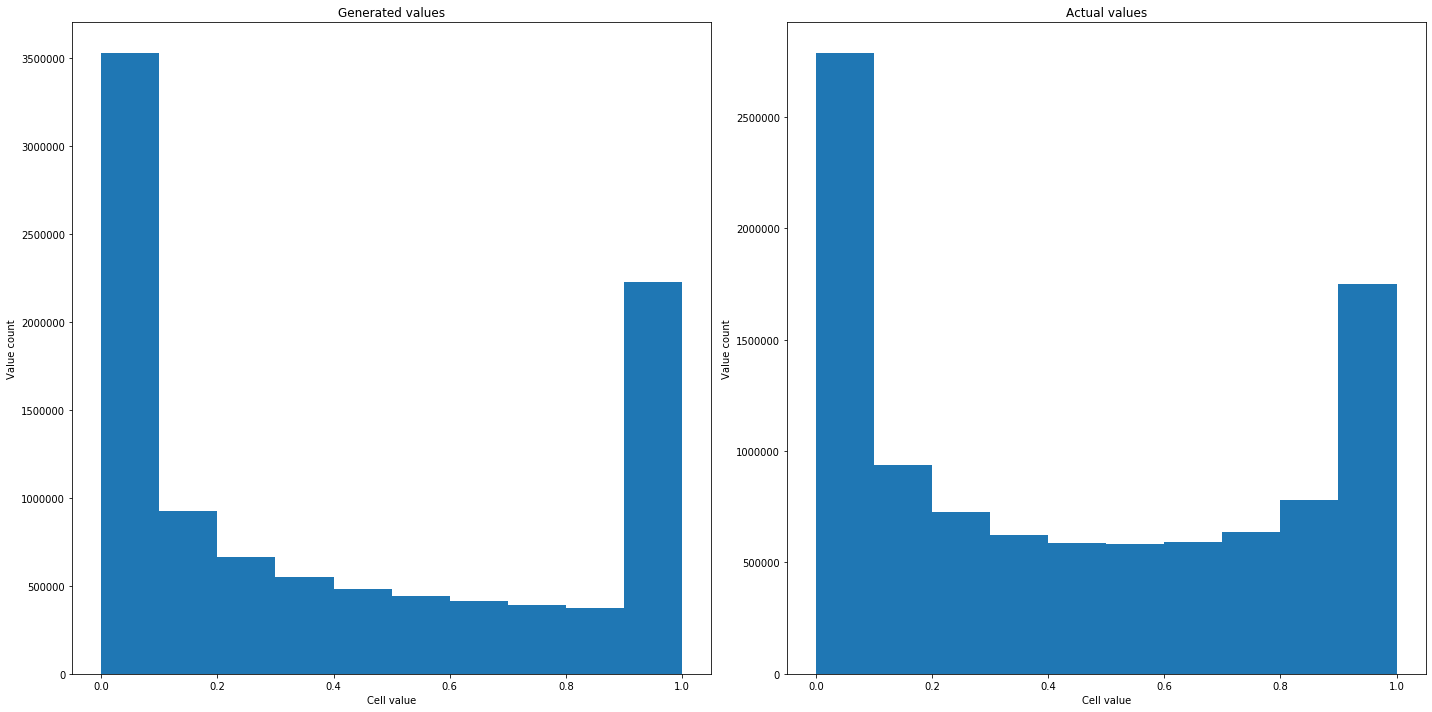

In [204]:
create_model_save_and_test('rep.10')

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_63 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_64 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.011988594106835756
Spearman base: 0.8675422886799925
MAE 0.41830520547992917
Spearman rescaled: 0.8675661980205949
MAE rescaled 0.21602378674684614
Spearman rescaled: 0.8677897826214331
MAE rescaled 0.159219865791864

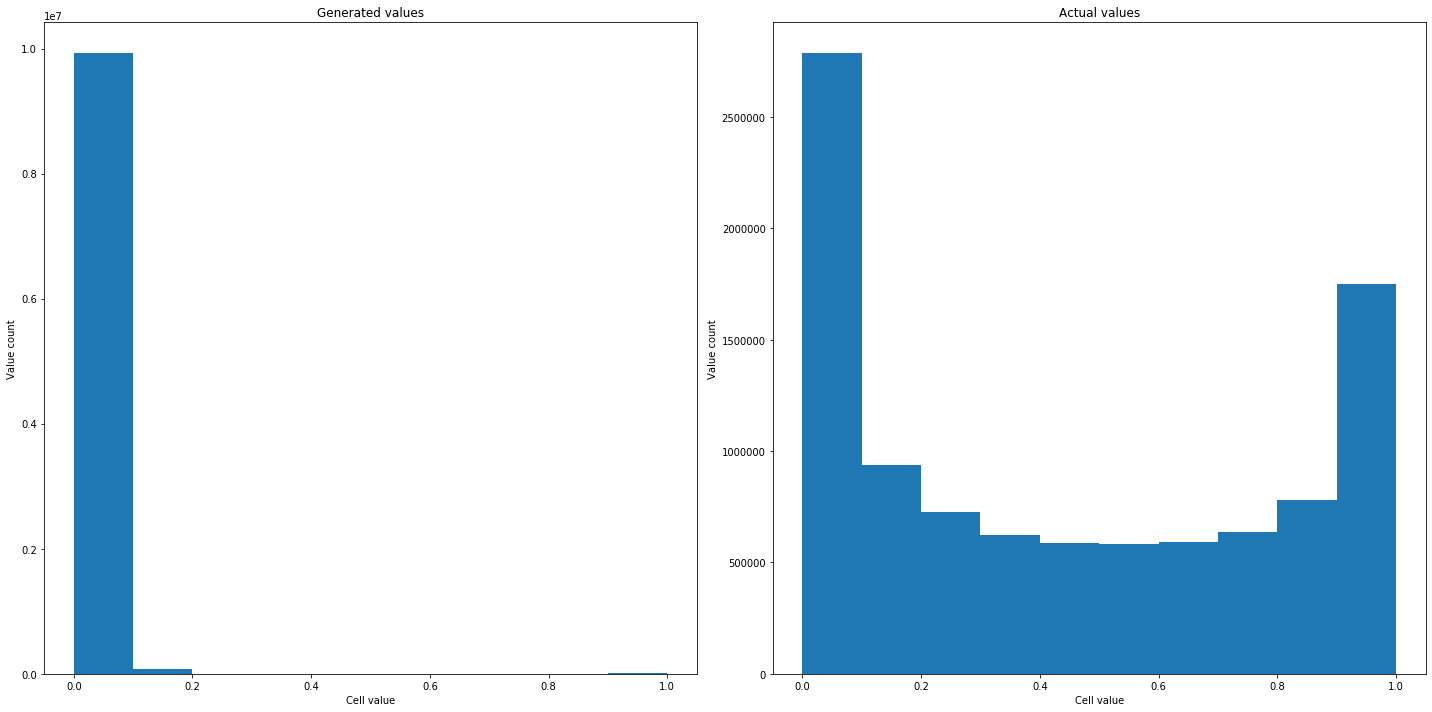

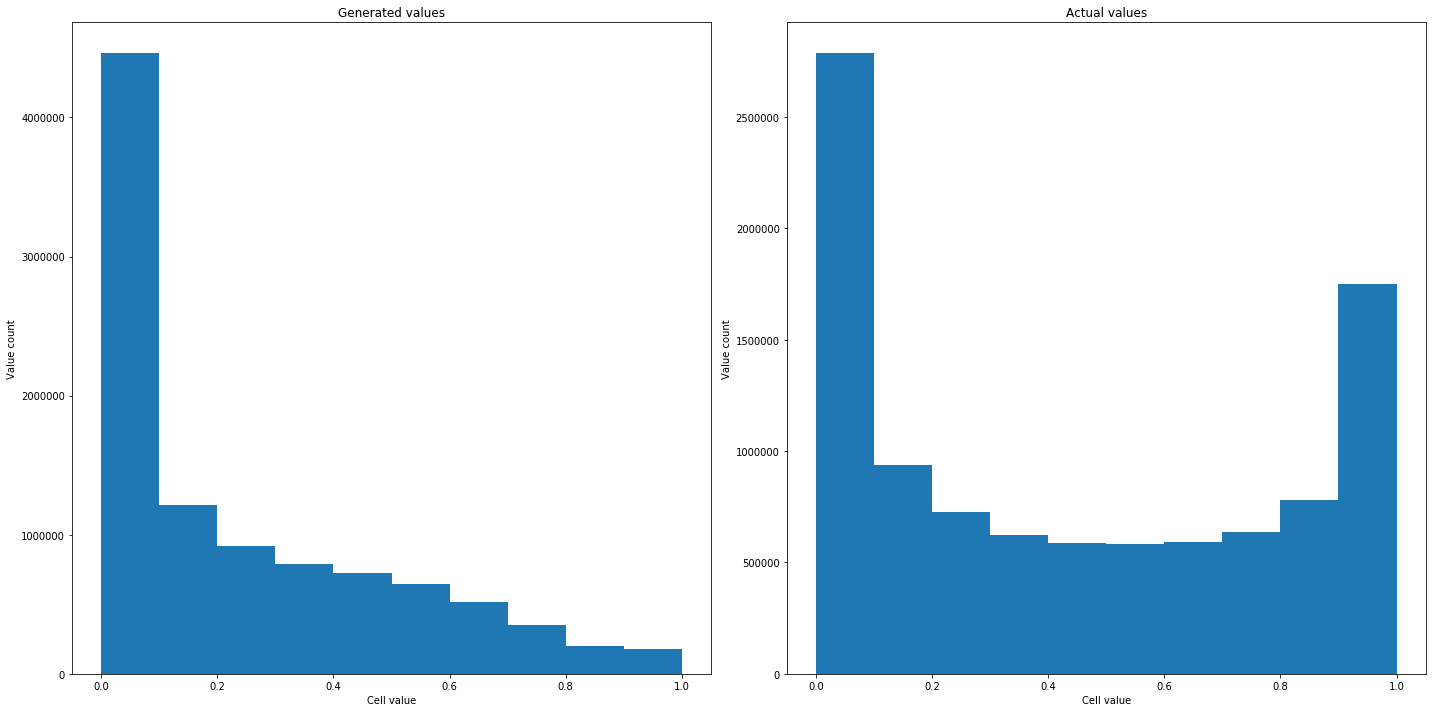

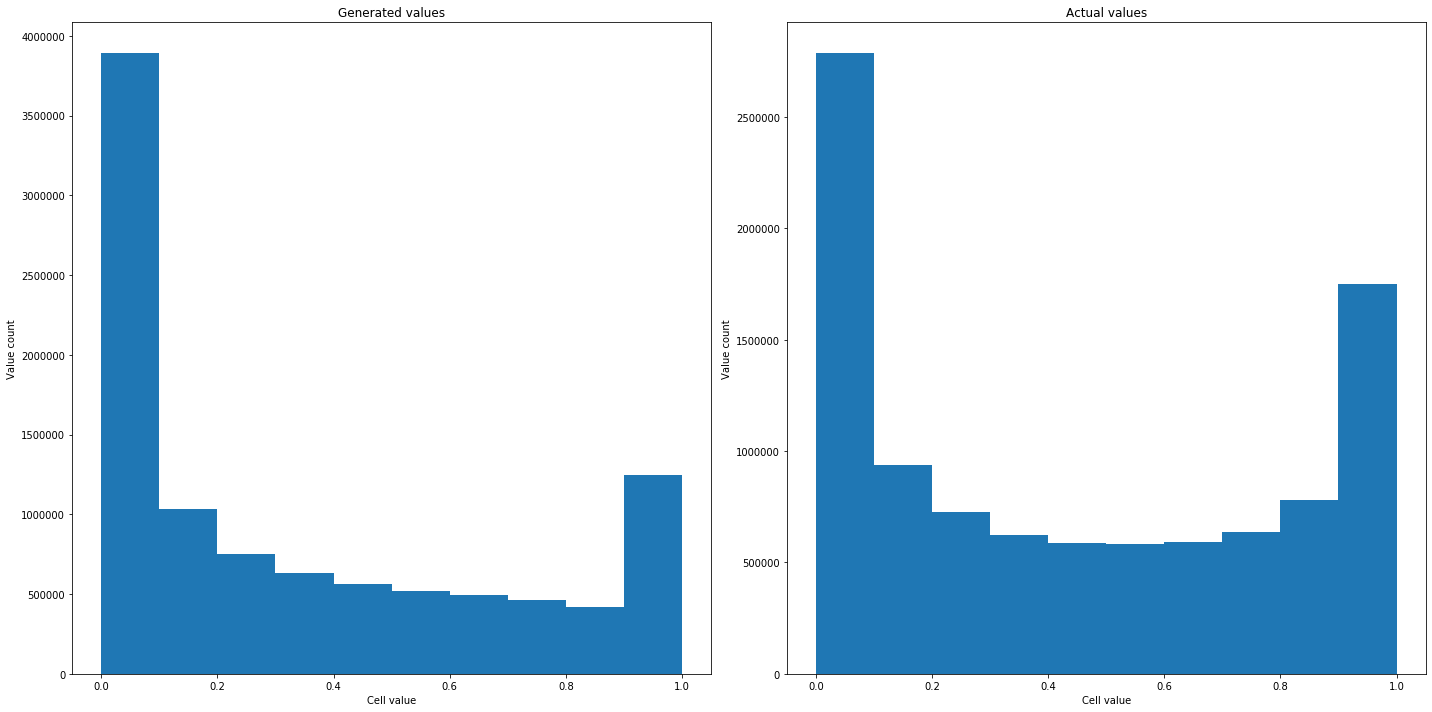

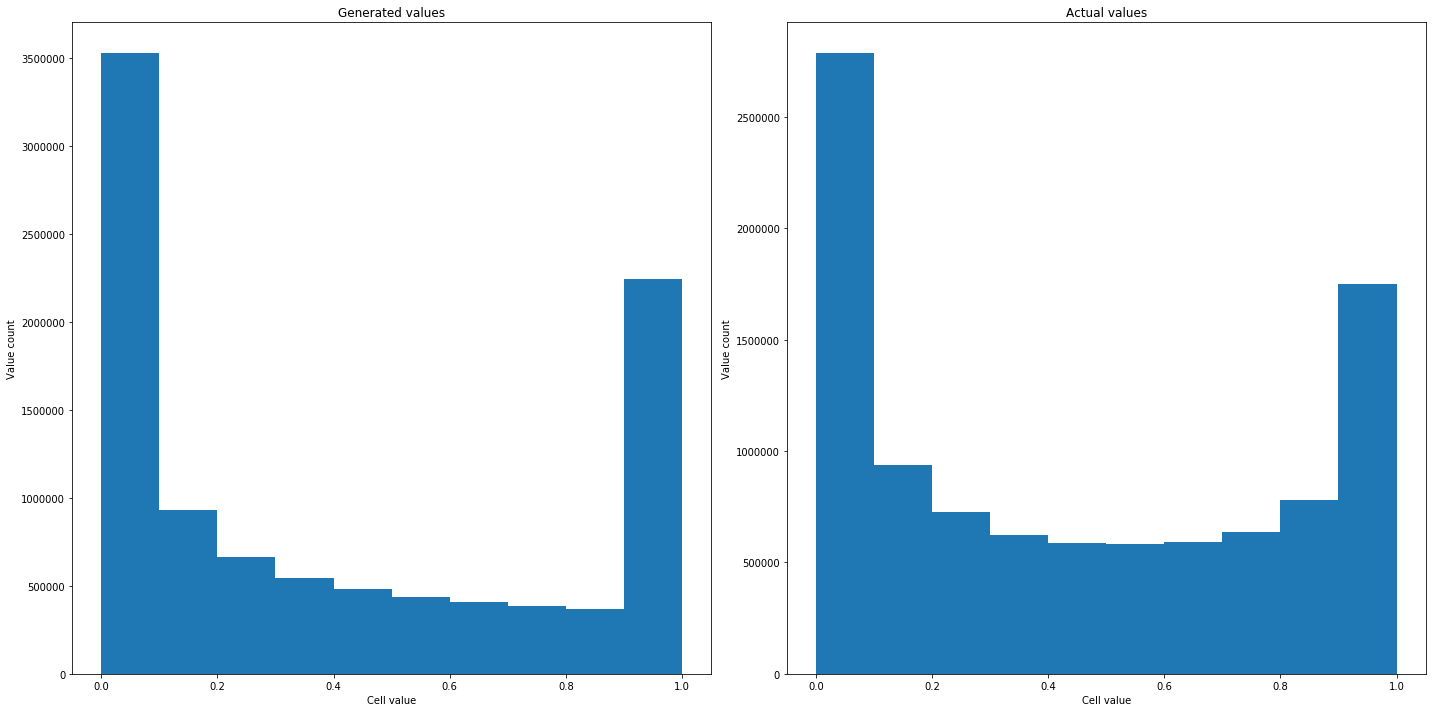

In [181]:
# linear middle function
create_model_save_and_test('rep.10')

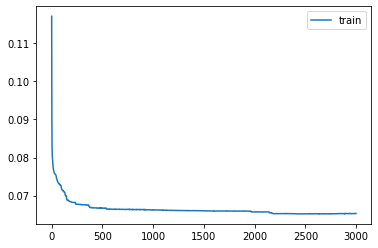

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_82 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_83 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_84 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.016063820197628566
Spearman base: 0.7176513551358373
MAE 0.48751064008013384
Spearman rescaled: 0.0014731565313518813
MAE rescaled 0.558221391456071
Spearman rescaled: -0.0002470896510175851
MAE rescaled 0.5582260633

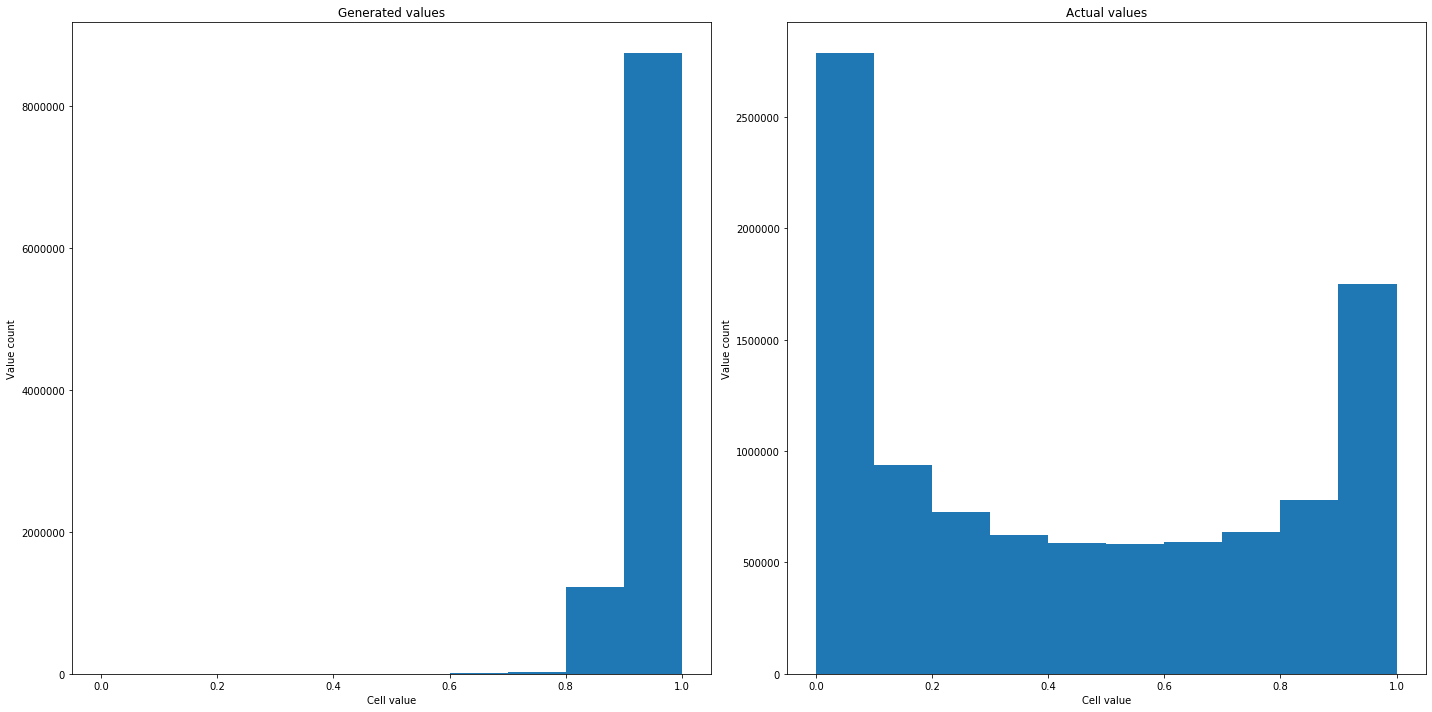

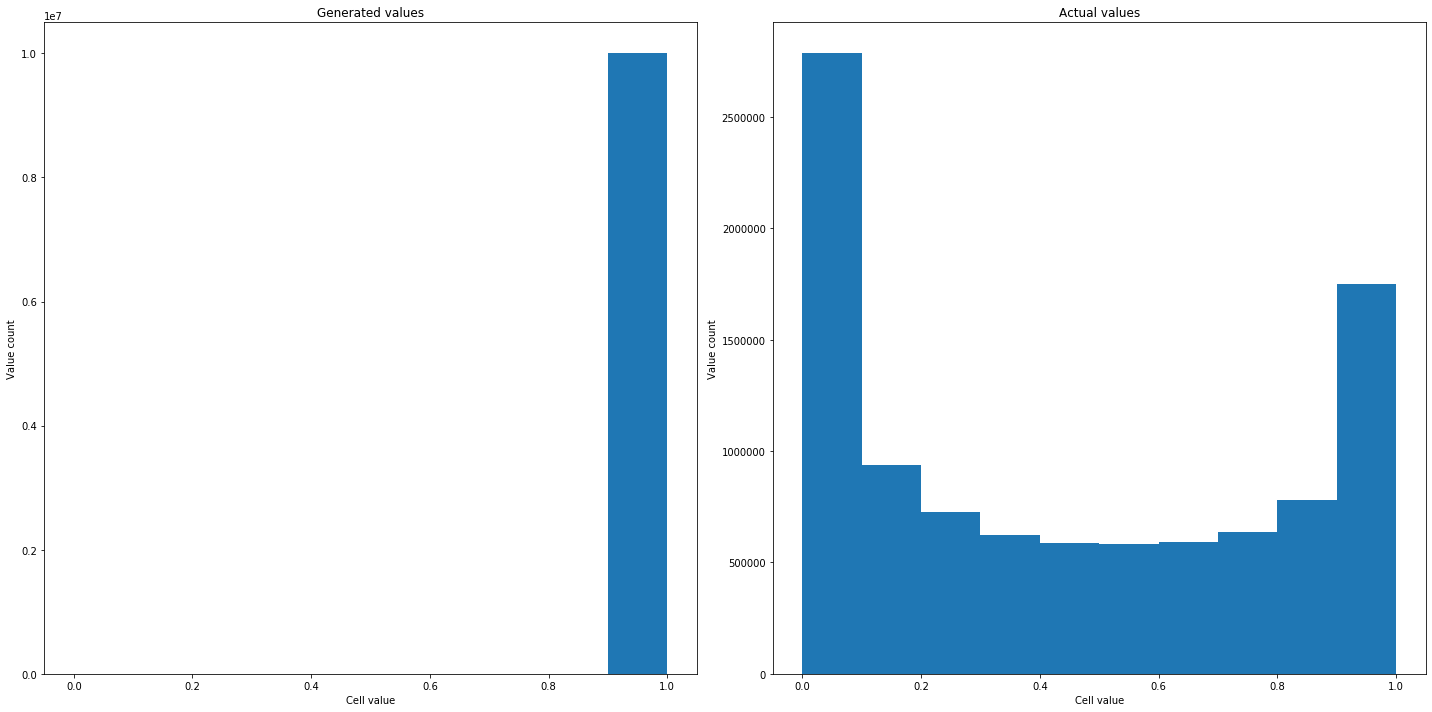

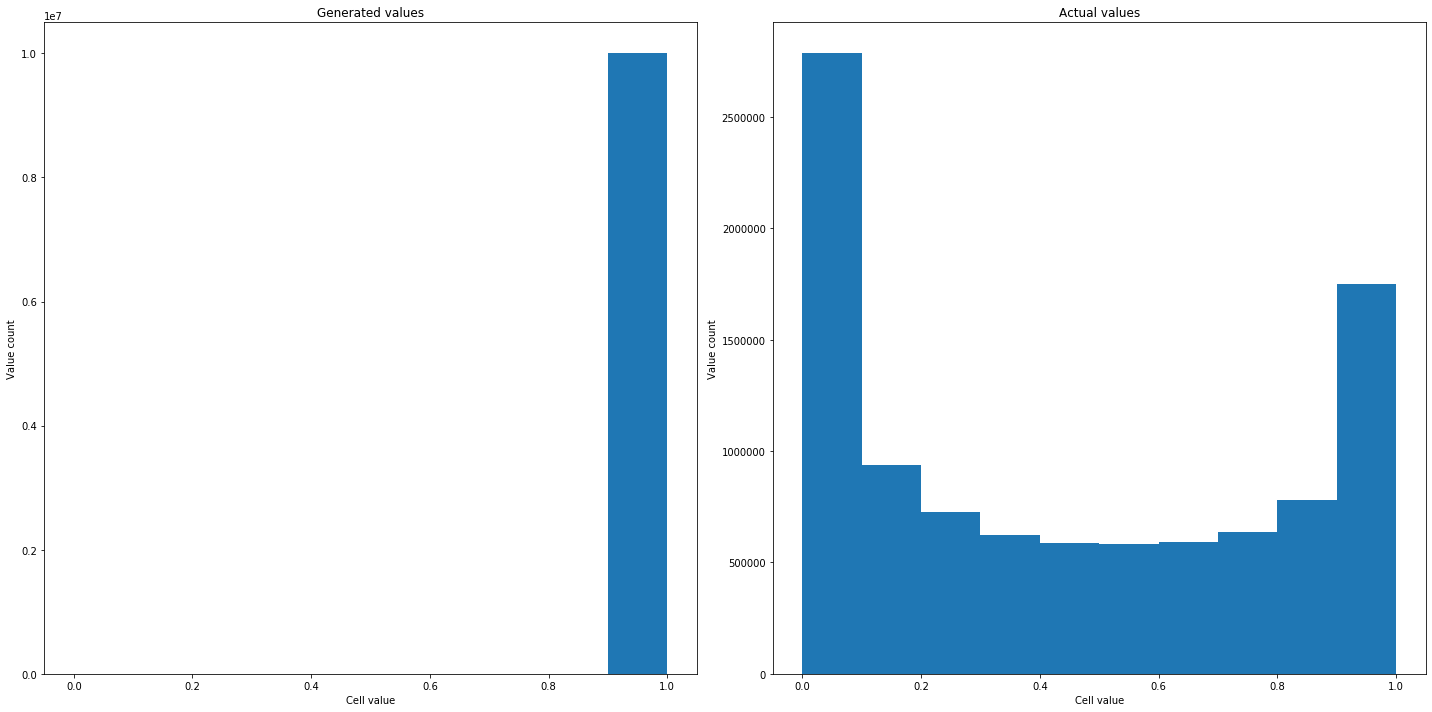

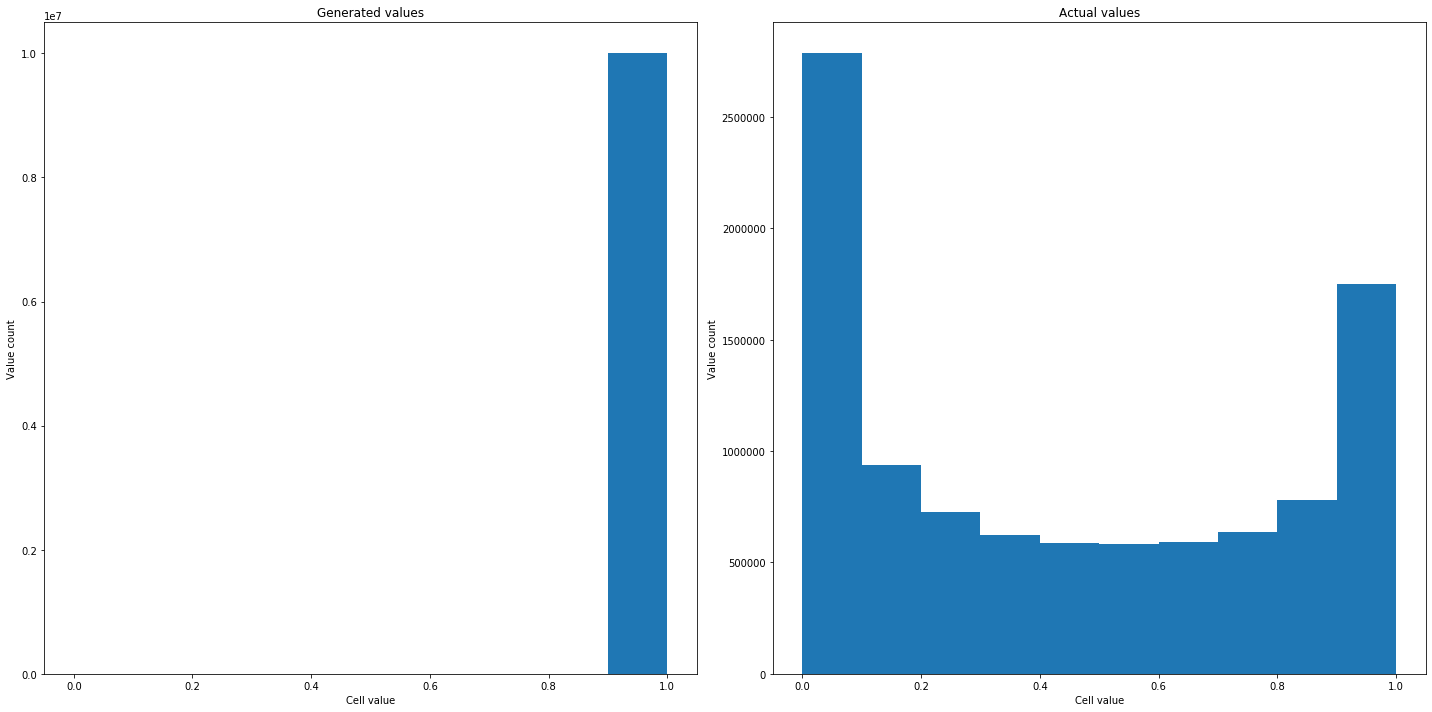

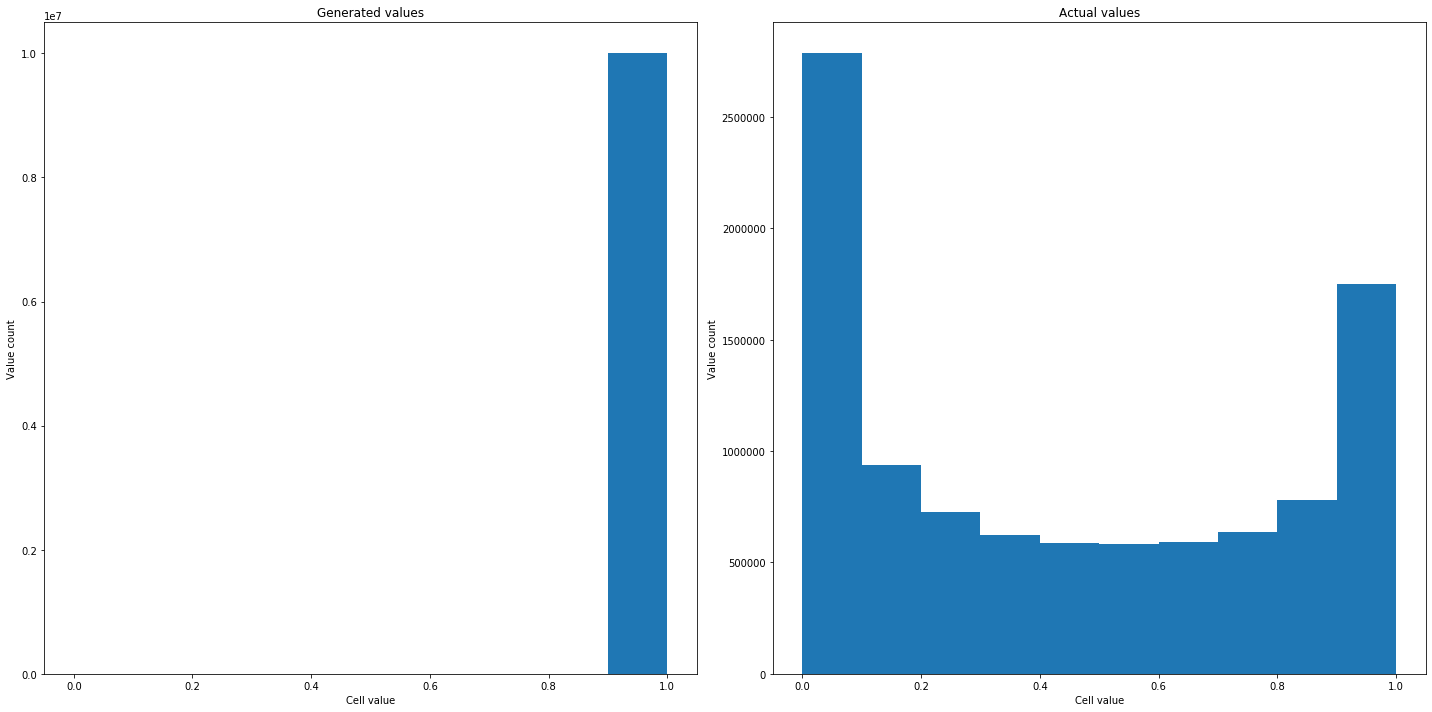

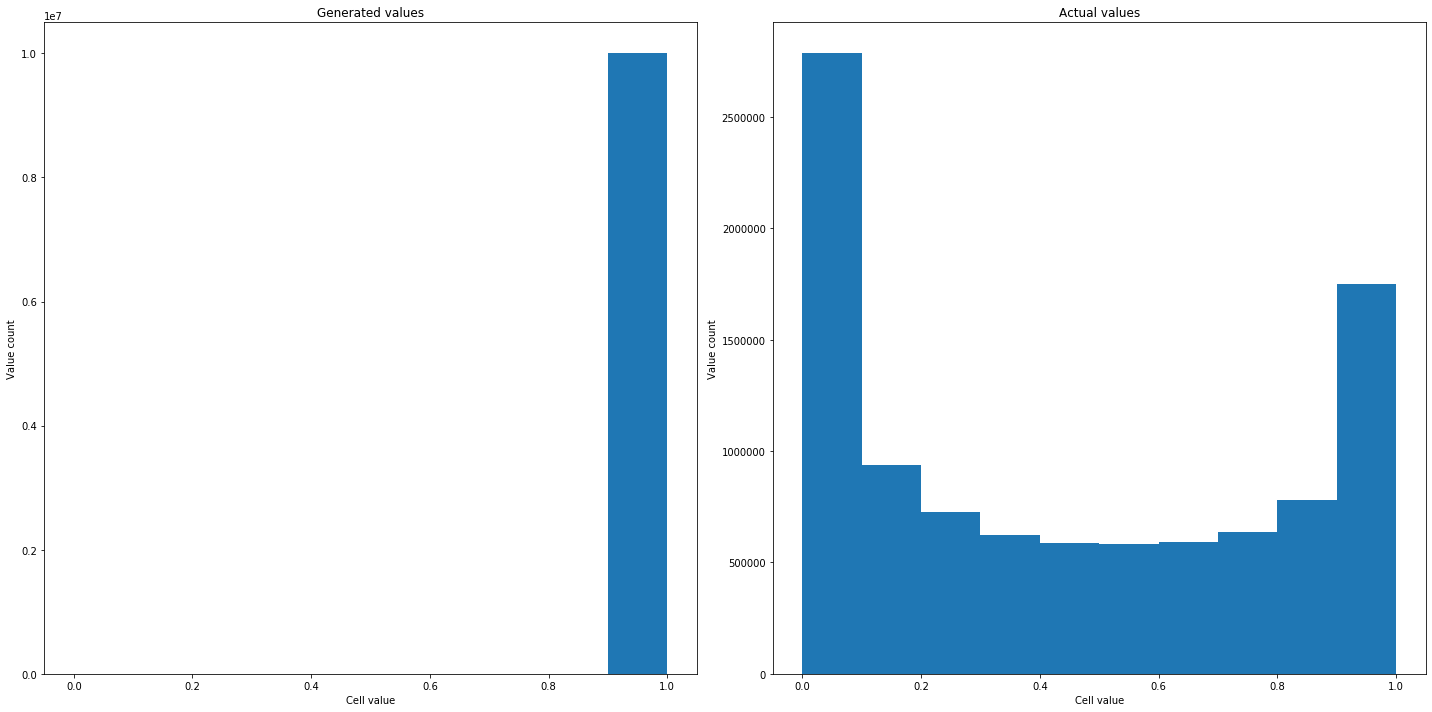

In [200]:
create_model_save_and_test('rep.10')

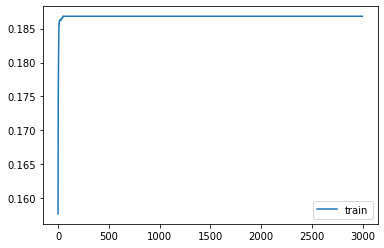

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 32)                32000     
_________________________________________________________________
dense_86 (Dense)             (None, 2)                 64        
_________________________________________________________________
dense_87 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_88 (Dense)             (None, 1000)              32000     
Total params: 64,128
Trainable params: 64,128
Non-trainable params: 0
_________________________________________________________________
Train reconstrunction error
 0.02101353253163769
Spearman base: -0.009398669102820313
MAE 0.49367743803475994
Spearman rescaled: -0.012024792634798694
MAE rescaled 0.5550754050211331
Spearman rescaled: -0.024175390837233485
MAE rescaled 0.55826886

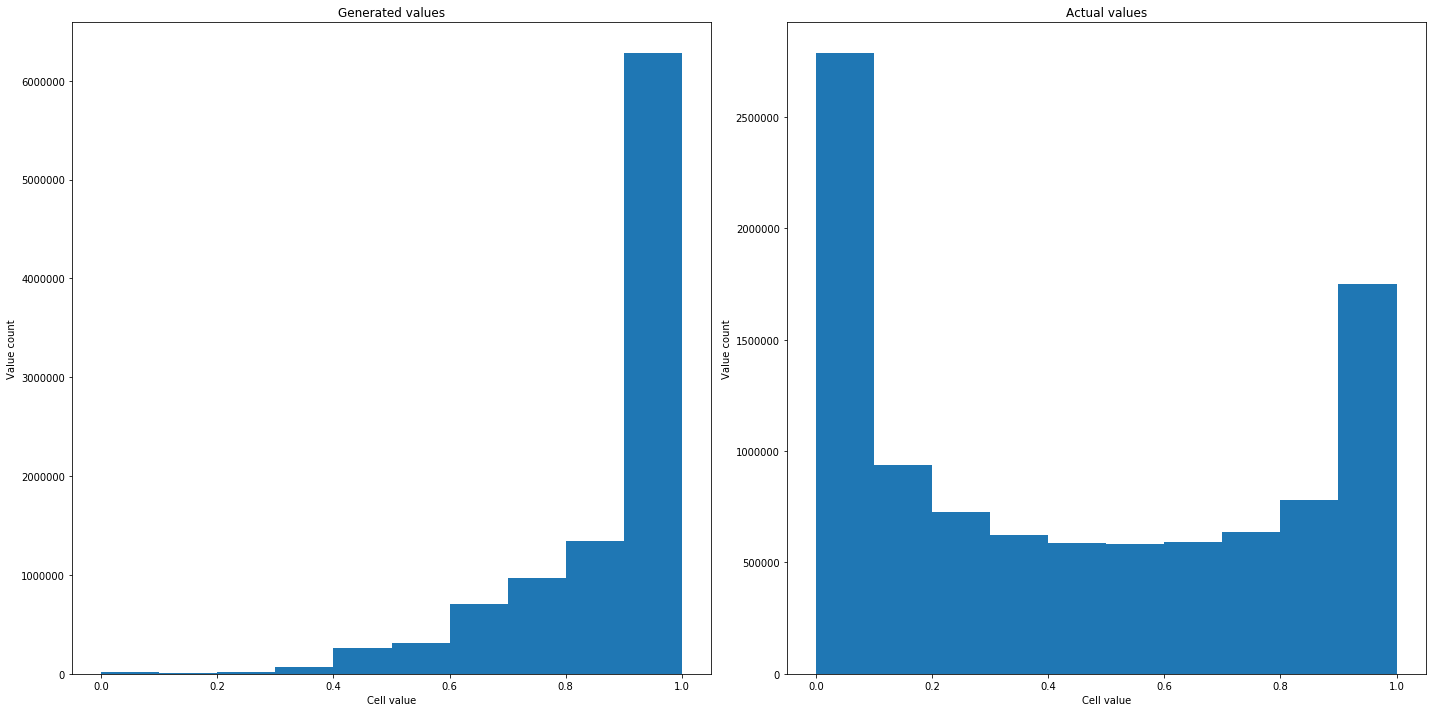

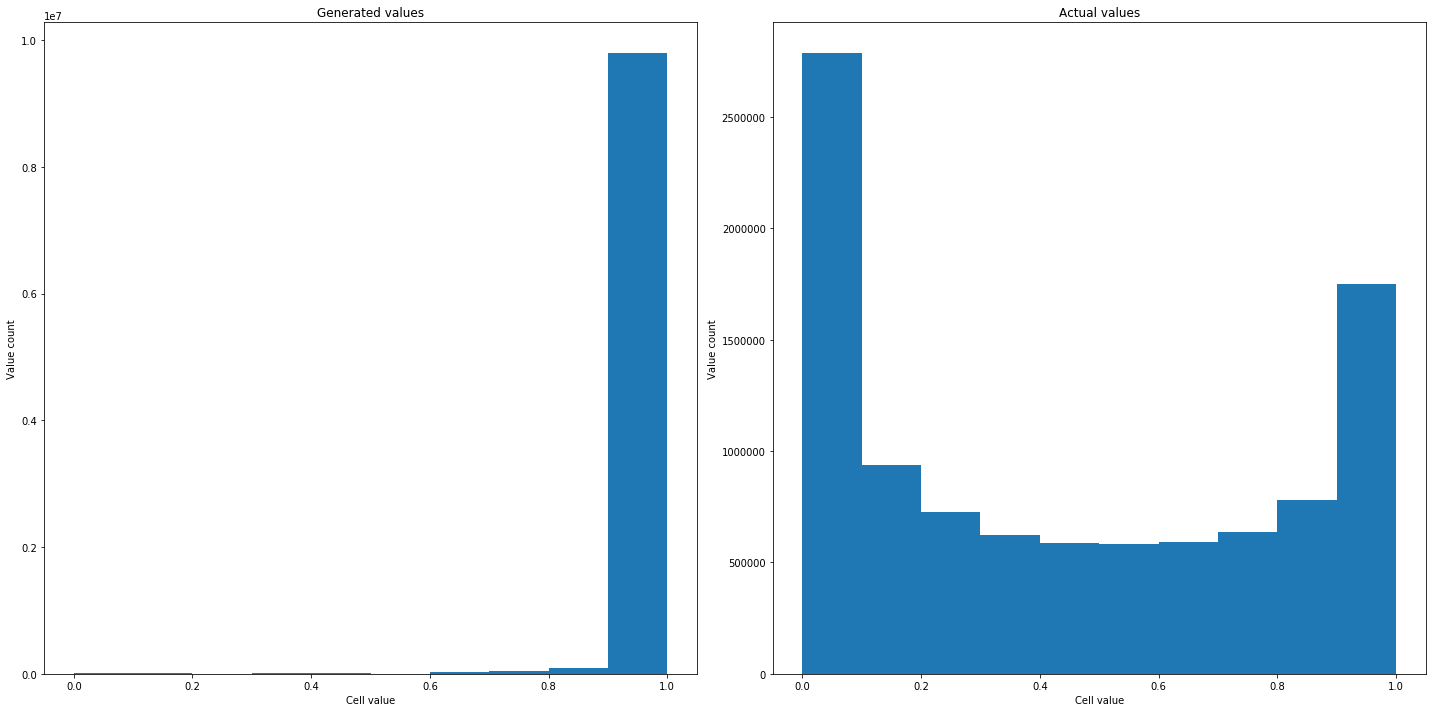

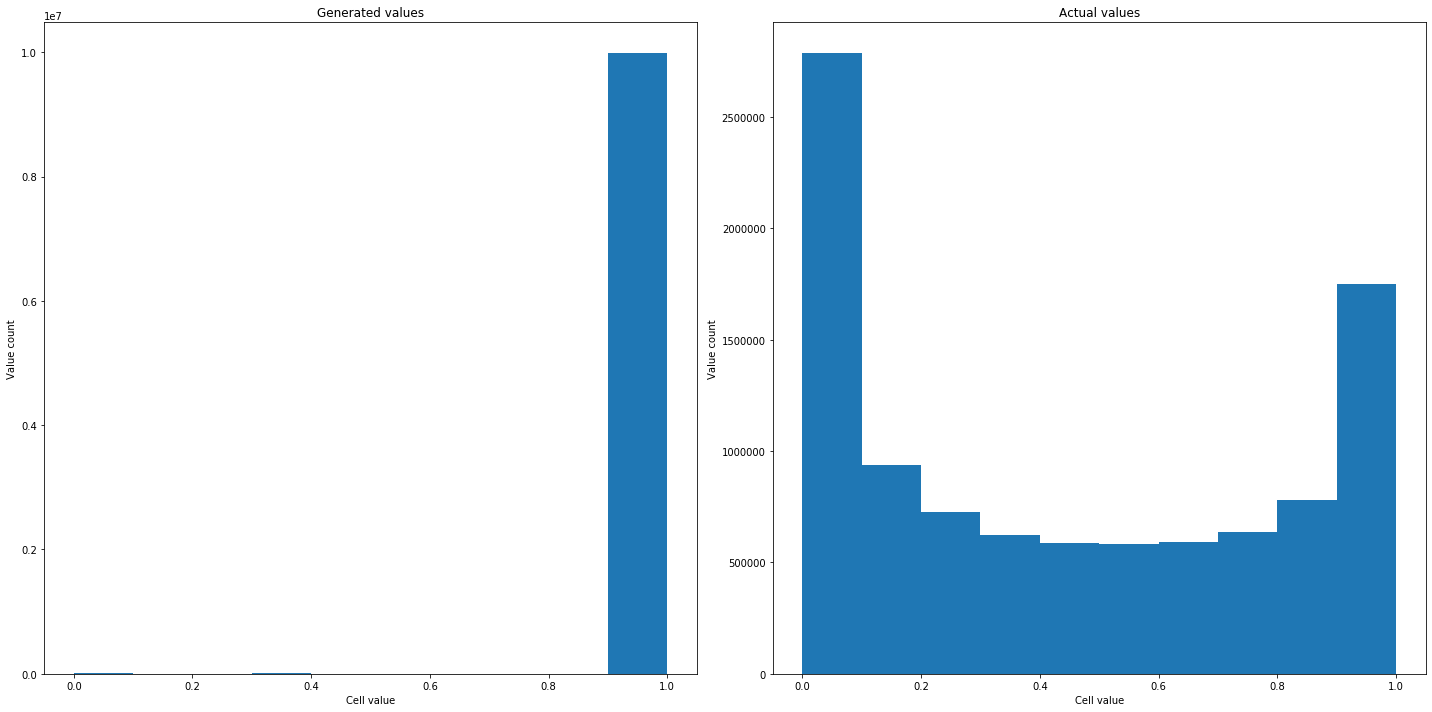

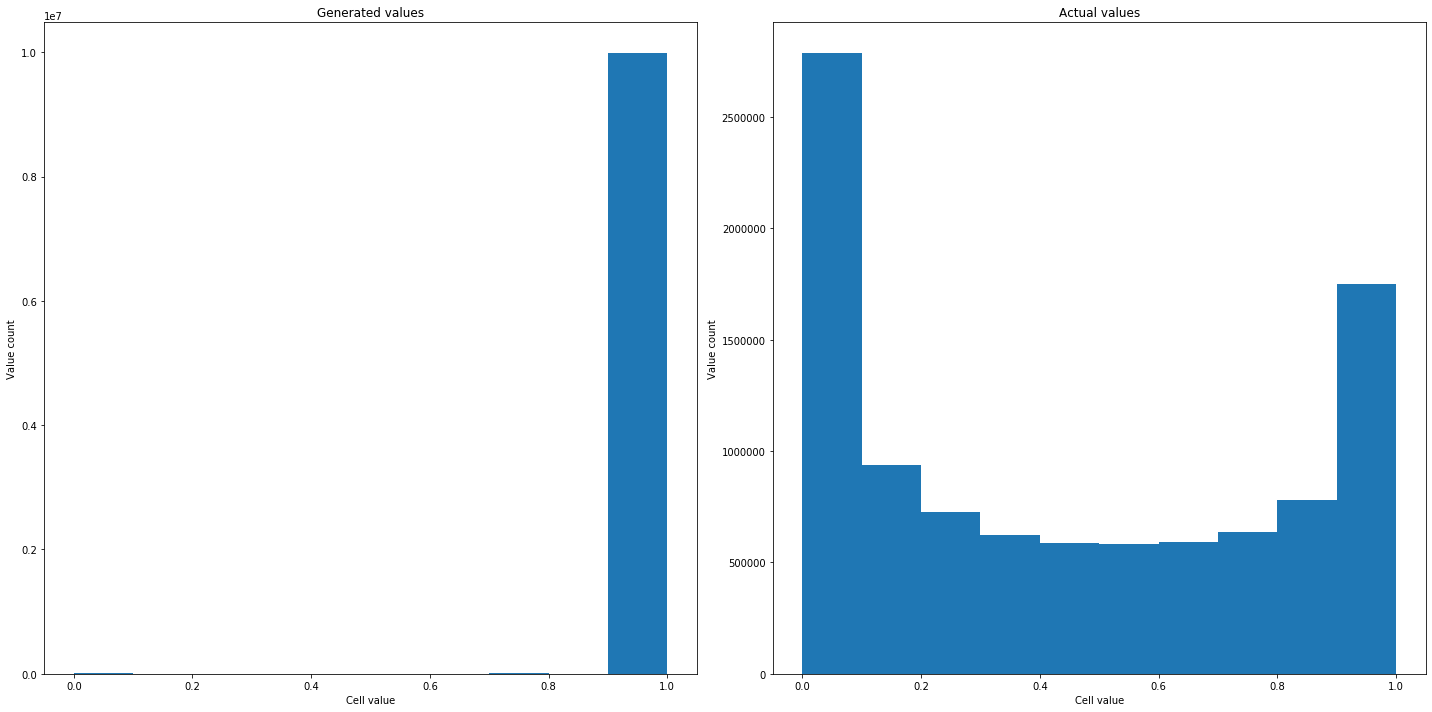

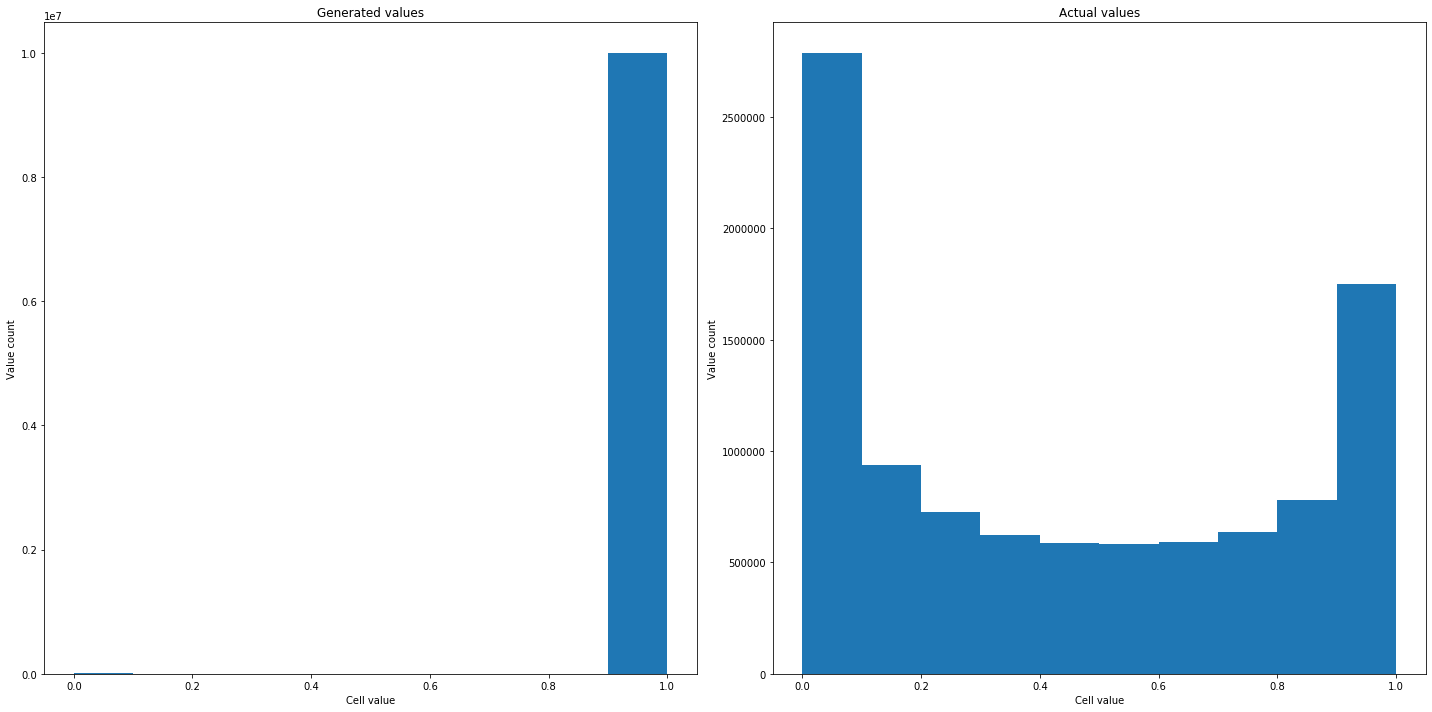

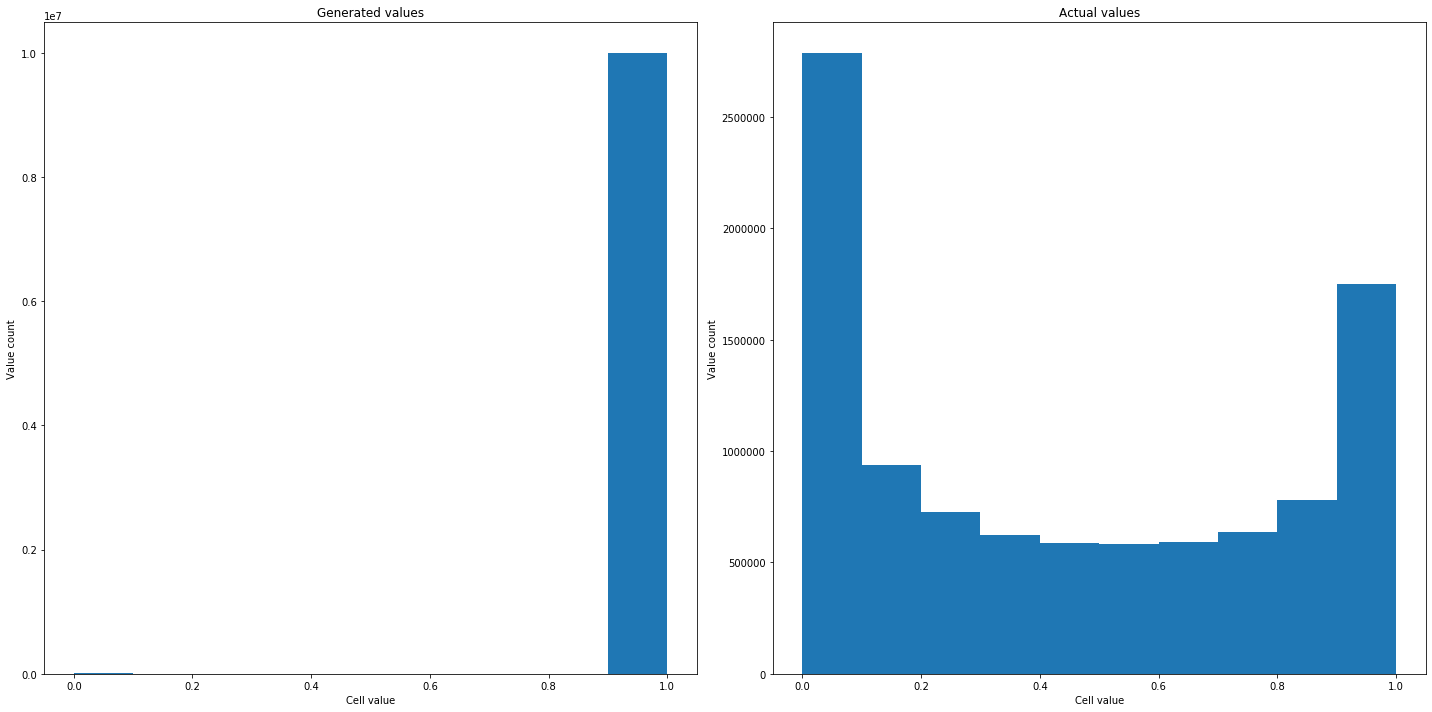

In [202]:
# Try sigmoid, sigmoid, sigmoid, linear
create_model_save_and_test('rep.10')